# 준비작업 및 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/bigcontest/

/content/drive/MyDrive/Colab Notebooks/bigcontest


## Module install

In [ ]:
!pip install tensorflow-addons

In [ ]:
# 모델링 모듈
!pip install tensorflow-addons
!pip install neuralprophet[live]
!pip install prophet

     |████████████████████████████████| 56 kB 2.6 MB/s 
     |████████████████████████████████| 748.8 MB 12 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.6.0 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.6.0 which is incompatible.
     |████████████████████████████████| 65 kB 2.6 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 178 kB 17.2 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640373 sha256=22bfe8958aada3202a2ef0fca18e132ddef4b29de871b92eaf9ef65568eef7d8
  Stored in directory: /root/.cache/p

## Font issue

In [ ]:
# colab이라면 런타임 재시작 필요

%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
# plot 한글
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': # 맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':# 윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

## Module import

In [ ]:
# 내장 라이브러리
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# 외장 라이브러리
from typing import collections, List, Tuple, Dict, DefaultDict, NewType
from collections import Counter
from datetime import datetime, timedelta
from timeit import default_timer as timer

# sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Facebook Prophet - 시계열 모델
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_yearly
# Neural Prophet - Advanced Facebook Prophet
from neuralprophet import NeuralProphet
# 시계열 모델
from statsmodels.tsa.arima_model import ARIMA
# Attention 모델
import keras
from tensorflow_addons.layers import MultiHeadAttention

## Load data

In [ ]:
## 중량 수온 데이터를 합친 dataframe, 품목 별로 불러오기
squid_train = pd.read_csv("./squid_train.csv")
squid_val = pd.read_csv("./squid_val.csv")
shrimp_train = pd.read_csv("./shrimp_train.csv")
shrimp_val = pd.read_csv("./shrimp_val.csv")
salmon_train = pd.read_csv("./salmon_train.csv")
salmon_val = pd.read_csv("./salmon_val.csv")

# 데이터 전처리

## 데이터 구조 변환

In [ ]:
## 품목별 dataframe을 생성하고, 일자별 거래의 갯수를 리스트 형태로 저장
def datasetting(train, p_name):
  just_p = pd.DataFrame(columns=train.columns.tolist())
  len_list = []
  for i, day_time in enumerate(list(Counter(train['REG_DATE']).keys())):
    day_df = train[train['REG_DATE']==day_time]
    just_p = pd.concat([just_p, day_df[day_df['P_NAME']==p_name]])
    len_list.append(len(day_df[day_df['P_NAME']==p_name]))
  return just_p, len_list

In [ ]:
## import type을 multi-hot encoding 하기 위한 방법
def data_encoding(df, type_):
  tmp = []
  for impo in df[type_]:
    types = impo.split(',')
    for i in types:
      tmp.append(i)
  return list(set(tmp))

In [ ]:
## 명목형 변수는 dummy 처리해서 multi-hot 형태로 할당하고, 수치형 변수는 스케일링 작업 진행

def data_frame(trains, ctry_list, import_type):

  con = ctry_list
  con.sort()
  col_con = [f"country_{co}" for co in con]
  col_imp = [f"import_{im}" for im in import_type]
  cols = col_con + col_imp + ['weight', 'temp', 'price']
  # print(cols)
  x_train = pd.DataFrame(columns=cols)
  tmp = []
  for i in range(len(cols)-1):
    tmp.append([])
  len_a = len(col_con)
  len_b = len(col_imp)
  for c1, c2, p in zip(trains['CTRY_1'], trains['CTRY_2'], trains['P_IMPORT_TYPE']):
    i = con.index(c1)
    j = con.index(c2)
    country = np.eye(len_a)[i] + np.eye(len_a)[j] ## 제조국 + 수출국 정보 결합

    p_import = np.zeros(len_b)
    for ty in p.split(','):
      j = import_type.index(ty)
      p_import += np.eye(len(p_import))[j] ## import type 정보 결합

    row = np.concatenate([country, p_import])

    for i, r in enumerate(row):
      tmp[i].append(r)

  for i, c in enumerate(cols[:-3]): ## 중량, 수온, 가격 이외의 것들만 고려
    x_train[c] = tmp[i]

  ## 중량과 수온 데이터 스케일링
  w = trains['WEIGHT(KG)'].tolist()
  w = np.array(w).reshape(-1,1)
  t = trains['temp'].tolist()
  t = np.array(t).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(w)
  t_data = scaler.transform(w)

  wscaler = MinMaxScaler()
  wscaler.fit(t)
  w_data = wscaler.transform(t)

  x_train['weight'] =  t_data
  x_train['temp'] = w_data
  x_train['price'] = trains['P_PRICE'].tolist()

  return x_train

In [ ]:
## 수입목적도 같이 고려할경우 사용

def p_purpose(df, data):
  p_df = pd.get_dummies(data[['P_PURPOSE']])
  c_df = pd.concat([df.iloc[:,:-1], p_df, df.iloc[:,-1]], axis=1)
  return c_df

## 어텐션 블록 클래스

In [ ]:
num_heads=8; head_size=32; ff_dim=None; dropout=0

multi = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)

In [ ]:
## Attention을 계산하는 모듈 생성

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0.2, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(1)
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)
        
        return x

In [ ]:
## Attention을 여러번 계산하고 마치막 출력으로 Fully_connected layer를 통해 차원 축소

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', num_heads=2, head_size=128, ff_dim=None, num_layers=10, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
      self.dense2 = keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
      x = inputs
      for attention_layer in self.attention_layers:
          x = attention_layer(x)
      x = self.dense2(x)
      return x

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
## 독립변수, 종속변수와 주당 가격 개수가 담긴 리스트를 입력받아 최종 P_PRICE당 weight와 P_PRICE를 도출
def make_weight(x, y, length):
    # 날짜별로 attention score 담을 list
    weight_score = []
    # 날짜별로 p_price 담을 list
    p_price = []
    final_weight = []

    before = 0
    for leng in length:
      if leng==0:
        weight_score.append([[0]])
        p_price.append([[0]])
      else:
        a = np.array(x[before:before+leng])
        b = np.array(y[before:before+leng]).tolist()
        arr = attention_layers(a)
        ## attention score를 softmax 함수를 이용하여 정규화
        weight_score.append(np.array(softmax(arr)).tolist())
        p_price.append(b)
        ## leng 간격마다 weight를 계산하기 때문에 연산을 한 번 진행하고 leng만큼 이후에 다시 시작
        before += leng

    for w in weight_score:
      ## 이중 리스트 제거
      aa = sum(w, [])
      final_weight.append(aa)

    return final_weight, p_price

In [ ]:
## attention score를 이용해 만든 weight로 가중평균하여 새로운 PRICE를 도출
def make_new_price(weight_list, price_list):
    new_price = []
    new_price_m = 0
    new_price_s = 0

    for i in range(len(weight_list)):
        if weight_list[i]==[0]:
            new_price.append(0)
        else:
            for j in range(len(weight_list[i])):
                new_price_m += (weight_list[i][j] * price_list[i][j])
                new_price_s += weight_list[i][j]
            new_price_sum = new_price_m / new_price_s
            new_price.append(new_price_sum)
    return new_price

# 모델링

## 오징어

### 더미 변수 생성

In [ ]:
squid_t, squid_t_len = datasetting(squid_train, "오징어")
squid_v, squid_v_len = datasetting(squid_val, "오징어")

In [ ]:
squid_t.head(5)

Unnamed: 0    REG_DATE P_TYPE  ... WEIGHT(KG) TOTAL_PRICE       temp
0          0  2015-12-28    수산물  ...    33475.0     29328.0   4.435041
1          1  2015-12-28    수산물  ...    46200.0         0.0  14.602099
2          2  2015-12-28    수산물  ...    66560.0    189200.0  14.602099
3          3  2015-12-28    수산물  ...    48000.0     40080.0  14.845271
4          4  2015-12-28    수산물  ...    48000.0     48000.0  14.845271

[5 rows x 17 columns]

In [ ]:
p_type = "P_IMPORT_TYPE"
squid_import_type_t = data_encoding(squid_t, p_type)

In [ ]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(squid_t['CTRY_1']))+list(set(squid_t['CTRY_2'])))
ctry_2 = set(list(set(squid_v['CTRY_1']))+list(set(squid_v['CTRY_2'])))
con = list(ctry_1) + list(ctry_2)
ctry_list = list(set(con))

In [ ]:
squid_dummy = data_frame(squid_t, ctry_list, squid_import_type_t)
display(squid_dummy.head(10))
print(squid_dummy.shape)

country_뉴질랜드  country_대만  country_대한민국  ...    weight      temp     price
0           0.0         0.0           0.0  ...  0.053357  0.029606  0.793729
1           0.0         0.0           0.0  ...  0.073701  0.552450  1.233434
2           0.0         0.0           0.0  ...  0.106251  0.552450  5.481140
3           0.0         0.0           0.0  ...  0.076579  0.564955  0.762758
4           0.0         0.0           0.0  ...  0.076579  0.564955  0.962386
5           0.0         0.0           0.0  ...  0.006747  0.590568  0.945644
6           0.0         0.0           0.0  ...  0.035012  0.559531  3.716541
7           0.0         0.0           0.0  ...  0.035012  0.559531  5.226860
8           0.0         0.0           0.0  ...  0.035012  0.559531  1.033333
9           0.0         0.0           0.0  ...  0.035012  0.559531  1.074333

[10 rows x 26 columns]

(1333, 26)


In [ ]:
squid_dummy_val = data_frame(squid_v, ctry_list, squid_import_type_t)
display(squid_dummy_val.head(10))
print(squid_dummy_val.shape)

country_뉴질랜드  country_대만  country_대한민국  ...    weight      temp     price
0           0.0         0.0           0.0  ...  0.039569  0.449827  2.855495
1           0.0         0.0           0.0  ...  0.037825  0.449827  1.678069
2           0.0         0.0           0.0  ...  0.041312  0.451879  2.281498
3           0.0         0.0           0.0  ...  0.189317  0.305510  4.390908
4           0.0         0.0           0.0  ...  0.189317  0.305510  4.347919
5           0.0         0.0           0.0  ...  0.074713  0.305510  2.840471
6           0.0         0.0           0.0  ...  0.006446  0.423873  2.180337
7           0.0         0.0           0.0  ...  0.006446  0.423873  2.510326
8           0.0         2.0           0.0  ...  0.054769  0.908548  4.550002
9           0.0         0.0           0.0  ...  0.020880  0.274950  3.207922

[10 rows x 26 columns]

(388, 26)


In [ ]:
## 수입목적 고려하도록 변수 재설정
squid_dummy = p_purpose(squid_dummy, squid_t)
squid_dummy_val = p_purpose(squid_dummy_val, squid_v)

In [ ]:
squid_x = np.array(squid_dummy.iloc[:,:-1])
squid_y = np.array(squid_dummy.iloc[:,-1])
squid_y = squid_y.reshape(-1)

In [ ]:
squid_val_x = np.array(squid_dummy_val.iloc[:,:-1])
squid_val_y = np.array(squid_dummy_val.iloc[:,-1])
squid_val_y = squid_val_y.reshape(-1)

In [ ]:
## 새우처럼 temp를 빼지 않음
squid_x.shape, squid_y.shape, squid_val_x.shape, squid_val_y.shape

((1333, 29), (1333,), (388, 29), (388,))

### Attention block을 이용한 가중평균

In [ ]:
attention_layers = ModelTrunk(num_layers=8)

In [ ]:
squid_train_weight, squid_train_price = make_weight(squid_x, squid_y, squid_t_len)

In [ ]:
squid_val_weight, squid_val_price = make_weight(squid_val_x, squid_val_y,squid_v_len)

In [ ]:
squid_train_price = make_new_price(squid_train_weight, squid_train_price)

In [ ]:
squid_val_price = make_new_price(squid_val_weight, squid_val_price)

In [ ]:
squid_t['REG_DATE'] = pd.to_datetime(squid_t['REG_DATE'])
squid_v['REG_DATE'] = pd.to_datetime(squid_v['REG_DATE'])

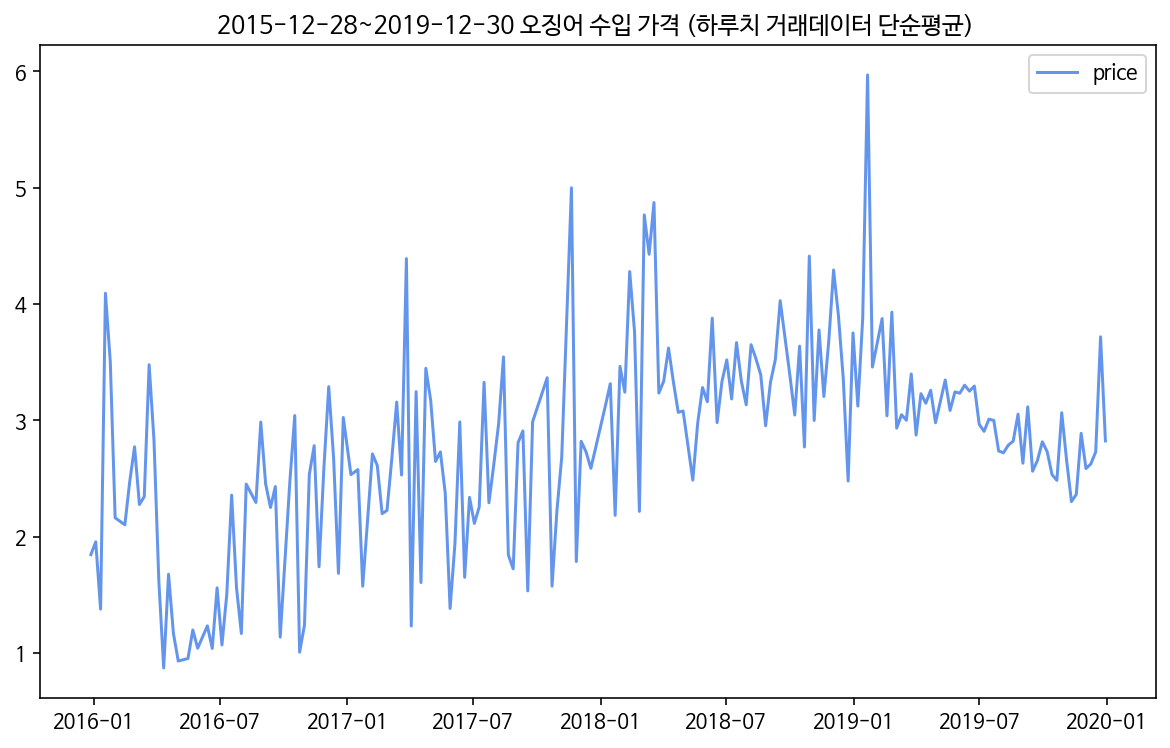

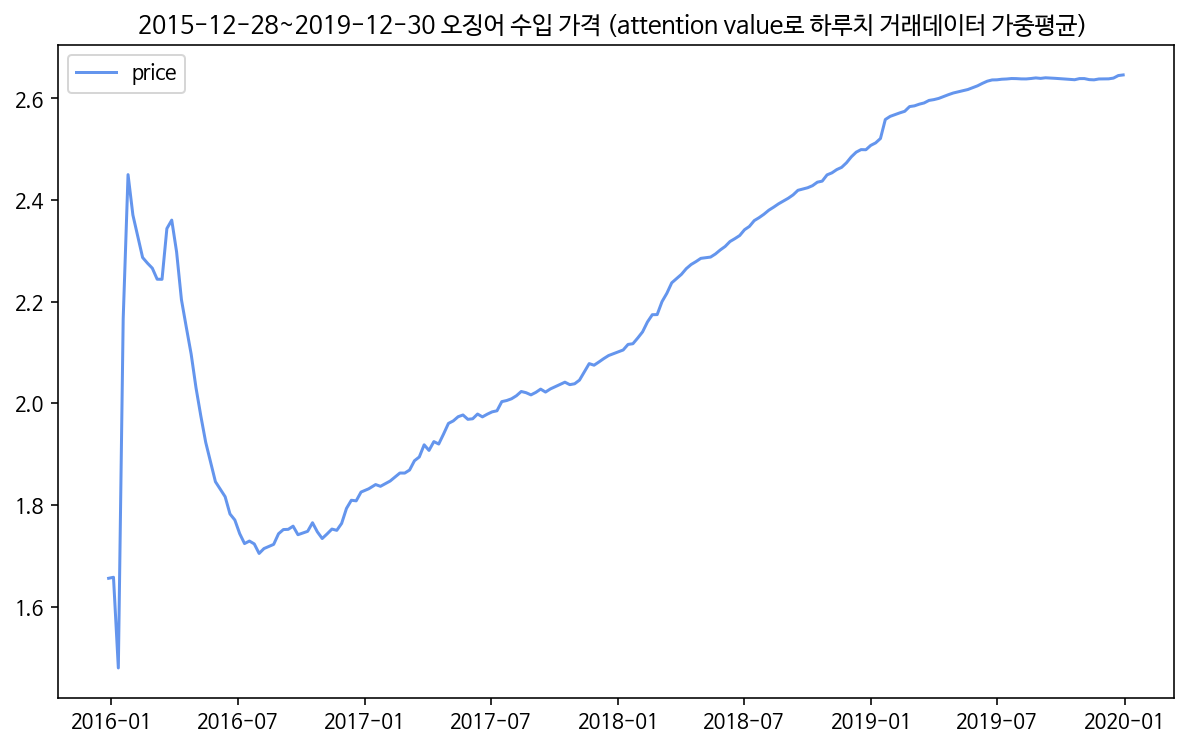

In [ ]:
'''
num_layer = 8
'''

plt.figure(figsize=(10, 6))

plt.plot(squid_t['P_PRICE'].groupby(squid_t['REG_DATE']).mean(), color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2015-12-28~2019-12-30 오징어 수입 가격 (하루치 거래데이터 단순평균) ")
plt.show()


plt.figure(figsize=(10, 6))

x = squid_t['REG_DATE'].unique()
y = squid_train_price
plt.plot(x,y, color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2015-12-28~2019-12-30 오징어 수입 가격 (attention value로 하루치 거래데이터 가중평균) ")
plt.show()

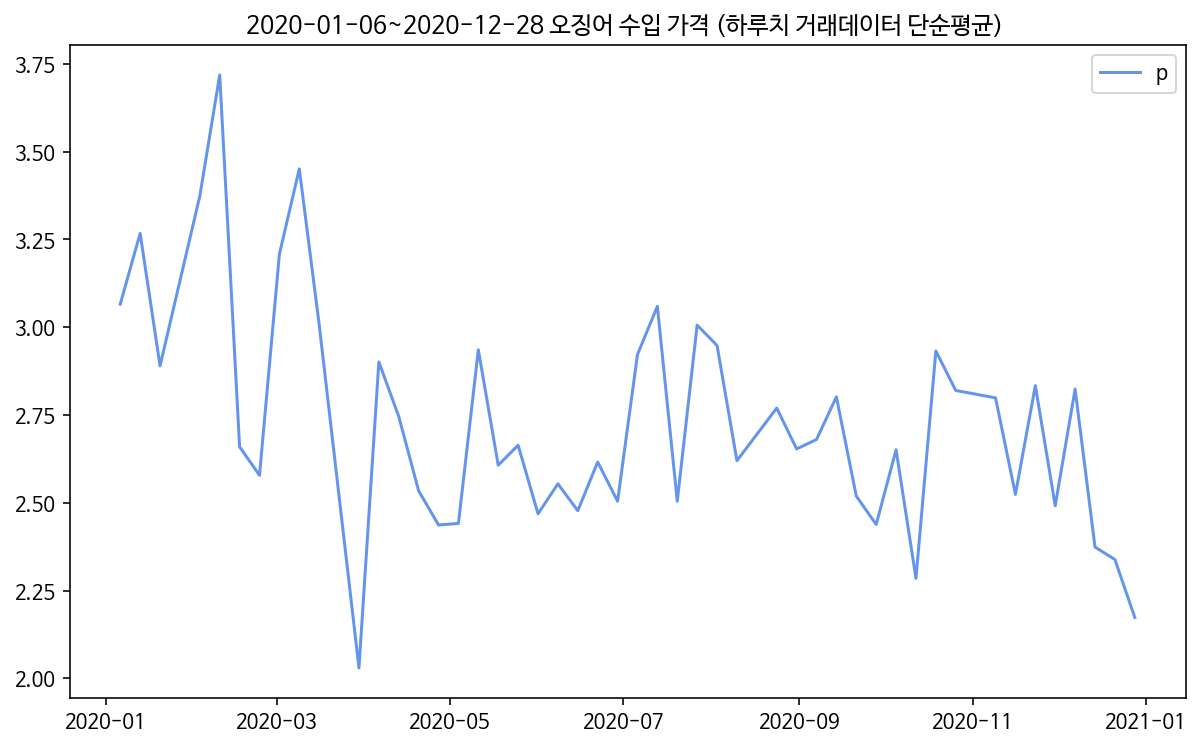

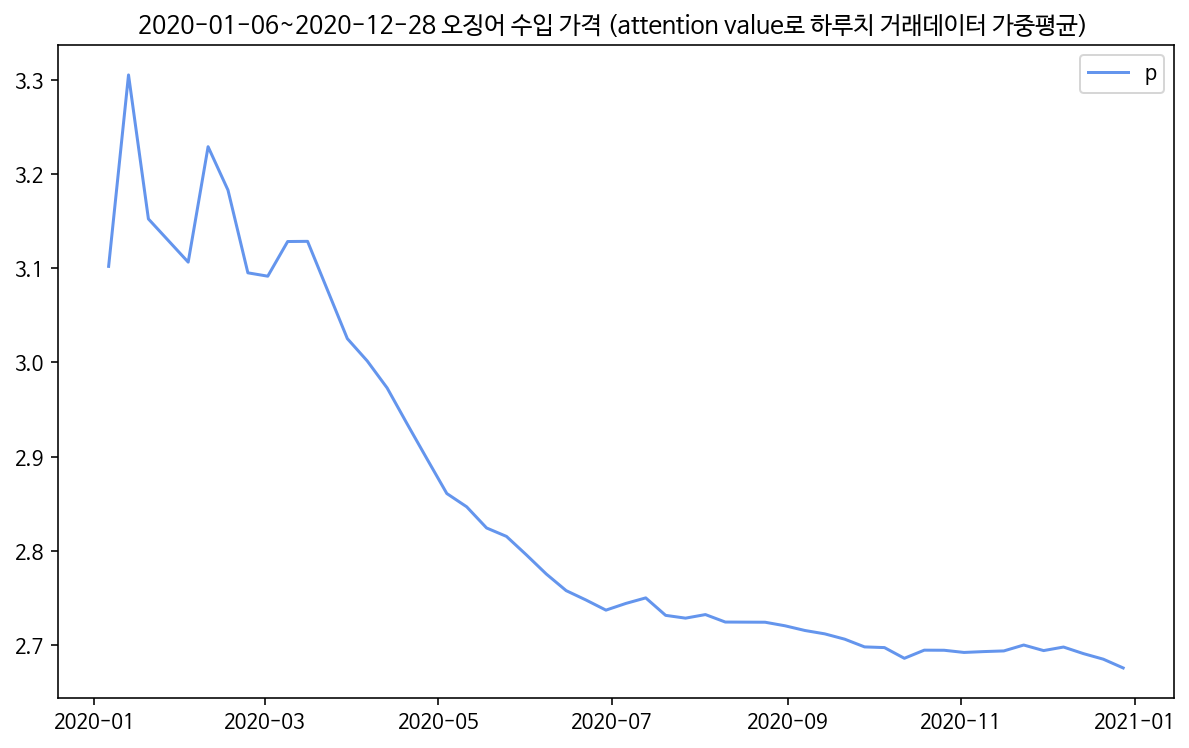

In [ ]:
'''
num_layer = 8
'''
plt.figure(figsize=(10, 6))

plt.plot(squid_v['P_PRICE'].groupby(squid_v['REG_DATE']).mean(), color = 'cornflowerblue')
plt.legend('price')
plt.title("2020-01-06~2020-12-28 오징어 수입 가격 (하루치 거래데이터 단순평균) ")
plt.show()


plt.figure(figsize=(10, 6))

x = squid_v['REG_DATE'].unique()
y = squid_val_price
plt.plot(x,y, color = 'cornflowerblue')
plt.legend('price')
plt.title("2020-01-06~2020-12-28 오징어 수입 가격 (attention value로 하루치 거래데이터 가중평균) ")
plt.show()

### ARIMA 비교

In [ ]:
squid_trn_lst = np.array([item for item in squid_train_price if item > 0])

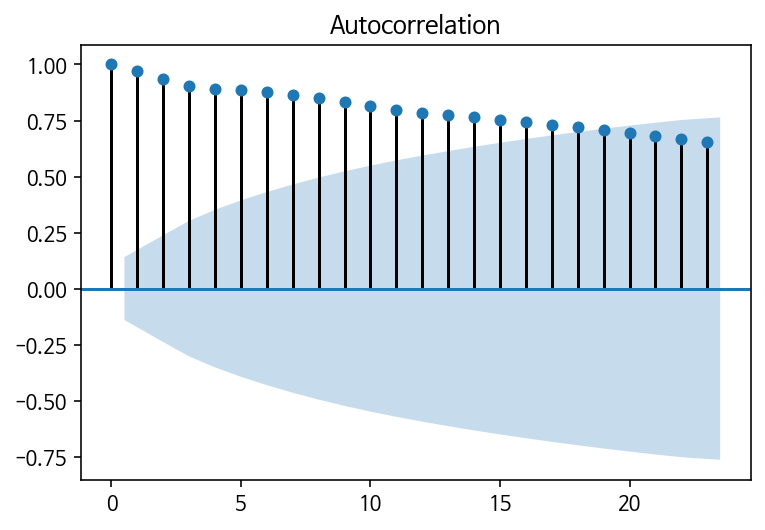

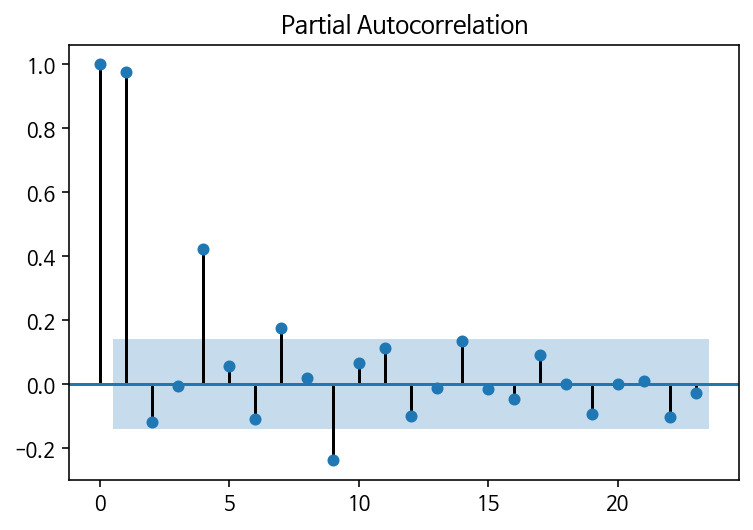

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(np.array(squid_train_price))
plot_pacf(np.array(squid_train_price))
plt.show()

In [ ]:
squid_ts_train = np.array(squid_train_price)

In [ ]:
model = ARIMA(squid_trn_lst, order=(0,2,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  193
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 272.384
Method:                       css-mle   S.D. of innovations              0.058
Date:                Wed, 15 Sep 2021   AIC                           -538.768
Time:                        04:10:12   BIC                           -528.980
Sample:                             2   HQIC                          -534.804
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.038e-05   7.46e-05     -0.273      0.785      -0.000       0.000
ma.L1.D2.y    -1.0000      0.015    -66.459      0.000      -1.029      -0.971
                                    Roots           

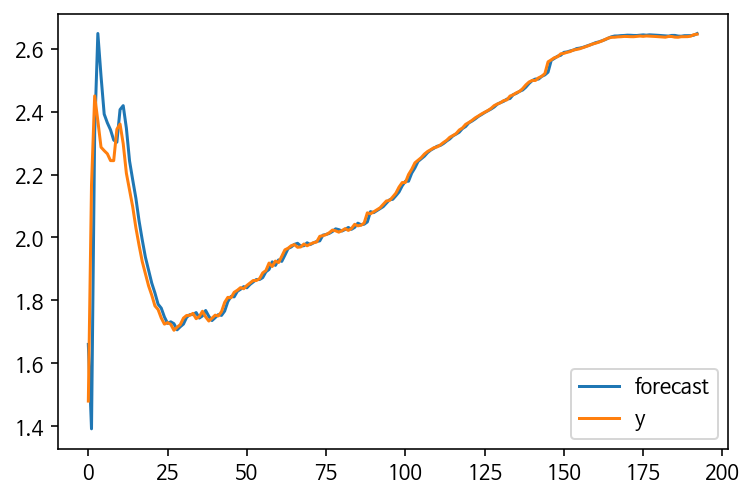

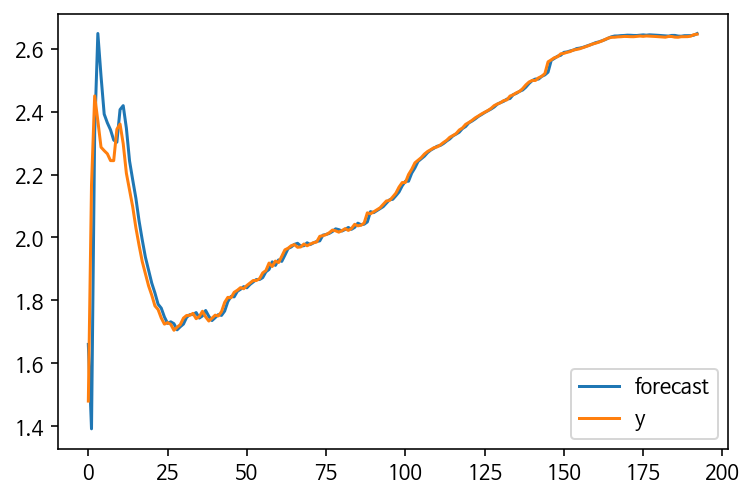

In [ ]:
model_fit.plot_predict()

In [ ]:
fore = model_fit.forecast(steps=52)

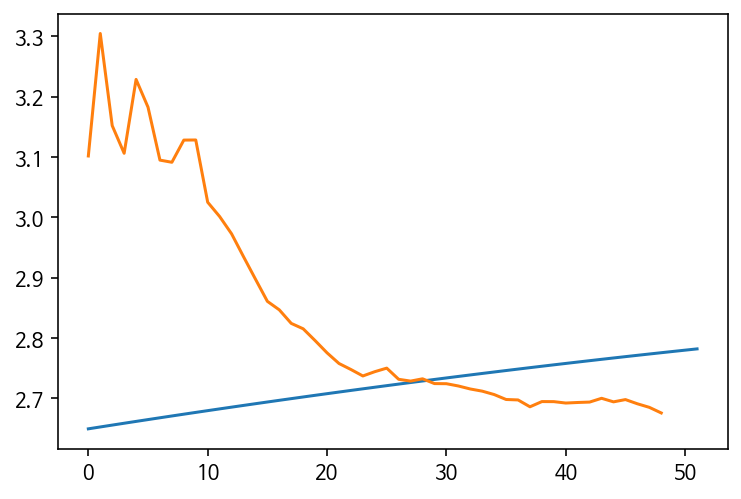

In [ ]:
plt.plot(fore[0])
plt.plot(squid_val_price)

### Facebook Prophet

In [ ]:
## 프로펫에 피팅하기 위해서 dataframe 형태 수정

squid_prophet_df = pd.DataFrame(columns=['ds','y'])
squid_prophet_df['ds'] = list(Counter(squid_train['REG_DATE']).keys())
squid_prophet_df['y'] = squid_ts_train

In [ ]:
m = Prophet(changepoint_prior_scale=0.3)
m.fit(squid_prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

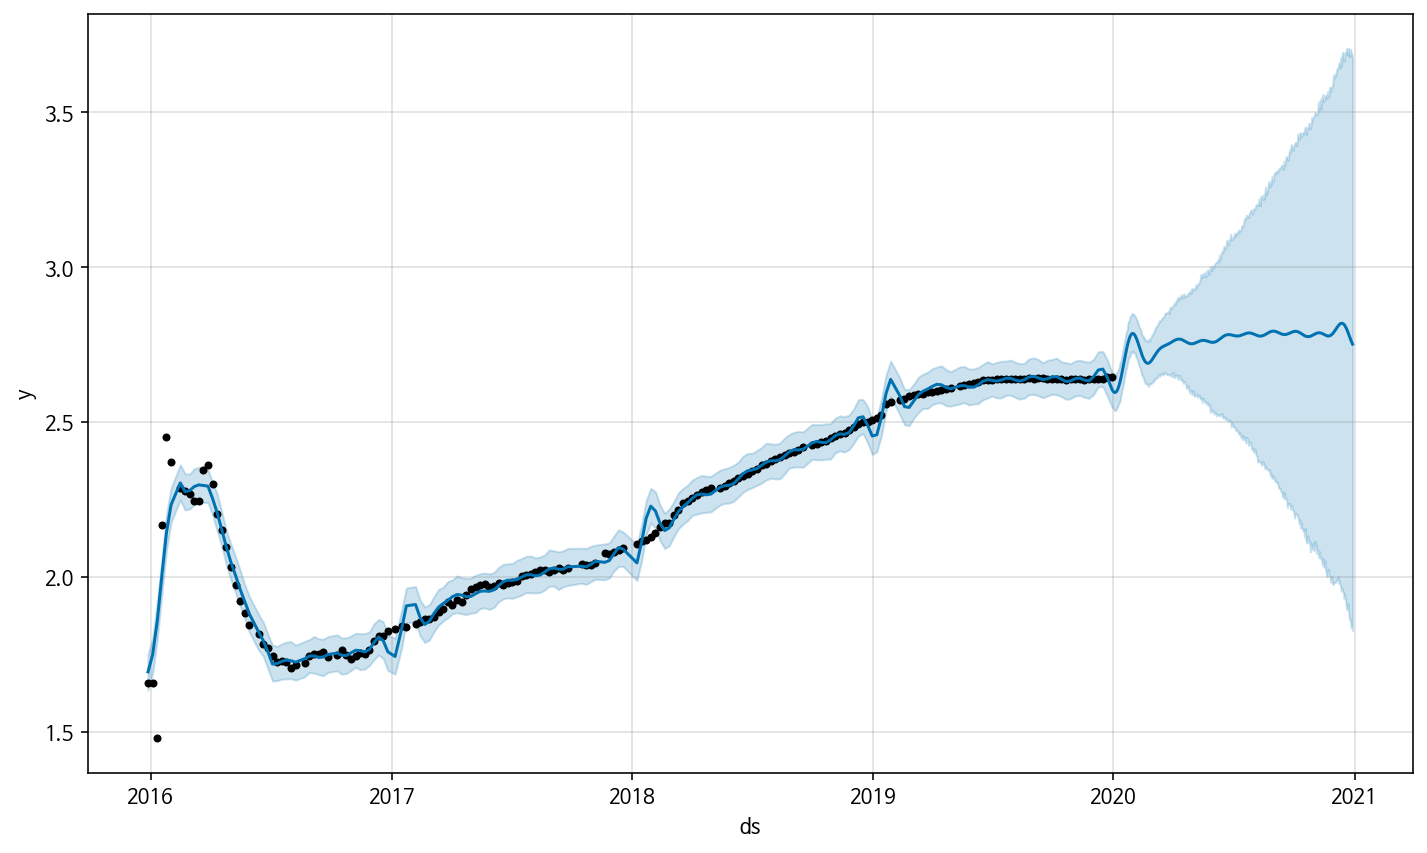

In [ ]:
plt.rc("figure", figsize=(10,6))
fig1 = m.plot(forecast)

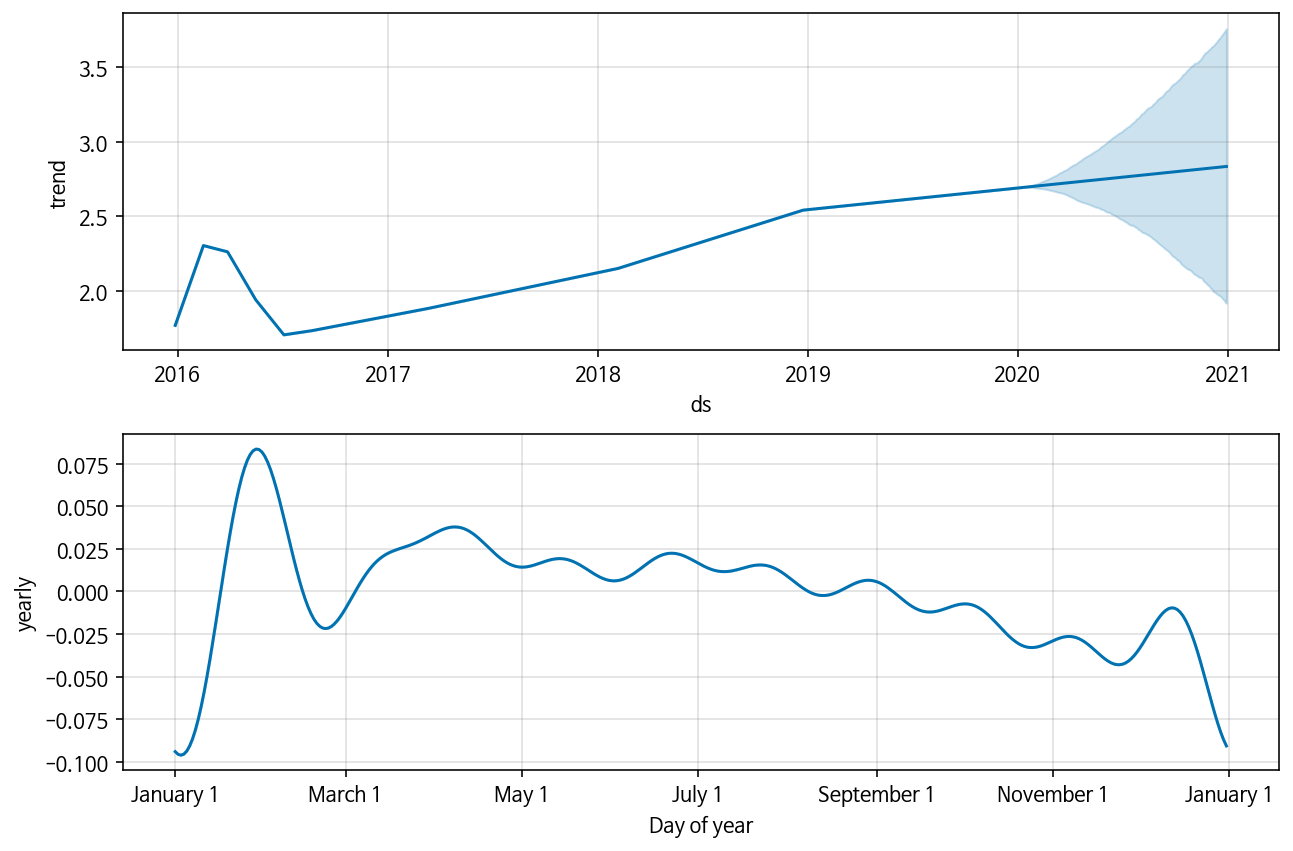

In [ ]:
plt.rc("figure", figsize=(10,6))
fig2 = m.plot_components(forecast)

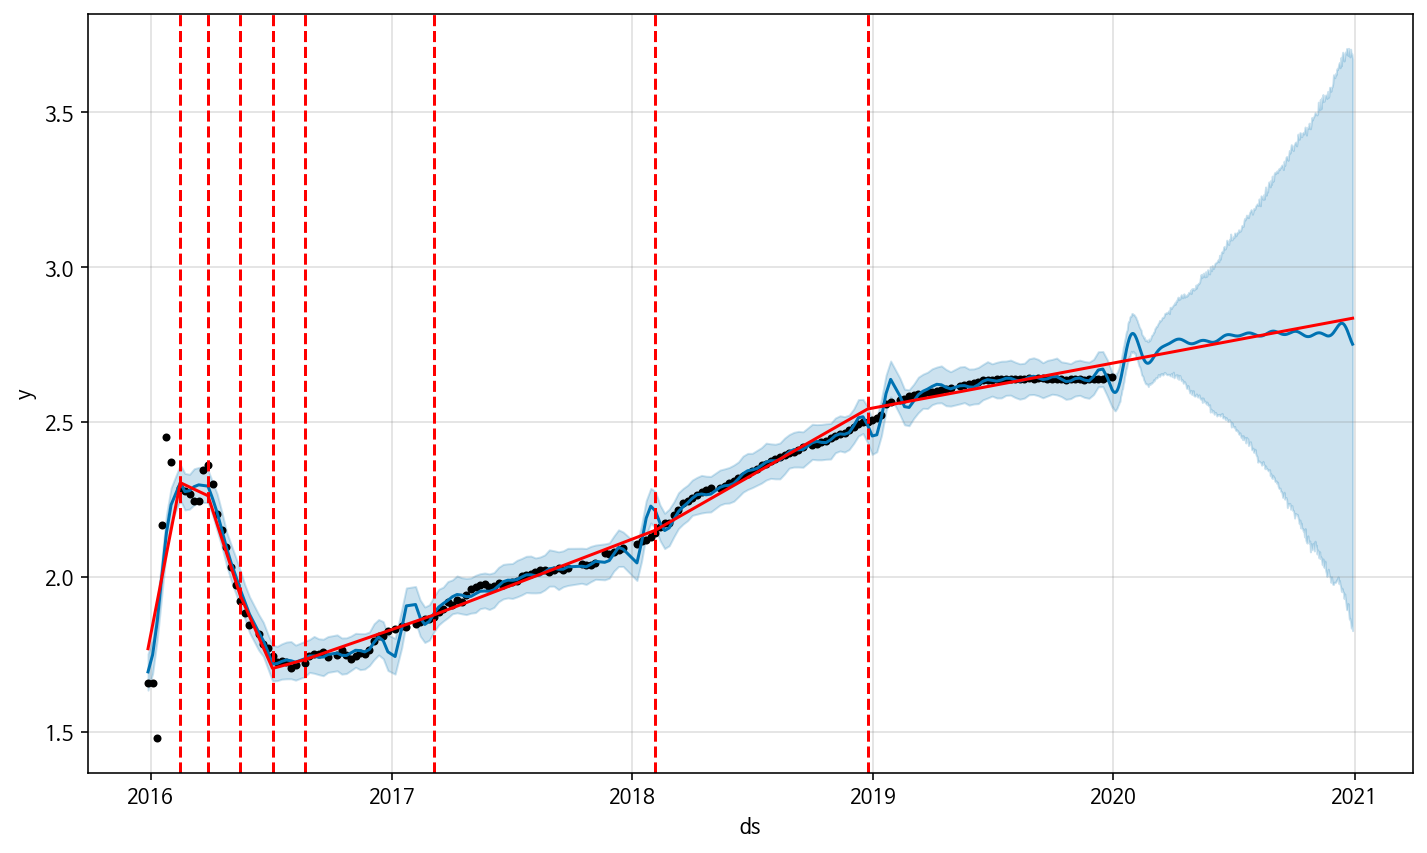

In [ ]:
plt.rc("figure", figsize=(10,6))
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

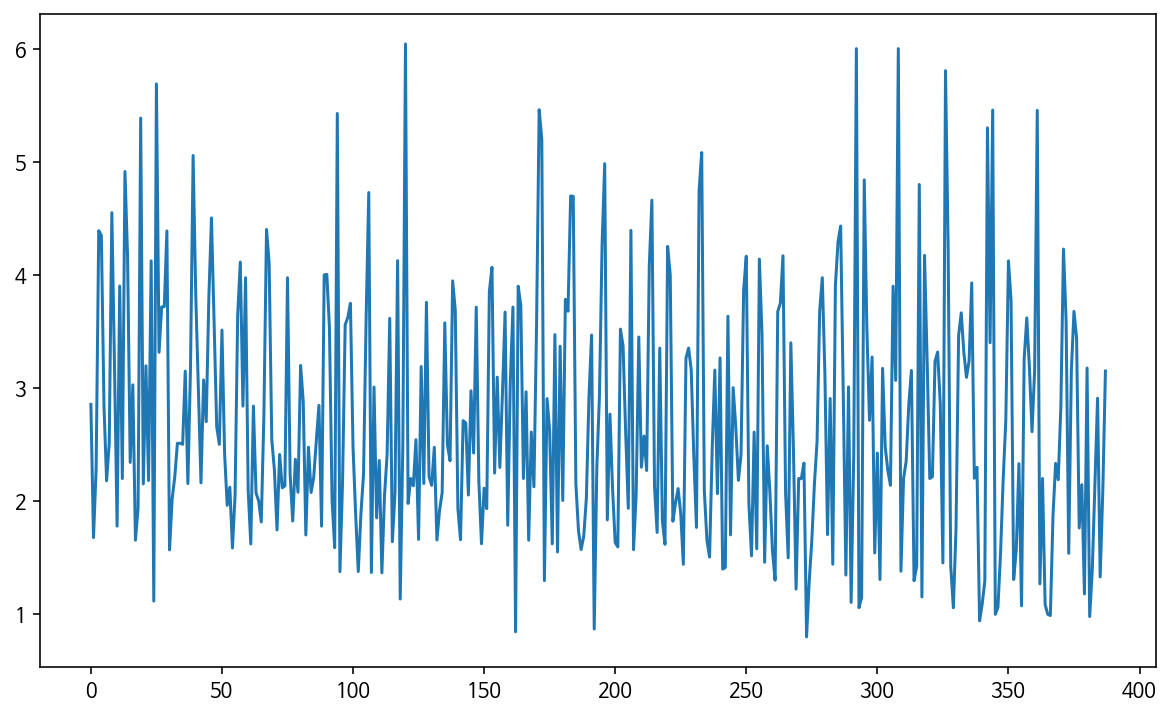

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(squid_val_y)

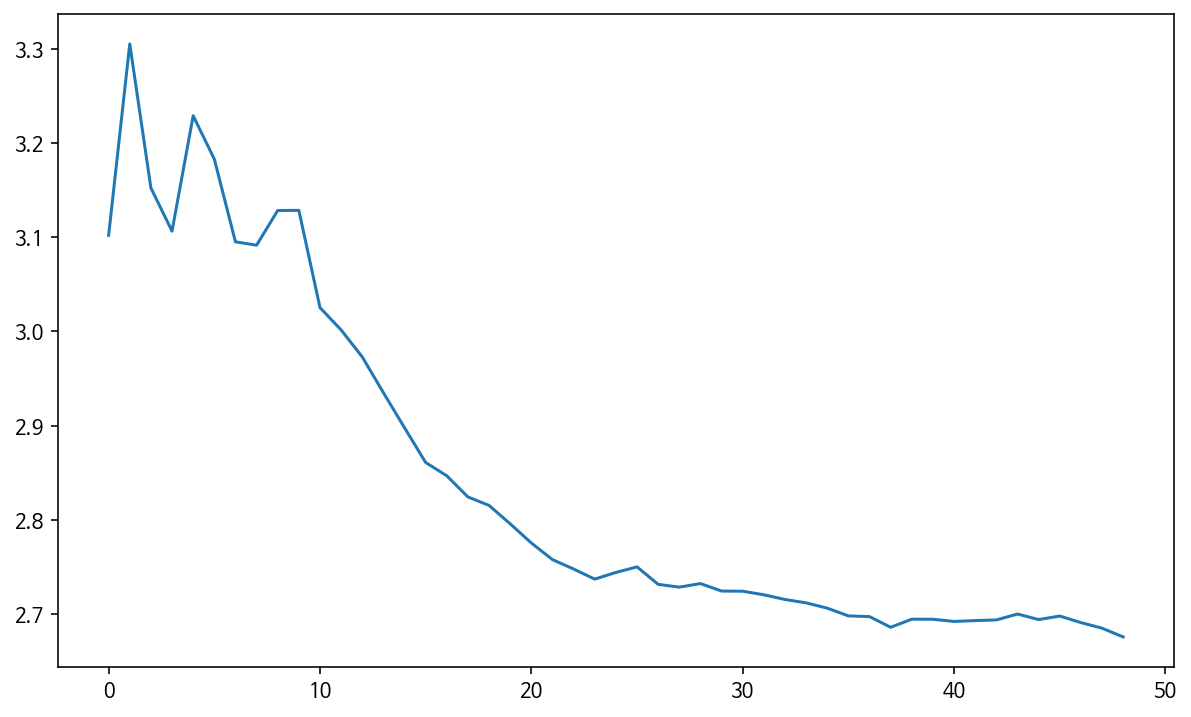

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(squid_val_price)

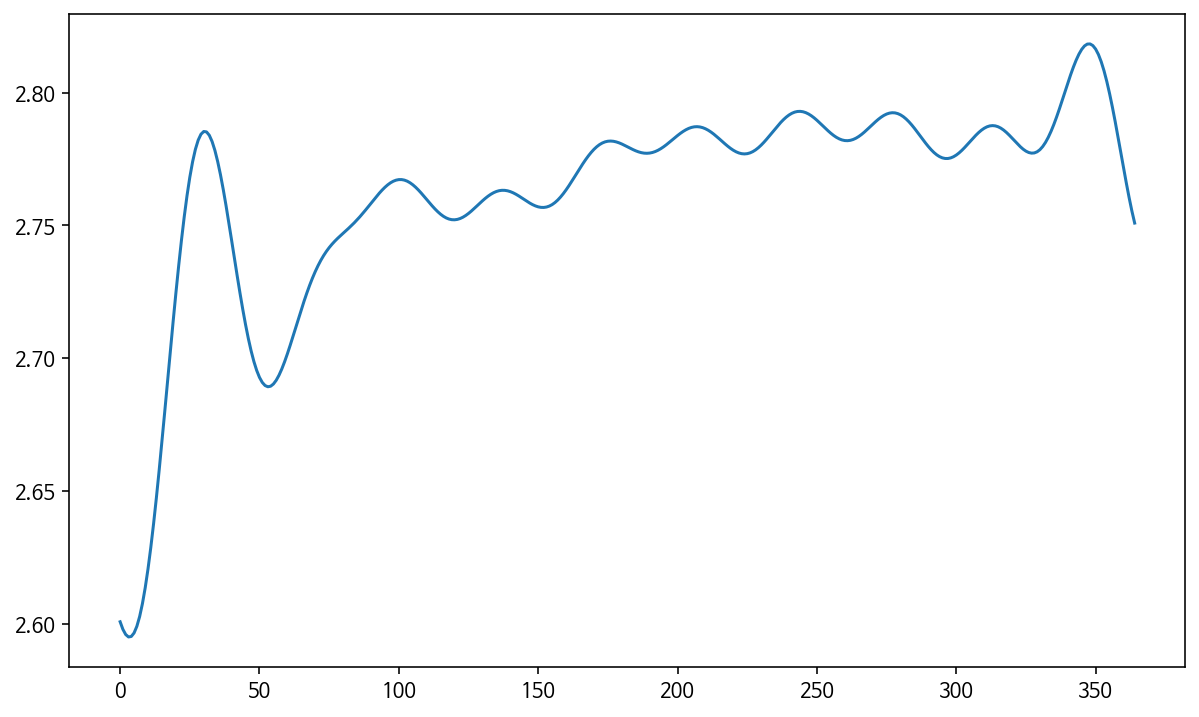

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(list(forecast[-365:]['yhat']))

In [ ]:
forecast.head(10)

ds     trend  ...  multiplicative_terms_upper      yhat
0 2015-12-28  1.767881  ...                         0.0  1.693131
1 2016-01-04  1.844442  ...                         0.0  1.748332
2 2016-01-11  1.921004  ...                         0.0  1.855596
3 2016-01-18  1.997565  ...                         0.0  2.003158
4 2016-01-25  2.074127  ...                         0.0  2.142613
5 2016-02-01  2.150688  ...                         0.0  2.232182
6 2016-02-15  2.303811  ...                         0.0  2.303191
7 2016-02-22  2.296792  ...                         0.0  2.275223
8 2016-02-29  2.289773  ...                         0.0  2.277796
9 2016-03-07  2.282754  ...                         0.0  2.290948

[10 rows x 16 columns]

### Neural Prophet

In [ ]:
# 평가지표 RMSE 함수
def rmse(y: List, yhat:List)->float:
  # y값의 갯수
  n = len(y)
  mse = 0
  for i in range(n):
    # 실제값에서 예측값 뺀것의 제곱
    mse += (y[i] - yhat[i])**2
  rmse = (mse/n)**0.5
  return rmse

In [ ]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 
epochs = 1000

#### Neural Prophet - normal

In [ ]:
## 모델 피팅하기 위해서 수정된 dataframe 사용
squid_prophet_df.shape

(195, 2)

In [ ]:
# 예측 기간 데이터셋 생성
squid_prophet_df_val = list(squid_v['REG_DATE'].unique())
squid_prophet_future = pd.DataFrame(squid_prophet_df_val, columns=['ds'])
squid_prophet_future['y'] = None

In [ ]:
# 모델 학습
m = NeuralProphet()
metrics = m.fit(squid_prophet_df, freq=freq, epochs=epochs)

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s, SmoothL1Loss=0.00168, MAE=0.0494, RegLoss=0]


In [ ]:
# train 데이터의 마지막일 기준으로, 일주일 간격 * 70 의 테스트데이터 생성
squid_future = m.make_future_dataframe(squid_prophet_df, periods=70)
squid_forecast = m.predict(squid_future)

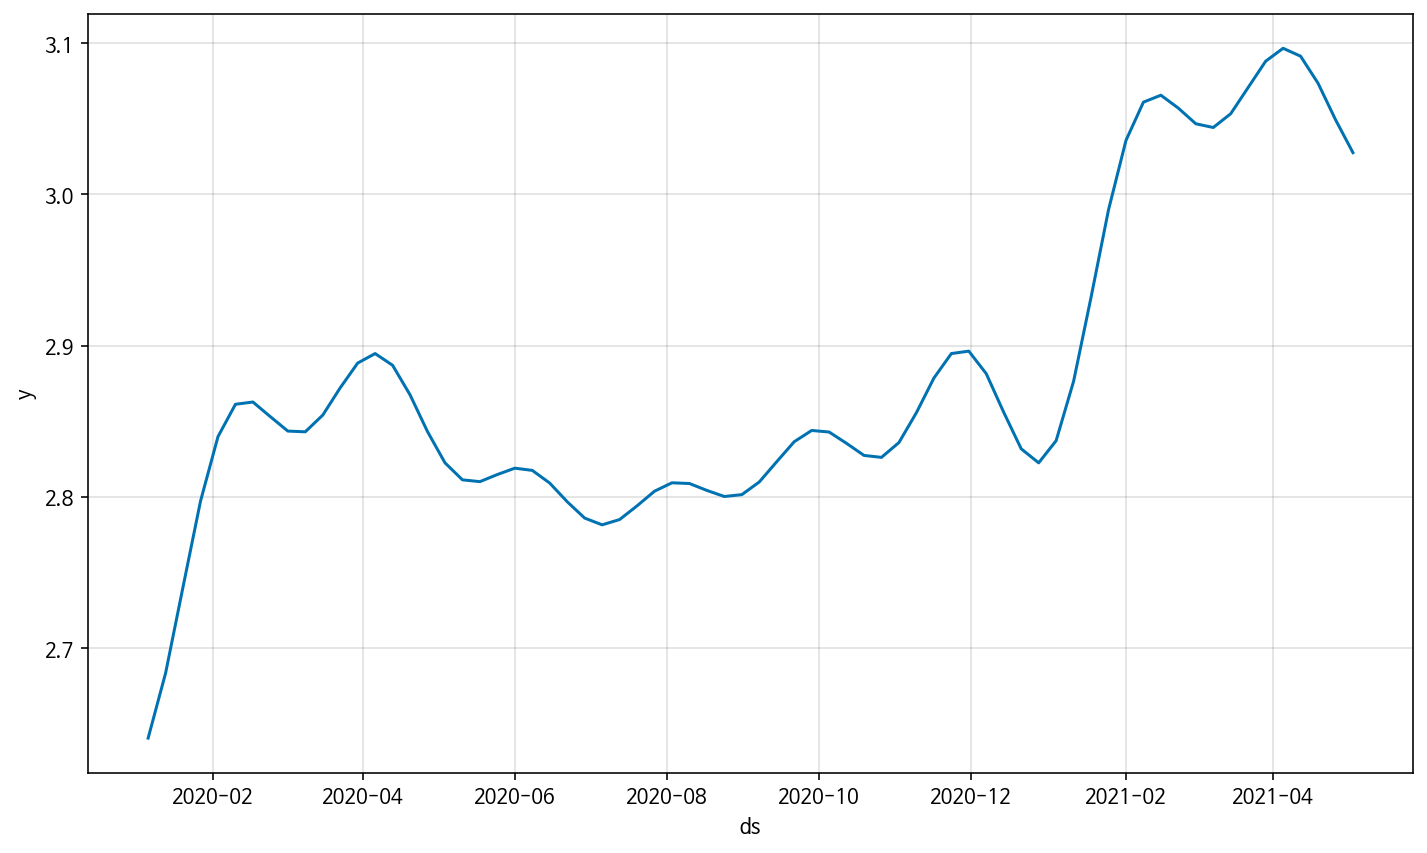

In [ ]:
squid_forecasts_plot = m.plot(squid_forecast)

In [ ]:
# validation 기간에 맞는 예측 데이터 프레임 구성
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in squid_prophet_df_val:
  a = a.append(squid_forecast.iloc[squid_forecast.loc[squid_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(squid_val_price, a['yhat1'])

0.19433576590365406

#### Neural Prophet - Trend

In [ ]:
m = NeuralProphet(
    n_changepoints=100,
    #trend_smoothness=2,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs =epochs
)
metrics = m.fit(squid_prophet_df, freq=freq)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.56it/s, SmoothL1Loss=0.000599, MAE=0.016, RegLoss=0]


In [ ]:
squid_future = m.make_future_dataframe(squid_prophet_df, periods=70, n_historic_predictions=len(squid_prophet_df))
squid_forecast = m.predict(squid_future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in squid_prophet_df_val:
  a = a.append(squid_forecast.iloc[squid_forecast.loc[squid_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(squid_val_price, a['yhat1'])

0.24953368129888054

#### Nueral Prophet - Seasonality

In [ ]:
m = NeuralProphet(
    n_changepoints=200,
    yearly_seasonality=15,
    weekly_seasonality=3,
    seasonality_reg=30,
    num_hidden_layers=20,
)
metrics = m.fit(squid_prophet_df, freq=freq)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 164
INFO:nprophet.config:Auto-set epochs to 164


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[164/164]: 100%|██████████| 164/164 [00:14<00:00, 11.49it/s, SmoothL1Loss=0.00124, MAE=0.0285, RegLoss=6.94e-5]


In [ ]:
squid_future = m.make_future_dataframe(squid_prophet_df, periods=70, n_historic_predictions=len(squid_prophet_df))
squid_forecast = m.predict(squid_future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in squid_prophet_df_val:
  a = a.append(squid_forecast.iloc[squid_forecast.loc[squid_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(squid_val_price, a['yhat1'])

0.24871496924415745

#### 최적 하이퍼 파라미터

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

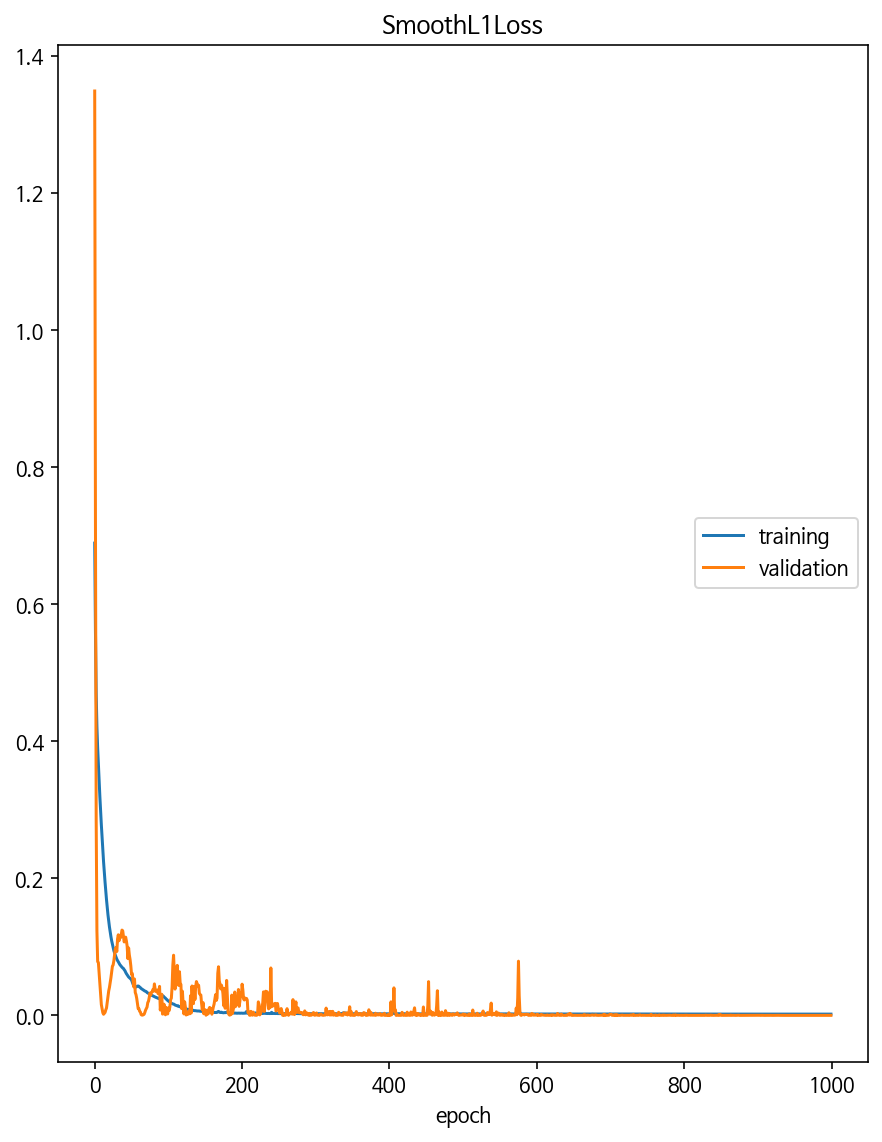

Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:17<00:00, 12.82it/s, SmoothL1Loss=0.00185, MAE=0.0346, RegLoss=0.000892, MAE_val=0.00961, SmoothL1Loss_val=2.68e-5]


In [ ]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(squid_prophet_df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [ ]:
squid_future = nprophet.make_future_dataframe(squid_prophet_df, periods=52, n_historic_predictions=300)
squid_forecast = nprophet.predict(squid_future)
squid_forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)
squid_forecast.tail()

ds   y     yhat1  residual1     trend  season_weekly  season_daily
242 2020-11-30 NaN  2.685719        NaN  2.685719  -2.440327e-08  7.368055e-08
243 2020-12-07 NaN  2.686361        NaN  2.686361  -2.440327e-08  7.368055e-08
244 2020-12-14 NaN  2.687004        NaN  2.687004  -2.440327e-08  7.368055e-08
245 2020-12-21 NaN  2.687646        NaN  2.687646  -2.440327e-08  7.368055e-08
246 2020-12-28 NaN  2.688289        NaN  2.688289  -2.440327e-08  7.368055e-08

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in squid_prophet_df_val:
  a = a.append(squid_forecast.iloc[squid_forecast.loc[squid_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(squid_val_price, a['yhat1'])

0.2529456203829546

#### 최적 하이퍼 파라미터 ver.2

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.01


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

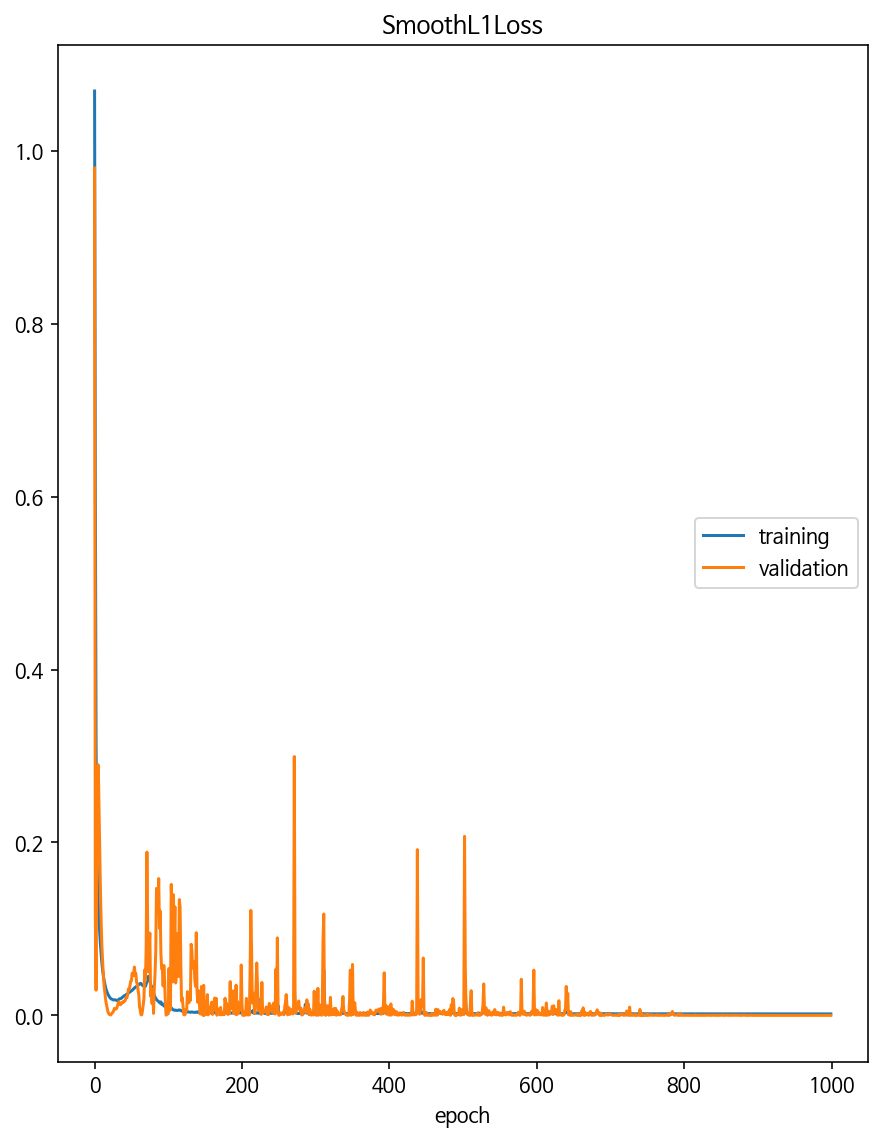

Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:22<00:00, 12.16it/s, SmoothL1Loss=0.00171, MAE=0.033, RegLoss=0.000869, MAE_val=0.00467, SmoothL1Loss_val=7.07e-6]


In [ ]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(squid_prophet_df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [ ]:
squid_future = nprophet.make_future_dataframe(squid_prophet_df, periods=52, n_historic_predictions=300)
squid_forecast = nprophet.predict(squid_future)
squid_forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)
squid_forecast.tail()

ds   y     yhat1  residual1     trend  season_weekly  season_daily
242 2020-11-30 NaN  2.660408        NaN  2.660408  -5.491005e-09 -2.117470e-07
243 2020-12-07 NaN  2.660693        NaN  2.660693  -5.491005e-09 -2.117470e-07
244 2020-12-14 NaN  2.660978        NaN  2.660978  -5.491005e-09 -2.117470e-07
245 2020-12-21 NaN  2.661263        NaN  2.661263  -5.491005e-09 -2.117470e-07
246 2020-12-28 NaN  2.661548        NaN  2.661548  -5.491005e-09 -2.117470e-07

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in squid_prophet_df_val:
  a = a.append(squid_forecast.iloc[squid_forecast.loc[squid_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(squid_val_price, a['yhat1'])

0.261749343587418

#### 최적 하이퍼 파라미터 ver.3

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = [0.005, 0.01, 0.015]


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = [10,20,30] # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = [100, 150, 200] # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [ ]:
# 파라미터별 rmse 저장할 데이터 프레임 생성 
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
# 데이터 프레임 row index 변수 생성
count=0
# 파라미터 조합 반복문 실행
for lr in learning_rate:
  for layer in num_hidden_layers:
    start = timer()
    for changepoint in n_changepoints:

      nprophet = NeuralProphet(
                                yearly_seasonality=False, 
                                weekly_seasonality=True, 
                                daily_seasonality=True,
                                learning_rate=lr, 
                                changepoints_range=changepoints_range, 
                                n_forecasts=n_forecasts,
                                ar_sparsity=ar_sparsity, 
                                n_changepoints=changepoint, 
                                growth='logistic', 
                                seasonality_mode='multiplicative', 
                                trend_reg=trend_reg,
                                num_hidden_layers=layer,
                                seasonality_reg = seasonality_reg)
      
      nprophet.fit(squid_prophet_df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
      #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
      future = nprophet.make_future_dataframe(squid_prophet_df, periods=52, n_historic_predictions=300)
      forecast = nprophet.predict(future)

      a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
      for i in squid_prophet_df_val:
        a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
      a.reset_index(drop=True, inplace = True)
      
      result.loc[count] = lr, layer, changepoint, rmse(squid_val_price, a['yhat1'])
      count += 1
      end = timer()
      print(end-start)

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:54<00:00, 18.22it/s, SmoothL1Loss=0.00185, MAE=0.0363, RegLoss=0.00085, MAE_val=0.00236, SmoothL1Loss_val=4.14e-6]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: 

55.11780806999923


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:38<00:00, 10.20it/s, SmoothL1Loss=0.00177, MAE=0.034, RegLoss=0.000851, MAE_val=0.00697, SmoothL1Loss_val=1.48e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


153.52843731699977


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:01<00:00, 16.37it/s, SmoothL1Loss=0.00176, MAE=0.0352, RegLoss=0.000943, MAE_val=0.0019, SmoothL1Loss_val=1.47e-6]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


214.90827591699963


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:33<00:00, 10.75it/s, SmoothL1Loss=0.00185, MAE=0.037, RegLoss=0.000903, MAE_val=0.0156, SmoothL1Loss_val=8.41e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


93.72798991499894


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:18<00:00, 12.73it/s, SmoothL1Loss=0.00544, MAE=0.0714, RegLoss=0.31, MAE_val=0.0811, SmoothL1Loss_val=0.00178]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


172.5896629179997


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:54<00:00, 18.19it/s, SmoothL1Loss=0.00169, MAE=0.0343, RegLoss=0.000938, MAE_val=0.0157, SmoothL1Loss_val=7.23e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


227.81916368700058


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:14<00:00, 13.44it/s, SmoothL1Loss=0.00178, MAE=0.0345, RegLoss=0.000852, MAE_val=0.0098, SmoothL1Loss_val=3.21e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


74.63600127599966


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:59<00:00, 16.86it/s, SmoothL1Loss=0.00171, MAE=0.0334, RegLoss=0.000871, MAE_val=0.0119, SmoothL1Loss_val=4.17e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


134.23151141400012


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:19<00:00, 12.57it/s, SmoothL1Loss=0.00175, MAE=0.0339, RegLoss=0.000904, MAE_val=0.00474, SmoothL1Loss_val=7.26e-6]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


214.04388364900115


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:21<00:00, 12.20it/s, SmoothL1Loss=0.00179, MAE=0.0338, RegLoss=0.000781, MAE_val=0.00286, SmoothL1Loss_val=2.74e-6]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


82.24424160499984


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s, SmoothL1Loss=0.00532, MAE=0.0712, RegLoss=0.31, MAE_val=0.0963, SmoothL1Loss_val=0.00249]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


171.25924130899875


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:34<00:00, 10.62it/s, SmoothL1Loss=0.0017, MAE=0.0331, RegLoss=0.000892, MAE_val=0.00229, SmoothL1Loss_val=4.02e-6]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


265.8294927759998


Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:27<00:00, 11.40it/s, SmoothL1Loss=0.00173, MAE=0.0329, RegLoss=0.000757, MAE_val=0.0115, SmoothL1Loss_val=3.88e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


87.9937304340001


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:57<00:00, 17.27it/s, SmoothL1Loss=0.00531, MAE=0.0707, RegLoss=0.31, MAE_val=0.0844, SmoothL1Loss_val=0.0019]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


146.1776999499998


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s, SmoothL1Loss=0.00173, MAE=0.0331, RegLoss=0.000888, MAE_val=0.00567, SmoothL1Loss_val=1.36e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


203.740031061001


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:55<00:00, 18.09it/s, SmoothL1Loss=0.00533, MAE=0.0713, RegLoss=0.31, MAE_val=0.0924, SmoothL1Loss_val=0.00229]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


55.53214160300013


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s, SmoothL1Loss=0.00531, MAE=0.0702, RegLoss=0.31, MAE_val=0.0858, SmoothL1Loss_val=0.00198]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


111.91785853700094


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s, SmoothL1Loss=0.00175, MAE=0.0332, RegLoss=0.000833, MAE_val=0.00865, SmoothL1Loss_val=2.26e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


169.46849490500063


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:55<00:00, 18.03it/s, SmoothL1Loss=0.00174, MAE=0.033, RegLoss=0.00072, MAE_val=0.0109, SmoothL1Loss_val=3.53e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


55.72371547300099


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:56<00:00, 17.71it/s, SmoothL1Loss=0.00179, MAE=0.0335, RegLoss=0.000766, MAE_val=0.0104, SmoothL1Loss_val=3.91e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


112.44382305699946


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s, SmoothL1Loss=0.00175, MAE=0.0332, RegLoss=0.000811, MAE_val=0.00516, SmoothL1Loss_val=8.19e-6]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


169.90258820599956


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:55<00:00, 18.04it/s, SmoothL1Loss=0.00176, MAE=0.0331, RegLoss=0.000732, MAE_val=0.00588, SmoothL1Loss_val=1.28e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


55.763365704000535


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s, SmoothL1Loss=0.00176, MAE=0.0333, RegLoss=0.000763, MAE_val=0.00258, SmoothL1Loss_val=4.72e-6]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


112.69237653299933


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:57<00:00, 17.35it/s, SmoothL1Loss=0.00173, MAE=0.0331, RegLoss=0.000849, MAE_val=0.002, SmoothL1Loss_val=2.96e-6]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


170.65219510600036


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:55<00:00, 17.97it/s, SmoothL1Loss=0.00176, MAE=0.0332, RegLoss=0.000739, MAE_val=0.00942, SmoothL1Loss_val=2.66e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


55.93624468000053


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s, SmoothL1Loss=0.00532, MAE=0.0695, RegLoss=0.31, MAE_val=0.0861, SmoothL1Loss_val=0.00199]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


112.99401373500041


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s, SmoothL1Loss=0.00173, MAE=0.033, RegLoss=0.000821, MAE_val=0.00159, SmoothL1Loss_val=1.94e-6]


170.37954931400054


#### 최적 하이퍼파라미터 적용 (10회 실험)

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 150 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [ ]:
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
count = 0
for king in range(10):
  nprophet = NeuralProphet(
                            yearly_seasonality=False, 
                            weekly_seasonality=True, 
                            daily_seasonality=True,
                            learning_rate=learning_rate, 
                            changepoints_range=changepoints_range, 
                            n_forecasts=n_forecasts,
                            ar_sparsity=ar_sparsity, 
                            n_changepoints=n_changepoints, 
                            growth='logistic', 
                            seasonality_mode='multiplicative', 
                            trend_reg=trend_reg,
                            num_hidden_layers=num_hidden_layers,
                            seasonality_reg = seasonality_reg)

  nprophet.fit(squid_prophet_df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
  #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
  future = nprophet.make_future_dataframe(squid_prophet_df, periods=52, n_historic_predictions=300)
  forecast = nprophet.predict(future)
  a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
  for i in squid_prophet_df_val:
    a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
  a.reset_index(drop=True, inplace = True)
  result.loc[count] = learning_rate, num_hidden_layers, n_changepoints, rmse(squid_val_price, a['yhat1'])
  count += 1

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:00<00:00, 16.66it/s, SmoothL1Loss=0.00173, MAE=0.0336, RegLoss=0.00088, MAE_val=0.00478, SmoothL1Loss_val=7.47e-6]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: 

In [ ]:
result.sort_values(by='rmse')

learning_rate  num_hidden_layers  n_changepoints      rmse
7          0.005               20.0           150.0  0.224514
4          0.005               20.0           150.0  0.232862
6          0.005               20.0           150.0  0.236135
9          0.005               20.0           150.0  0.246224
0          0.005               20.0           150.0  0.260887
3          0.005               20.0           150.0  0.287261
8          0.005               20.0           150.0  0.298943
2          0.005               20.0           150.0  0.299102
5          0.005               20.0           150.0  0.313542
1          0.005               20.0           150.0  0.333326

In [ ]:
np.mean(result['rmse'].values)

0.2732795355136019

## 흰다리새우

### 더미 변수 생성

In [ ]:
shrimp_t, shrimp_t_len = datasetting(shrimp_train, "흰다리새우")
shrimp_v, shrimp_v_len = datasetting(shrimp_val, "흰다리새우")

In [ ]:
shrimp_t.head(5)

Unnamed: 0    REG_DATE P_TYPE  ... WEIGHT(KG) TOTAL_PRICE       temp
0          0  2015-12-28    수산물  ...    17280.0         0.0  26.999450
1          1  2015-12-28    수산물  ...    21360.0         0.0  27.652058
2          2  2015-12-28    수산물  ...     8718.0     48993.0  28.405743
3          3  2015-12-28    수산물  ...      995.0     14147.0  26.808283
4          4  2015-12-28    수산물  ...      325.0         0.0  29.121342

[5 rows x 17 columns]

In [ ]:
p_type = "P_IMPORT_TYPE"
shrimp_import_type_t = data_encoding(shrimp_t, p_type)

In [ ]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(shrimp_t['CTRY_1']))+list(set(shrimp_t['CTRY_2'])))
ctry_2 = set(list(set(shrimp_v['CTRY_1']))+list(set(shrimp_v['CTRY_2'])))
con = list(ctry_1) + list(ctry_2)
ctry_list = list(set(con))

In [ ]:
shrimp_dummy = data_frame(shrimp_t, ctry_list, shrimp_import_type_t)
display(shrimp_dummy.head(10))
print(shrimp_dummy.shape)

country_말레이시아  country_베트남  country_사우디아라비아  ...    weight      temp      price
0            0.0          0.0              2.0  ...  0.052170  0.620291   6.019444
1            0.0          0.0              0.0  ...  0.064496  0.667105   8.281805
2            2.0          0.0              0.0  ...  0.026306  0.721168   6.171628
3            0.0          2.0              0.0  ...  0.002976  0.606578  12.903215
4            0.0          0.0              0.0  ...  0.000952  0.772500   9.125593
5            0.0          2.0              0.0  ...  0.013966  0.606578  15.684558
6            0.0          2.0              0.0  ...  0.034831  0.606578   6.477169
7            0.0          2.0              0.0  ...  0.083014  0.606578   7.422954
8            0.0          2.0              0.0  ...  0.089243  0.606578   8.401501
9            0.0          0.0              2.0  ...  0.052170  0.632953   5.700000

[10 rows x 21 columns]

(1613, 21)


In [ ]:
shrimp_dummy_val = data_frame(shrimp_v, ctry_list, shrimp_import_type_t)
display(shrimp_dummy_val.head(10))
print(shrimp_dummy_val.shape)

country_말레이시아  country_베트남  country_사우디아라비아  ...    weight      temp      price
0            0.0          0.0              0.0  ...  0.047756  0.743965   8.056061
1            0.0          2.0              0.0  ...  0.024206  0.557250   8.013686
2            0.0          2.0              0.0  ...  0.070163  0.557250  11.186233
3            0.0          0.0              0.0  ...  0.138866  0.607054   7.612483
4            0.0          2.0              0.0  ...  0.162725  0.557250   7.372513
5            0.0          2.0              0.0  ...  0.497047  0.557250   8.250657
6            0.0          0.0              0.0  ...  0.046443  0.699294  12.698082
7            0.0          2.0              0.0  ...  0.032699  0.579255   7.655372
8            2.0          0.0              0.0  ...  0.131222  0.687656   6.773774
9            0.0          2.0              0.0  ...  0.262406  0.579255   7.310366

[10 rows x 21 columns]

(287, 21)


In [ ]:
## 수입목적 고려하도록 변수 재설정
shrimp_dummy = p_purpose(shrimp_dummy, shrimp_t)
shrimp_dummy_val = p_purpose(shrimp_dummy_val, shrimp_v)

In [ ]:
shrimp_x = np.array(shrimp_dummy.iloc[:,:-1])
shrimp_y = np.array(shrimp_dummy.iloc[:,-1])
shrimp_y = shrimp_y.reshape(-1)

In [ ]:
shrimp_val_x = np.array(shrimp_dummy_val.iloc[:,:-1])
shrimp_val_y = np.array(shrimp_dummy_val.iloc[:,-1])
shrimp_val_y = shrimp_val_y.reshape(-1)

In [ ]:
## 새우는 temp를 빼 줌
shrimp_dummy = shrimp_dummy.drop(['temp'],axis=1)
shrimp_dummy_val = shrimp_dummy_val.drop(['temp'], axis=1)

In [ ]:
shrimp_x.shape, shrimp_y.shape, shrimp_val_x.shape, shrimp_val_y.shape

((1613, 22), (1613,), (287, 22), (287,))

### Attention block을 이용한 가중평균

In [ ]:
attention_layers = ModelTrunk(num_layers=10)

In [ ]:
shrimp_train_weight, shrimp_train_price = make_weight(shrimp_x, shrimp_y, shrimp_t_len)
shrimp_val_weight, shrimp_val_price = make_weight(shrimp_val_x, shrimp_val_y, shrimp_v_len)

In [ ]:
shrimp_train_price = make_new_price(shrimp_train_weight, shrimp_train_price)
shrimp_val_price = make_new_price(shrimp_val_weight, shrimp_val_price)

In [ ]:
shrimp_t['REG_DATE'] = pd.to_datetime(shrimp_t['REG_DATE'])
shrimp_v['REG_DATE'] = pd.to_datetime(shrimp_v['REG_DATE'])

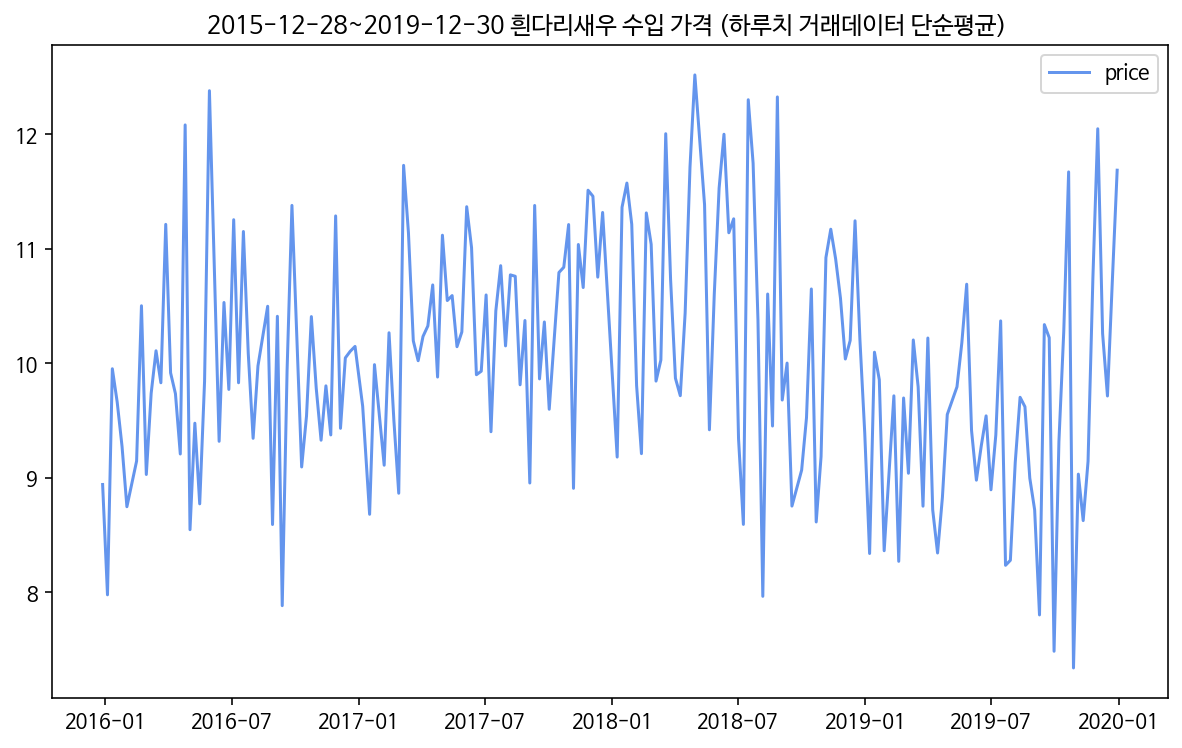

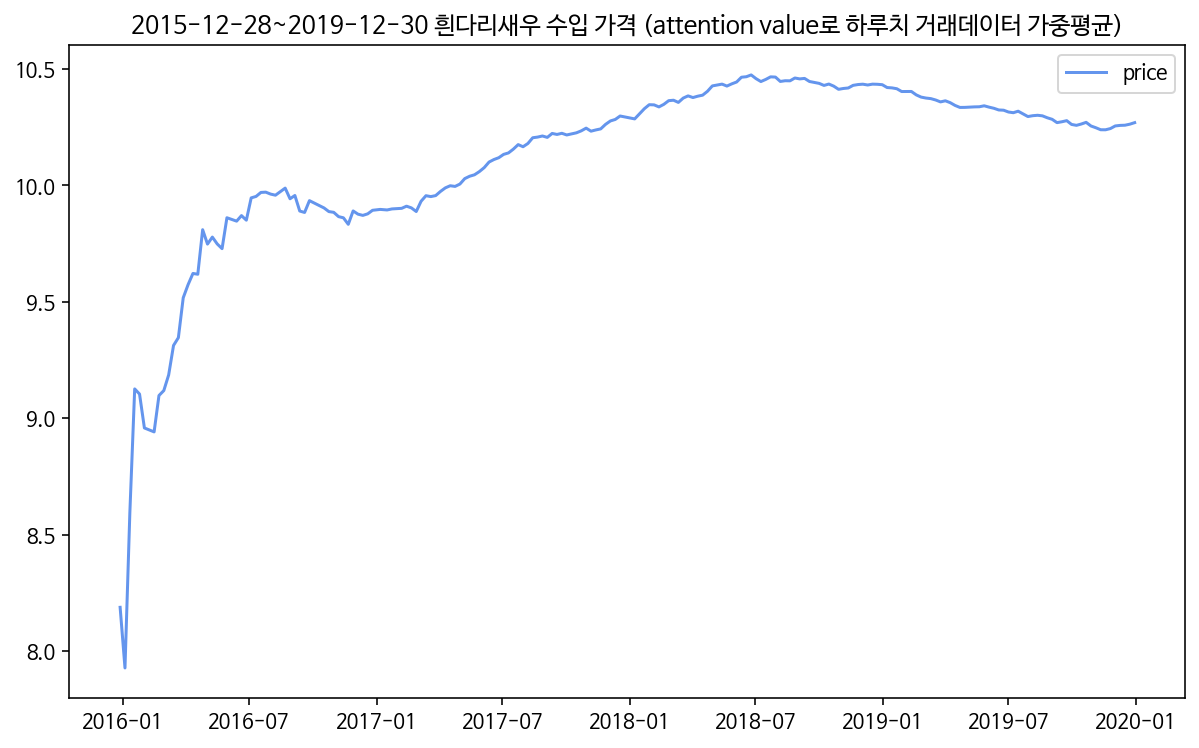

In [ ]:
'''
num_layer = 10
'''

plt.figure(figsize=(10, 6))

plt.plot(shrimp_t['P_PRICE'].groupby(shrimp_t['REG_DATE']).mean(), color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2015-12-28~2019-12-30 흰다리새우 수입 가격 (하루치 거래데이터 단순평균) ")
plt.show()


plt.figure(figsize=(10, 6))

x = shrimp_t['REG_DATE'].unique()
y = shrimp_train_price
plt.plot(x,y, color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2015-12-28~2019-12-30 흰다리새우 수입 가격 (attention value로 하루치 거래데이터 가중평균)")
plt.show()

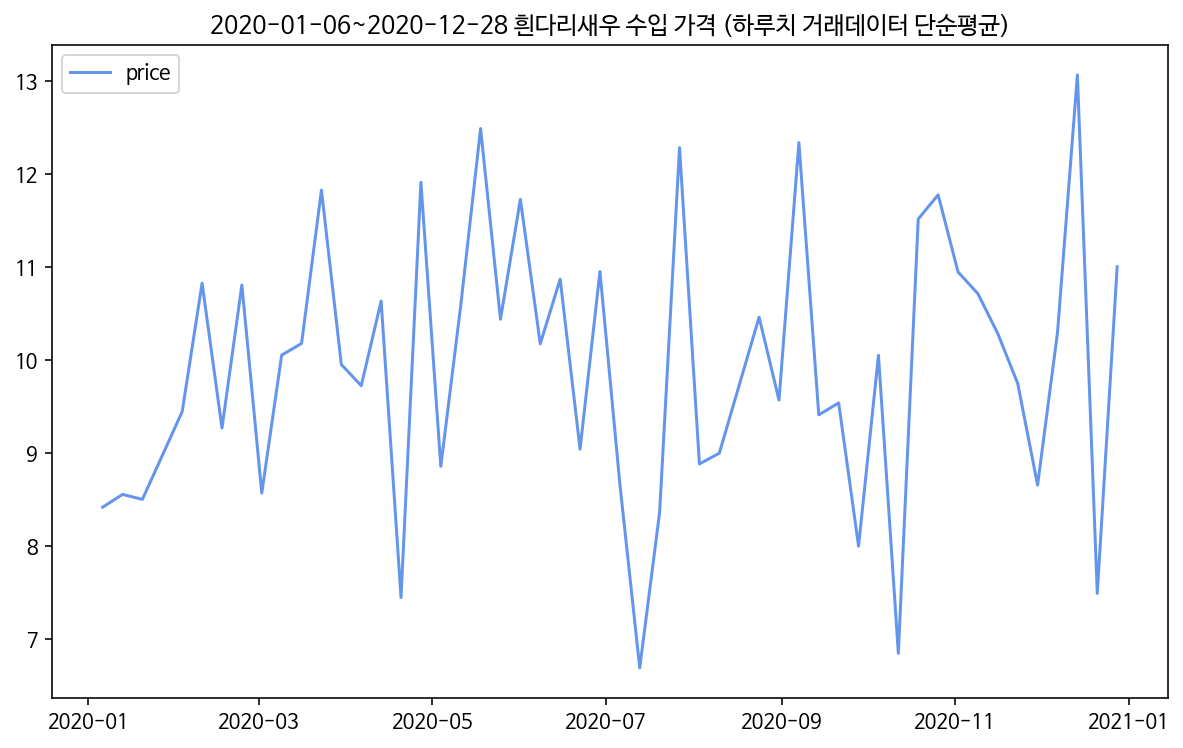

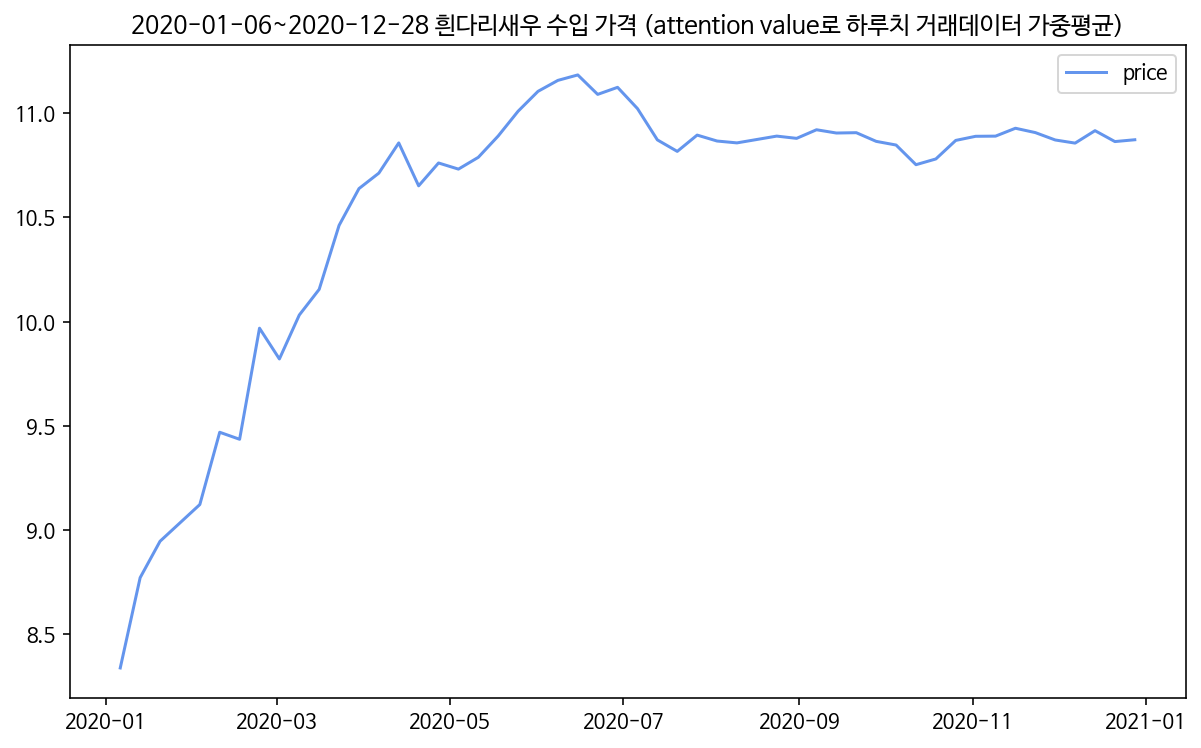

In [ ]:
'''
num_layer = 10
'''
plt.figure(figsize=(10, 6))

plt.plot(shrimp_v['P_PRICE'].groupby(shrimp_v['REG_DATE']).mean(), color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2020-01-06~2020-12-28 흰다리새우 수입 가격 (하루치 거래데이터 단순평균)")
plt.show()


plt.figure(figsize=(10, 6))

x = shrimp_v['REG_DATE'].unique()
y = shrimp_val_price
plt.plot(x,y, color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2020-01-06~2020-12-28 흰다리새우 수입 가격 (attention value로 하루치 거래데이터 가중평균)")
plt.show()

### ARIMA 비교

In [ ]:
shrimp_trn_lst = np.array([item for item in shrimp_train_price if item > 0])

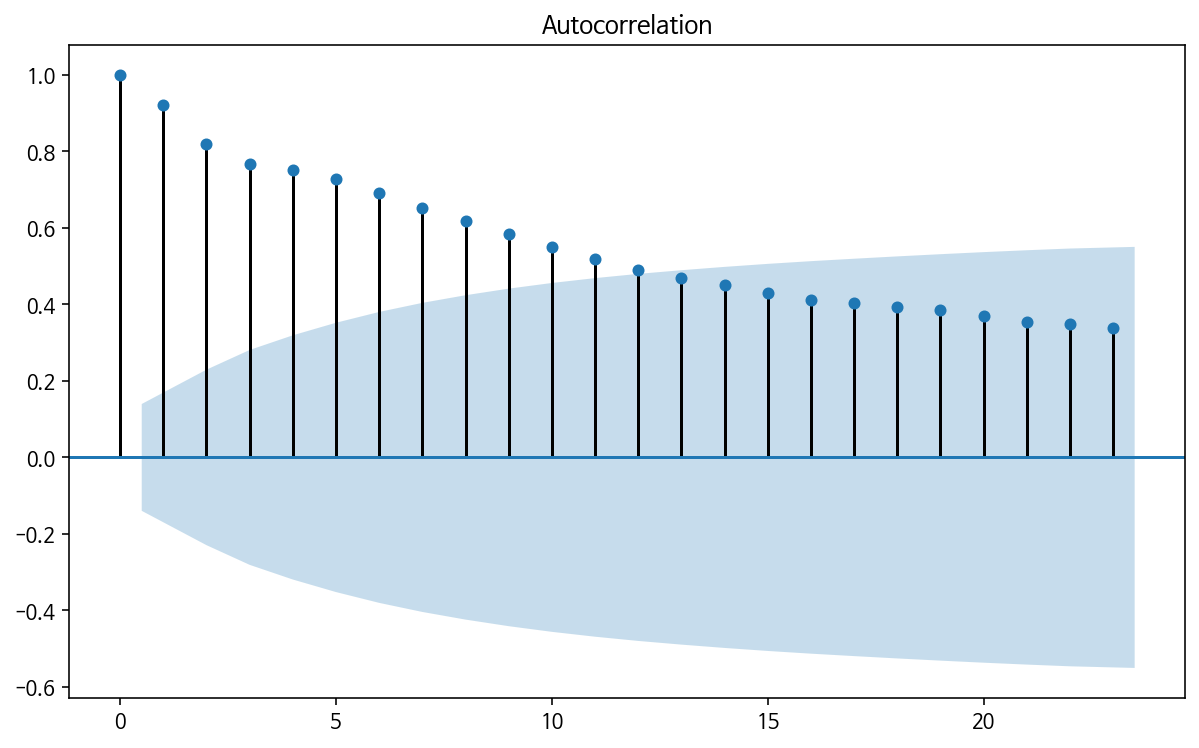

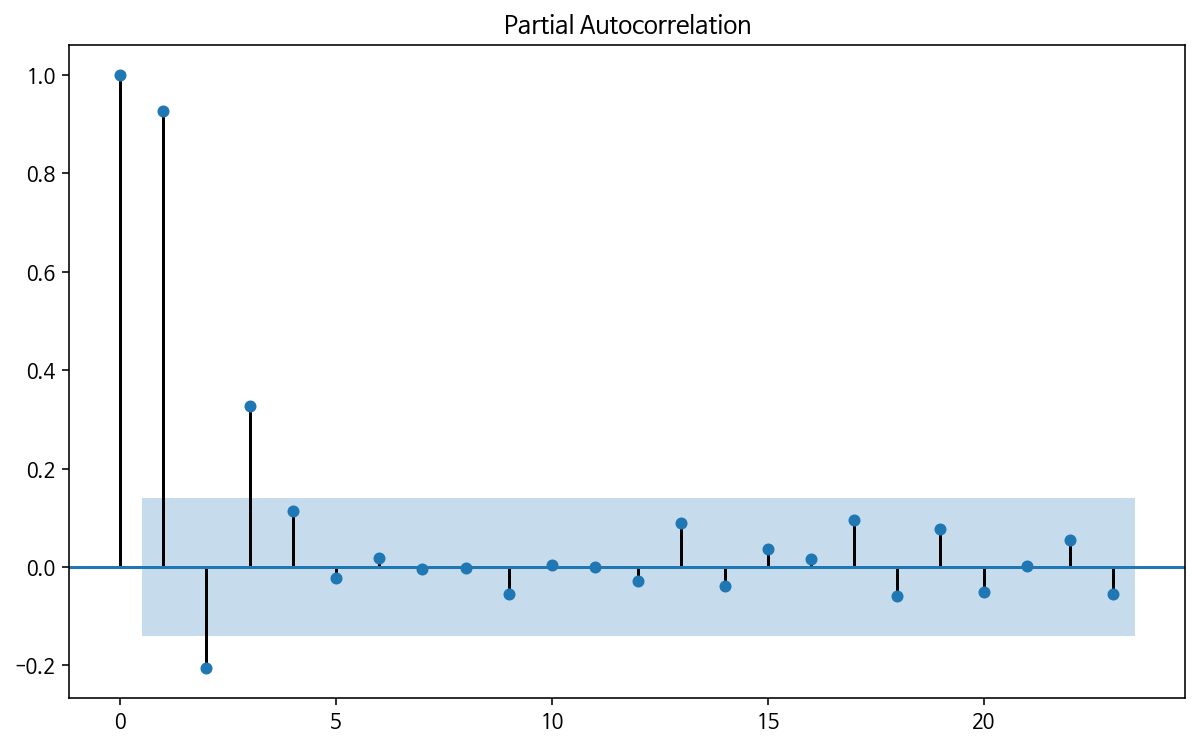

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rc("figure", figsize=(10,6))
plot_acf(np.array(shrimp_train_price))
plot_pacf(np.array(shrimp_train_price))
plt.show()

In [ ]:
shrimp_ts_train = np.array(shrimp_train_price)

In [ ]:
model = ARIMA(shrimp_trn_lst, order=(0,2,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  195
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 242.316
Method:                       css-mle   S.D. of innovations              0.069
Date:                Wed, 15 Sep 2021   AIC                           -478.633
Time:                        05:49:29   BIC                           -468.814
Sample:                             2   HQIC                          -474.657
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -1.319      0.189      -0.001       0.000
ma.L1.D2.y    -0.9423      0.031    -30.500      0.000      -1.003      -0.882
                                    Roots           

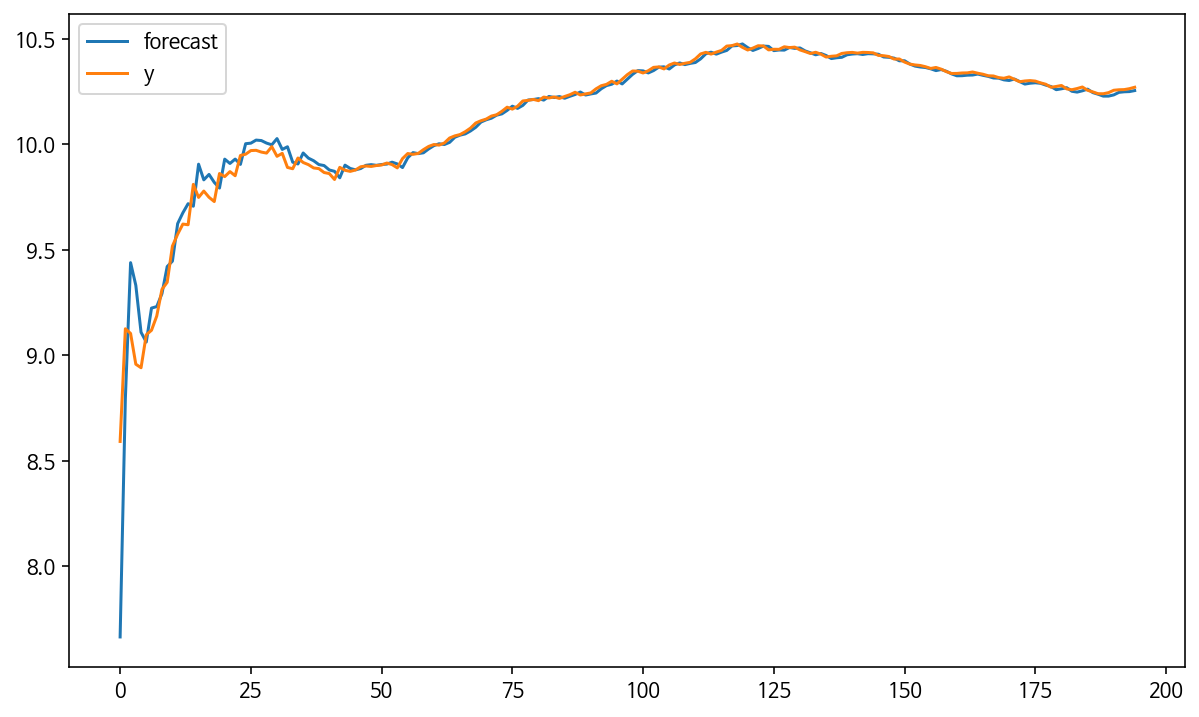

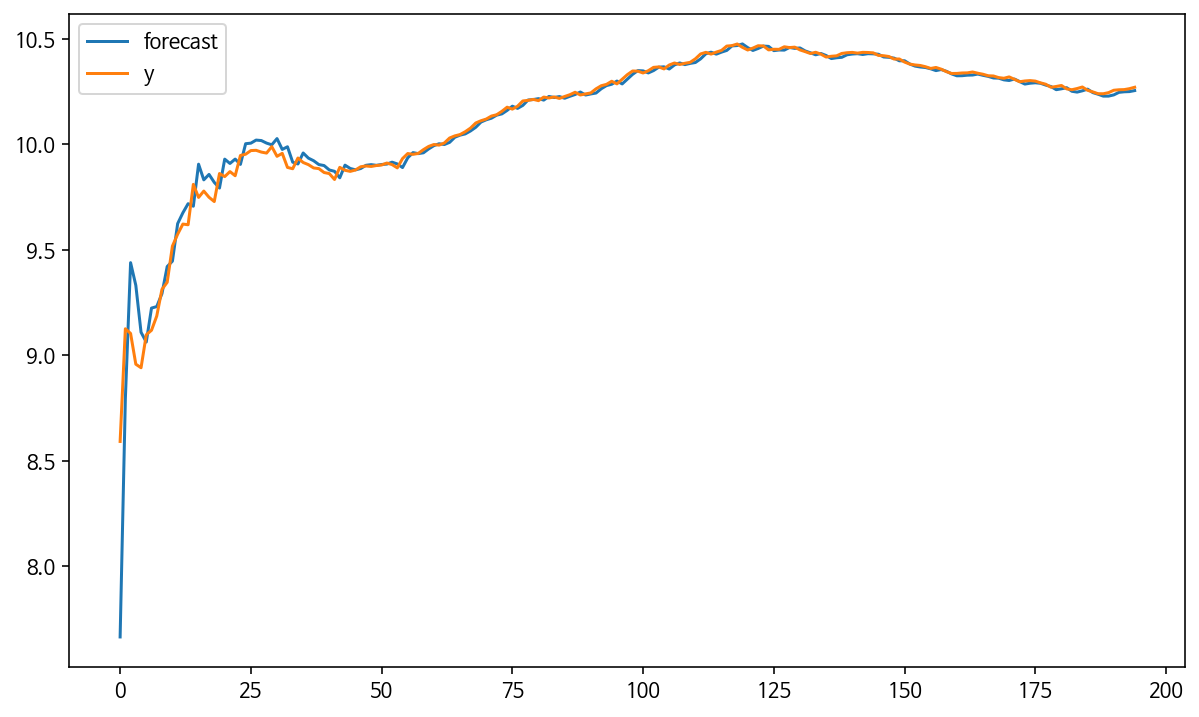

In [ ]:
plt.rc("figure", figsize=(10,6))
model_fit.plot_predict()

In [ ]:
fore = model_fit.forecast(steps=52)

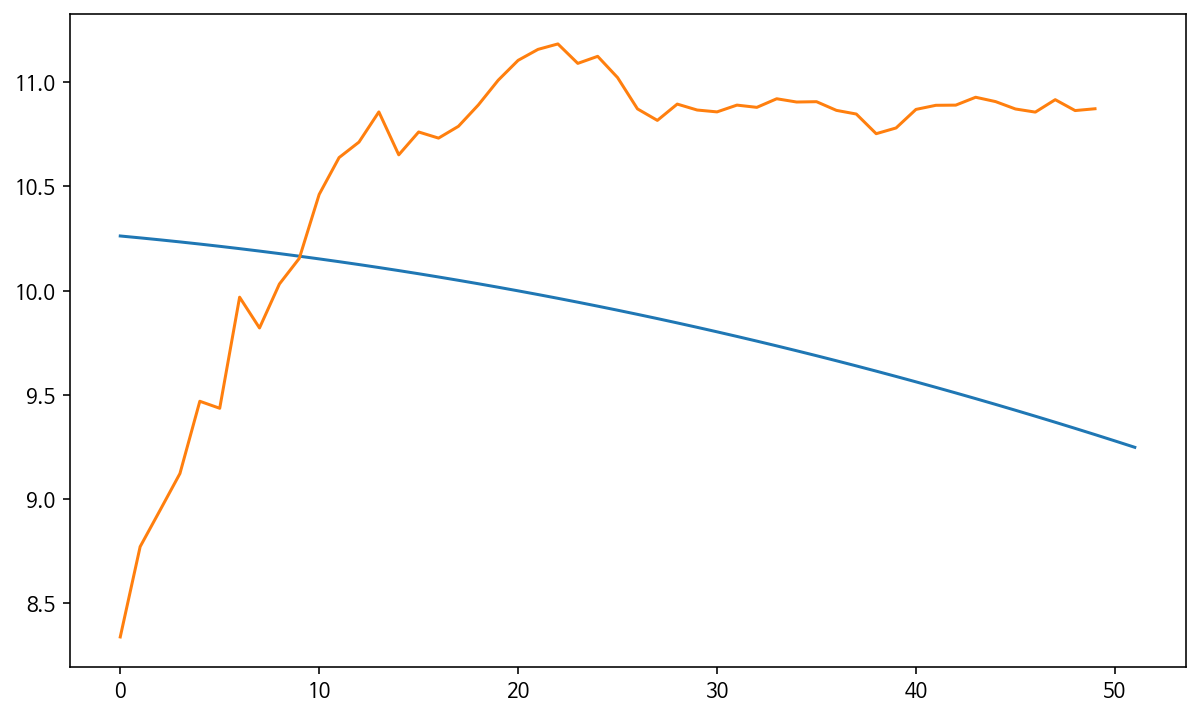

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(fore[0])
plt.plot(shrimp_val_price)

### Facebook Prophet

In [ ]:
## 프로펫에 피팅하기 위해서 dataframe 형태 수정
shrimp_prophet_df = pd.DataFrame(columns=['ds','y'])
shrimp_prophet_df['ds'] = list(Counter(shrimp_train['REG_DATE']).keys())
shrimp_prophet_df['y'] = shrimp_ts_train

In [ ]:
m = Prophet(changepoint_prior_scale=0.3)
m.fit(shrimp_prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

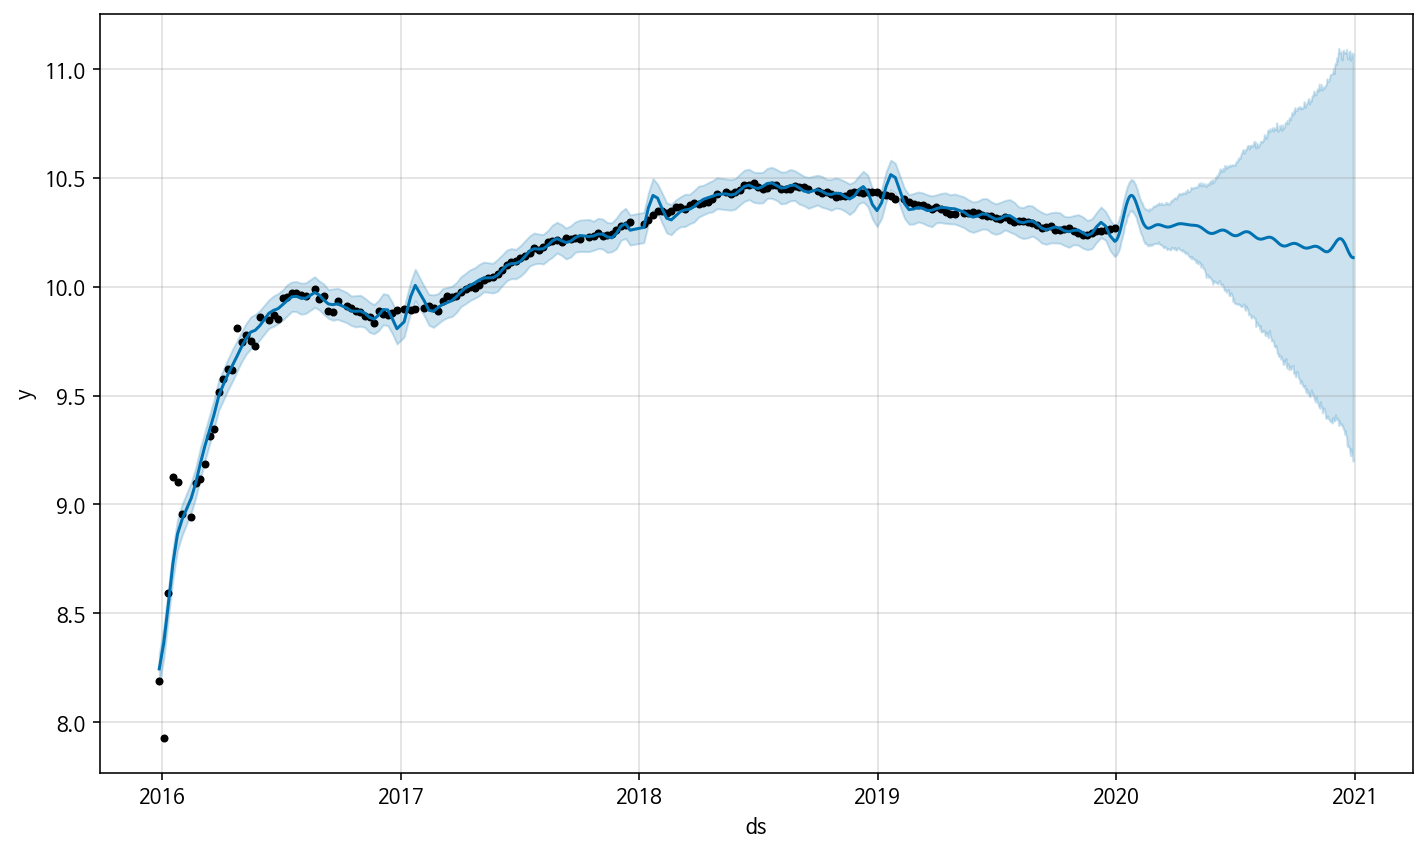

In [ ]:
plt.rc("figure", figsize=(10,6))
fig1 = m.plot(forecast)

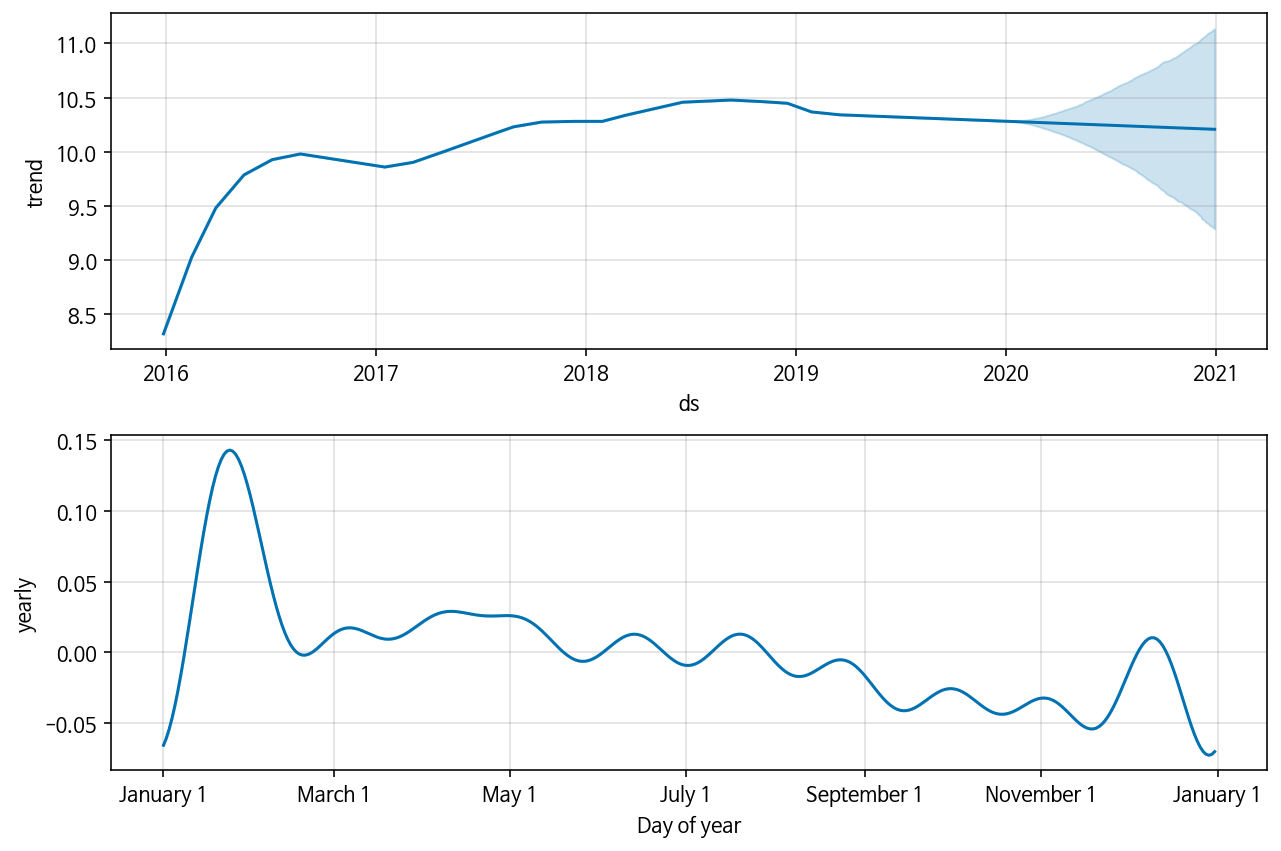

In [ ]:
plt.rc("figure", figsize=(10,6))
fig2 = m.plot_components(forecast)

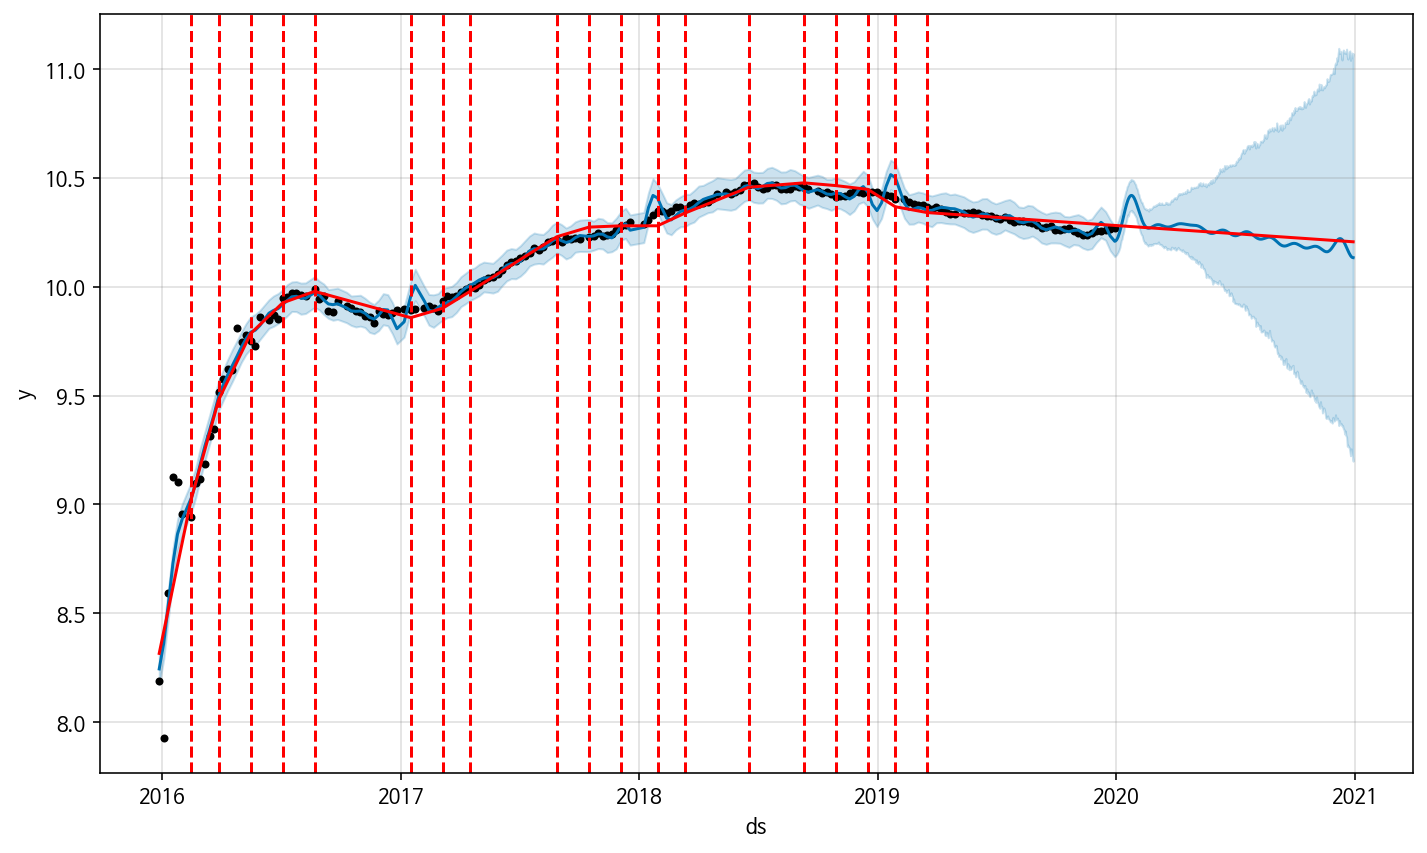

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

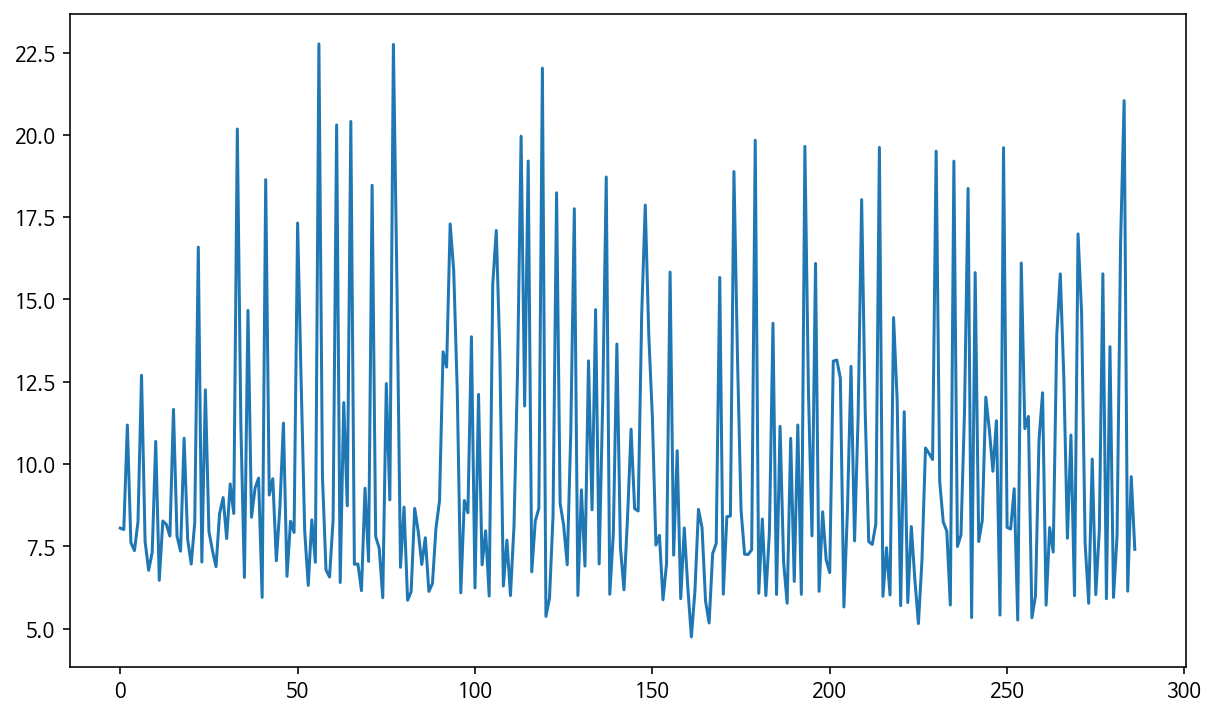

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(shrimp_val_y)

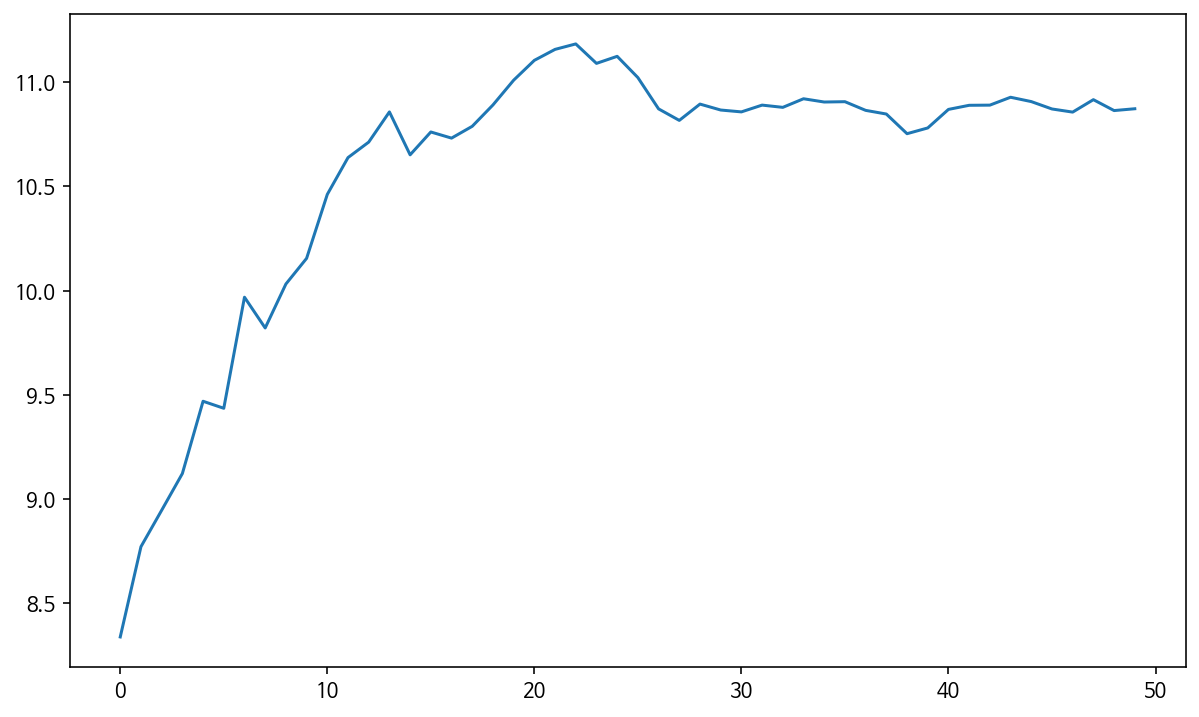

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(shrimp_val_price)

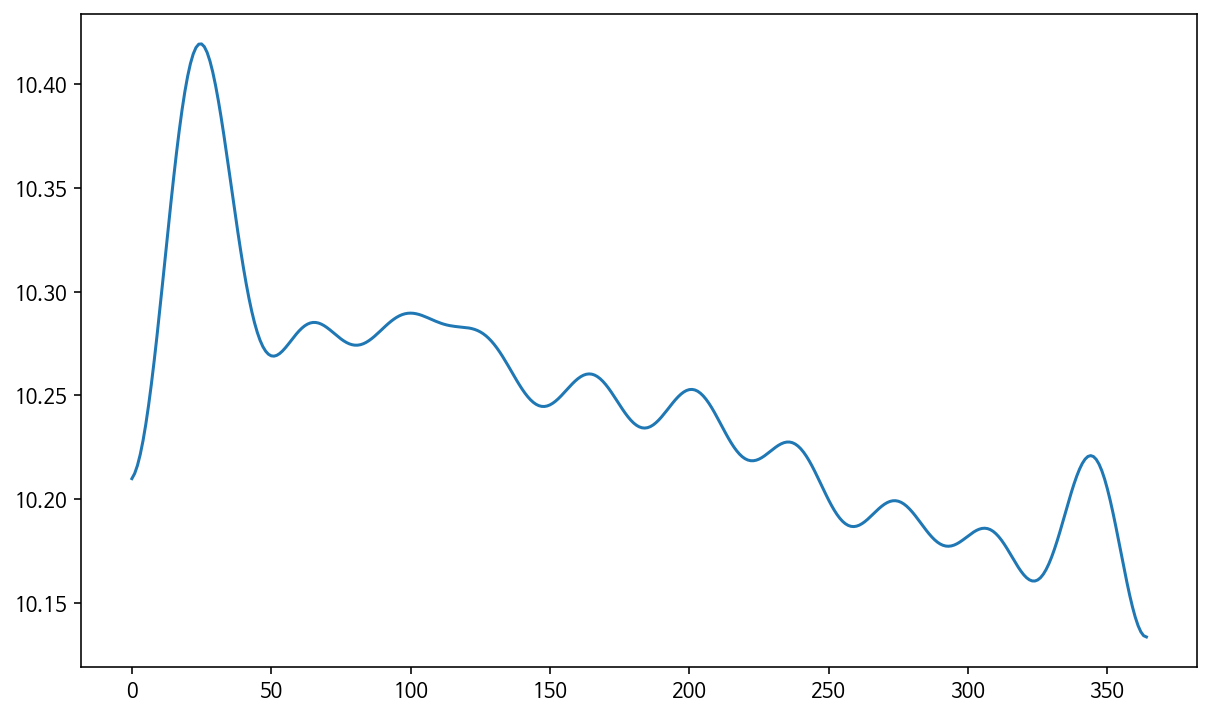

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(list(forecast[-365:]['yhat']))

In [ ]:
forecast.head(10)

ds     trend  ...  multiplicative_terms_upper      yhat
0 2015-12-28  8.315744  ...                         0.0  8.244389
1 2016-01-04  8.416938  ...                         0.0  8.364562
2 2016-01-11  8.518133  ...                         0.0  8.542877
3 2016-01-18  8.619327  ...                         0.0  8.729153
4 2016-01-25  8.720521  ...                         0.0  8.863582
5 2016-02-01  8.821715  ...                         0.0  8.931038
6 2016-02-15  9.024103  ...                         0.0  9.028685
7 2016-02-22  9.100113  ...                         0.0  9.099771
8 2016-02-29  9.176123  ...                         0.0  9.188156
9 2016-03-07  9.252134  ...                         0.0  9.269363

[10 rows x 16 columns]

### Neural Prophet

In [ ]:
# 평가지표 RMSE 함수
def rmse(y: List, yhat:List)->float:
  # y값의 갯수
  n = len(y)
  mse = 0
  for i in range(n):
    # 실제값에서 예측값 뺀것의 제곱
    mse += (y[i] - yhat[i])**2
  rmse = (mse/n)**0.5
  return rmse

In [ ]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 
epochs = 1000

#### Neural Prophet - normal

In [ ]:
## 모델 피팅하기 위해서 수정된 dataframe 사용
shrimp_prophet_df.shape

(197, 2)

In [ ]:
# 예측 기간 데이터셋 생성
shrimp_prophet_df_val = list(shrimp_v['REG_DATE'].unique())
shrimp_prophet_future = pd.DataFrame(shrimp_prophet_df_val, columns=['ds'])
shrimp_prophet_future['y'] = None

In [ ]:
# 모델 학습
m = NeuralProphet()
metrics = m.fit(shrimp_prophet_df, freq=freq, epochs=epochs)

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-03
INFO:nprophet:learning rate range test found optimal lr: 5.34E-03
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s, SmoothL1Loss=0.00033, MAE=0.0428, RegLoss=0]


In [ ]:
# train 데이터의 마지막일 기준으로, 일주일 간격 * 70 의 테스트데이터 생성
shrimp_future = m.make_future_dataframe(shrimp_prophet_df, periods=70)
shrimp_forecast = m.predict(shrimp_future)

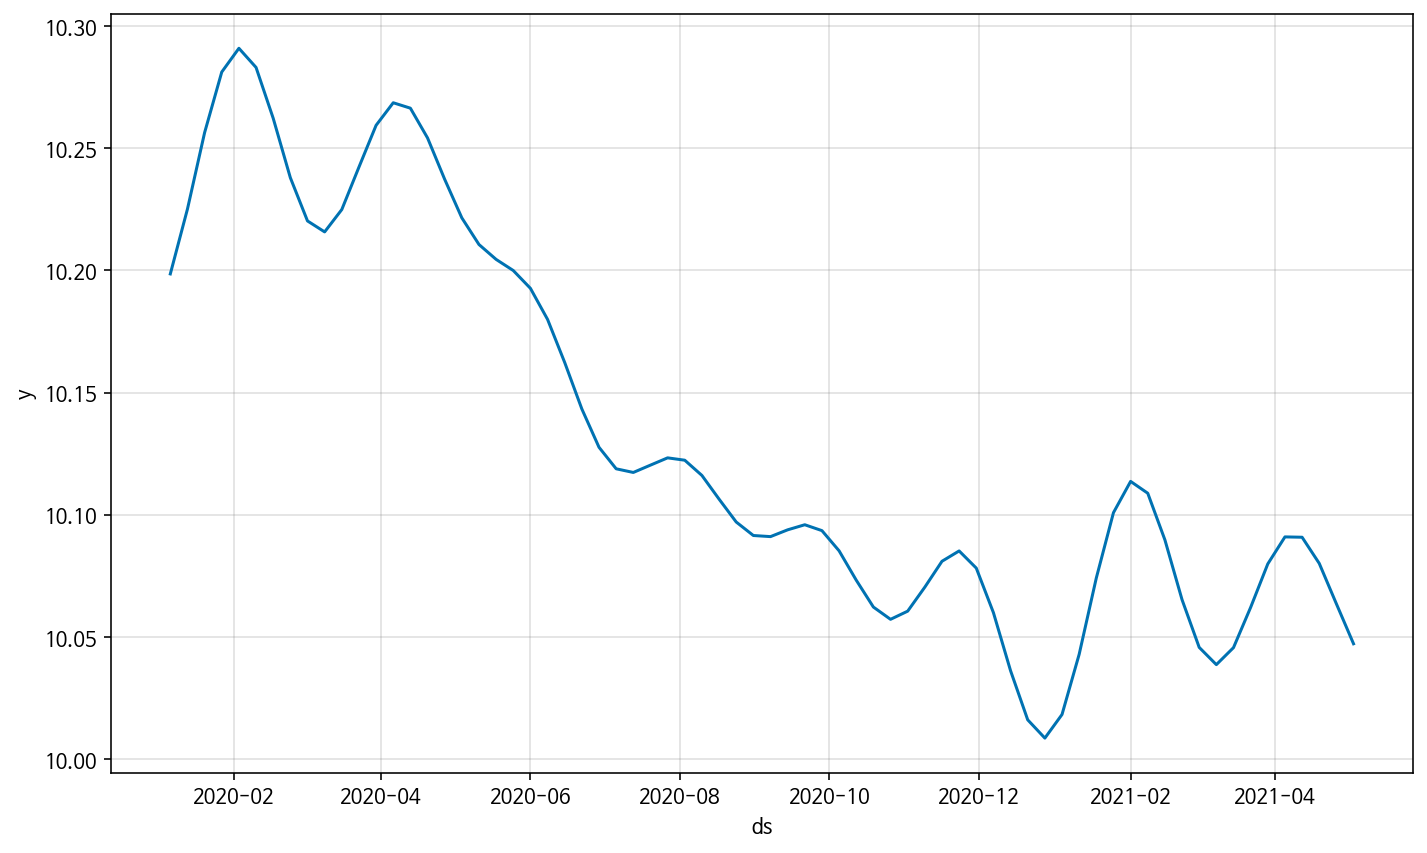

In [ ]:
shrimp_forecasts_plot = m.plot(shrimp_forecast)

In [ ]:
# validation 기간에 맞는 예측 데이터 프레임 구성
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in shrimp_prophet_df_val:
  a = a.append(shrimp_forecast.iloc[shrimp_forecast.loc[shrimp_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(shrimp_val_price, a['yhat1'])

0.821265205230408

#### Neural Prophet - Trend

In [ ]:
m = NeuralProphet(
    n_changepoints=100,
    #trend_smoothness=2,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs =epochs
)
metrics = m.fit(shrimp_prophet_df, freq=freq)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:48<00:00, 20.78it/s, SmoothL1Loss=0.00015, MAE=0.017, RegLoss=0]


In [ ]:
shrimp_future = m.make_future_dataframe(shrimp_prophet_df, periods=70, n_historic_predictions=len(shrimp_prophet_df))
shrimp_forecast = m.predict(shrimp_future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in shrimp_prophet_df_val:
  a = a.append(shrimp_forecast.iloc[shrimp_forecast.loc[shrimp_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(shrimp_val_price, a['yhat1'])

0.8090606007324559

#### Nueral Prophet - Seasonality

In [ ]:
m = NeuralProphet(
    n_changepoints=200,
    yearly_seasonality=15,
    weekly_seasonality=3,
    seasonality_reg=30,
    num_hidden_layers=20,
)
metrics = m.fit(shrimp_prophet_df, freq=freq)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 162
INFO:nprophet.config:Auto-set epochs to 162


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-05
INFO:nprophet:learning rate range test found optimal lr: 1.52E-05
Epoch[162/162]: 100%|██████████| 162/162 [00:15<00:00, 10.47it/s, SmoothL1Loss=0.343, MAE=2.13, RegLoss=2.03]


In [ ]:
shrimp_future = m.make_future_dataframe(shrimp_prophet_df, periods=70, n_historic_predictions=len(shrimp_prophet_df))
shrimp_forecast = m.predict(shrimp_future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in shrimp_prophet_df_val:
  a = a.append(shrimp_forecast.iloc[shrimp_forecast.loc[shrimp_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(shrimp_val_price, a['yhat1'])

2.7063444315582905

#### 최적 하이퍼 파라미터

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

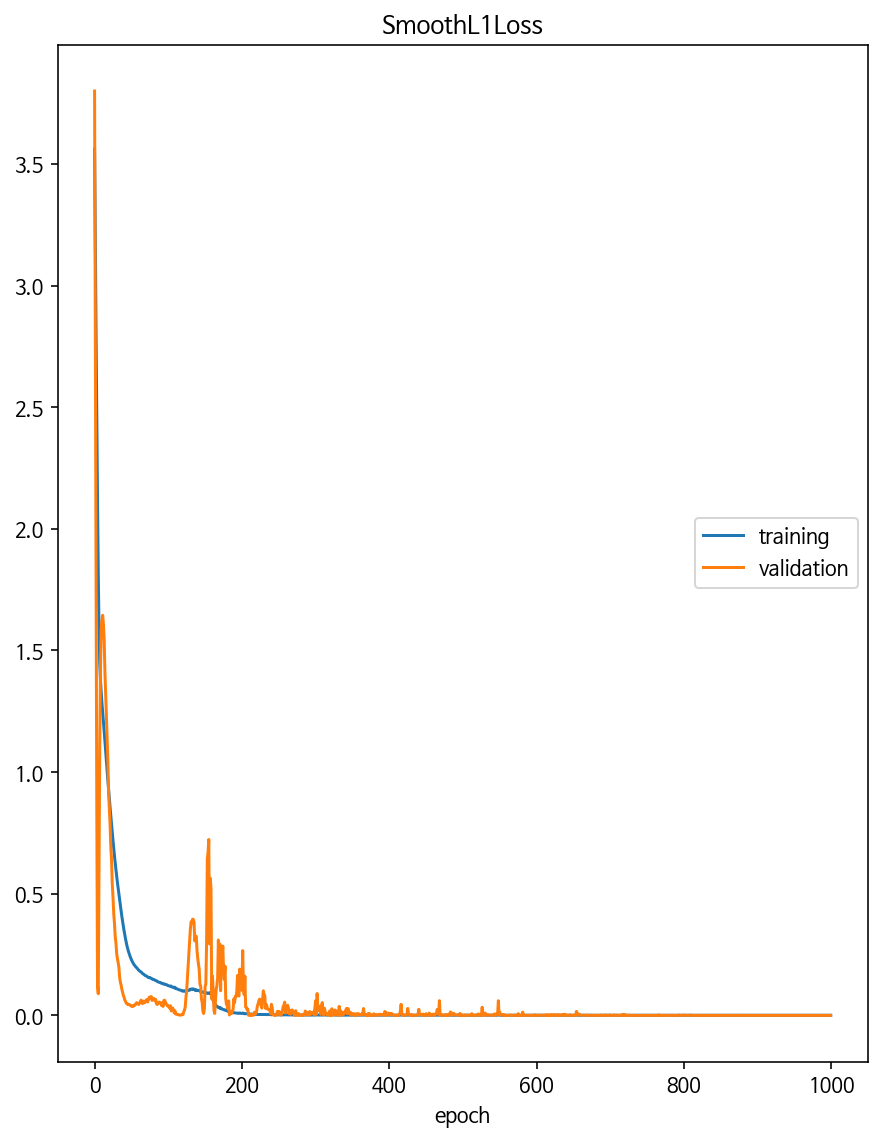

Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:07<00:00, 14.92it/s, SmoothL1Loss=0.000425, MAE=0.0338, RegLoss=0.000508, MAE_val=0.017, SmoothL1Loss_val=3.32e-5]


In [ ]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(shrimp_prophet_df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [ ]:
shrimp_future = nprophet.make_future_dataframe(shrimp_prophet_df, periods=52, n_historic_predictions=300)
shrimp_forecast = nprophet.predict(shrimp_future)
shrimp_forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)
shrimp_forecast.tail()

ds   y     yhat1  residual1     trend  season_weekly  season_daily
244 2020-11-30 NaN  9.977851        NaN  9.977852  -3.002740e-08 -1.180660e-07
245 2020-12-07 NaN  9.973111        NaN  9.973112  -3.002740e-08 -1.180660e-07
246 2020-12-14 NaN  9.968371        NaN  9.968371  -3.002740e-08 -1.180660e-07
247 2020-12-21 NaN  9.963631        NaN  9.963632  -3.002740e-08 -1.180660e-07
248 2020-12-28 NaN  9.958891        NaN  9.958892  -3.002740e-08 -1.180660e-07

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in shrimp_prophet_df_val:
  a = a.append(shrimp_forecast.iloc[shrimp_forecast.loc[shrimp_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(shrimp_val_price, a['yhat1'])

0.8657278778295215

#### 최적 하이퍼 파라미터 ver.2

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.01


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

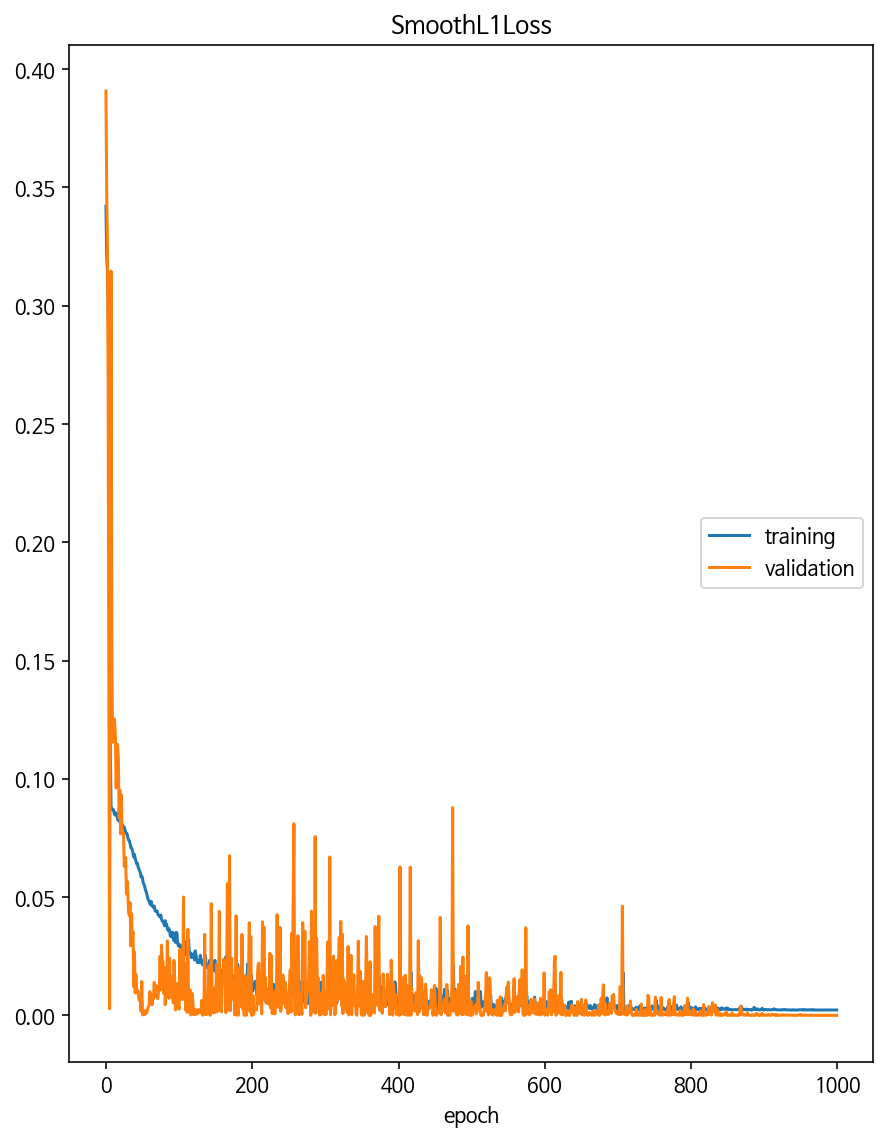

Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s, SmoothL1Loss=0.00229, MAE=0.104, RegLoss=0.312, MAE_val=0.0164, SmoothL1Loss_val=1.63e-5]


In [ ]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(shrimp_prophet_df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [ ]:
shrimp_future = nprophet.make_future_dataframe(shrimp_prophet_df, periods=52, n_historic_predictions=300)
shrimp_forecast = nprophet.predict(shrimp_future)
shrimp_forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)
shrimp_forecast.tail()

ds   y      yhat1  ...      trend  season_weekly  season_daily
244 2020-11-30 NaN  10.066654  ... -66.097763      -0.000109     -1.033181
245 2020-12-07 NaN  10.063075  ... -65.990280      -0.000109     -1.033181
246 2020-12-14 NaN  10.059496  ... -65.882790      -0.000109     -1.033181
247 2020-12-21 NaN  10.055917  ... -65.775307      -0.000109     -1.033181
248 2020-12-28 NaN  10.052344  ... -65.667824      -0.000109     -1.033181

[5 rows x 7 columns]

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in shrimp_prophet_df_val:
  a = a.append(shrimp_forecast.iloc[shrimp_forecast.loc[shrimp_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(shrimp_val_price, a['yhat1'])

0.8192814887997099

#### 최적 하이퍼 파라미터 ver.3

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = [0.005, 0.01, 0.015]


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = [10,20,30] # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = [100, 150, 200] # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [ ]:
# 파라미터별 rmse 저장할 데이터 프레임 생성 
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
# 데이터 프레임 row index 변수 생성
count=0
# 파라미터 조합 반복문 실행
for lr in learning_rate:
  for layer in num_hidden_layers:
    start = timer()
    for changepoint in n_changepoints:

      nprophet = NeuralProphet(
                                yearly_seasonality=False, 
                                weekly_seasonality=True, 
                                daily_seasonality=True,
                                learning_rate=lr, 
                                changepoints_range=changepoints_range, 
                                n_forecasts=n_forecasts,
                                ar_sparsity=ar_sparsity, 
                                n_changepoints=changepoint, 
                                growth='logistic', 
                                seasonality_mode='multiplicative', 
                                trend_reg=trend_reg,
                                num_hidden_layers=layer,
                                seasonality_reg = seasonality_reg)
      
      nprophet.fit(shrimp_prophet_df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
      #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
      future = nprophet.make_future_dataframe(shrimp_prophet_df, periods=52, n_historic_predictions=300)
      forecast = nprophet.predict(future)

      a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
      for i in shrimp_prophet_df_val:
        a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
      a.reset_index(drop=True, inplace = True)
      
      result.loc[count] = lr, layer, changepoint, rmse(shrimp_val_price, a['yhat1'])
      count += 1
      end = timer()
      print(end-start)

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
Epoch[847/1000]:  85%|████████▍ | 846/1000 [00:46<00:08, 18.43it/s, SmoothL1Loss=0.00188, MAE=0.0391, RegLoss=0.00114, MAE_val=0.0237, SmoothL1Loss_val=0.000144]

#### 최적 하이퍼파라미터 적용 (10회 실험)

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 30 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [ ]:
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
count = 0
for king in range(10):
  nprophet = NeuralProphet(
                            yearly_seasonality=False, 
                            weekly_seasonality=True, 
                            daily_seasonality=True,
                            learning_rate=learning_rate, 
                            changepoints_range=changepoints_range, 
                            n_forecasts=n_forecasts,
                            ar_sparsity=ar_sparsity, 
                            n_changepoints=n_changepoints, 
                            growth='logistic', 
                            seasonality_mode='multiplicative', 
                            trend_reg=trend_reg,
                            num_hidden_layers=num_hidden_layers,
                            seasonality_reg = seasonality_reg)

  nprophet.fit(shrimp_prophet_df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
  #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
  future = nprophet.make_future_dataframe(shrimp_prophet_df, periods=52, n_historic_predictions=300)
  forecast = nprophet.predict(future)
  a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
  for i in shrimp_prophet_df_val:
    a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
  a.reset_index(drop=True, inplace = True)
  result.loc[count] = learning_rate, num_hidden_layers, n_changepoints, rmse(shrimp_val_price, a['yhat1'])
  count += 1

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:05<00:00, 15.37it/s, SmoothL1Loss=0.000461, MAE=0.0365, RegLoss=0.000559, MAE_val=0.0131, SmoothL1Loss_val=1.52e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__:

In [ ]:
result.sort_values(by='rmse')

learning_rate  num_hidden_layers  n_changepoints      rmse
5          0.005               20.0           150.0  0.817956
1          0.005               20.0           150.0  0.819332
6          0.005               20.0           150.0  0.821534
0          0.005               20.0           150.0  0.832604
9          0.005               20.0           150.0  0.834528
8          0.005               20.0           150.0  0.842359
7          0.005               20.0           150.0  0.848742
2          0.005               20.0           150.0  0.850122
4          0.005               20.0           150.0  0.855615
3          0.005               20.0           150.0  0.873145

In [ ]:
np.mean(result['rmse'].values)

0.8395937195313244

## 연어

### 더미 변수 생성

In [ ]:
salmon_t, salmon_t_len = datasetting(salmon_train, "연어")
salmon_v, salmon_v_len = datasetting(salmon_val, "연어")

In [ ]:
salmon_t.head(5)

Unnamed: 0    REG_DATE P_TYPE  ... WEIGHT(KG) TOTAL_PRICE      temp
0          0  2015-12-28    수산물  ...   151136.0   1318938.0  8.332377
1          1  2016-01-04    수산물  ...   136245.0   1219485.0  7.995453
2          2  2016-01-04    수산물  ...   136245.0   1219485.0  7.995453
3          3  2016-01-11    수산물  ...   187044.0   1622635.0  6.814753
4          4  2016-01-11    수산물  ...   187044.0   1622635.0  6.814753

[5 rows x 17 columns]

In [ ]:
p_type = "P_IMPORT_TYPE"
salmon_import_type_t = data_encoding(salmon_t, p_type)

In [ ]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(salmon_t['CTRY_1']))+list(set(salmon_t['CTRY_2'])))
ctry_2 = set(list(set(salmon_v['CTRY_1']))+list(set(salmon_v['CTRY_2'])))
con = list(ctry_1) + list(ctry_2)
ctry_list = list(set(con))

In [ ]:
salmon_dummy = data_frame(salmon_t, ctry_list, salmon_import_type_t)
display(salmon_dummy.head(10))
print(salmon_dummy.shape)

country_노르웨이  country_러시아  country_미국  ...    weight      temp      price
0           2.0          0.0         0.0  ...  0.330441  0.433213   8.844281
1           2.0          0.0         0.0  ...  0.297862  0.416286   8.966241
2           2.0          0.0         0.0  ...  0.297862  0.416286   9.519695
3           2.0          0.0         0.0  ...  0.409001  0.356969   8.846151
4           2.0          0.0         0.0  ...  0.409001  0.356969   9.374626
5           2.0          0.0         0.0  ...  0.240569  0.351155   8.218036
6           2.0          0.0         0.0  ...  0.240569  0.351155  10.018472
7           2.0          0.0         0.0  ...  0.169655  0.343134   8.891171
8           2.0          0.0         0.0  ...  0.127979  0.342839   8.192024
9           2.0          0.0         0.0  ...  0.127979  0.342839   8.983761

[10 rows x 15 columns]

(511, 15)


In [ ]:
salmon_dummy_val = data_frame(salmon_v, ctry_list, salmon_import_type_t)
display(salmon_dummy_val.head(10))
print(salmon_dummy_val.shape)

country_노르웨이  country_러시아  country_미국  ...    weight      temp      price
0           2.0          0.0         0.0  ...  0.473583  0.411732  12.199457
1           2.0          0.0         0.0  ...  0.473583  0.411732  13.170679
2           0.0          0.0         0.0  ...  0.001973  0.538750  13.395885
3           0.0          0.0         0.0  ...  0.016663  0.261691  11.818404
4           2.0          0.0         0.0  ...  0.539018  0.425172  12.356816
5           2.0          0.0         0.0  ...  0.539018  0.425172  12.704013
6           2.0          0.0         0.0  ...  0.602376  0.417020  12.227023
7           2.0          0.0         0.0  ...  0.602376  0.417020  12.371531
8           2.0          0.0         0.0  ...  0.536085  0.387166  10.905816
9           2.0          0.0         0.0  ...  0.536085  0.387166  10.292154

[10 rows x 15 columns]

(153, 15)


In [ ]:
## 수입목적 고려하도록 변수 재설정
salmon_dummy = p_purpose(salmon_dummy, salmon_t)
salmon_dummy_val = p_purpose(salmon_dummy_val, salmon_v)

In [ ]:
salmon_x = np.array(salmon_dummy.iloc[:,:-1])
salmon_y = np.array(salmon_dummy.iloc[:,-1])
salmon_y = salmon_y.reshape(-1)

In [ ]:
salmon_val_x = np.array(salmon_dummy_val.iloc[:,:-1])
salmon_val_y = np.array(salmon_dummy_val.iloc[:,-1])
salmon_val_y = salmon_val_y.reshape(-1)

In [ ]:
## 새우처럼 temp를 빼주지 않음
salmon_x.shape, salmon_y.shape, salmon_val_x.shape, salmon_val_y.shape

((511, 17), (511,), (153, 17), (153,))

### Attention block을 이용한 가중평균

In [ ]:
attention_layers = ModelTrunk(num_layers=10)

In [ ]:
salmon_train_weight, salmon_train_price = make_weight(salmon_x, salmon_y, salmon_t_len)
salmon_val_weight, salmon_val_price = make_weight(salmon_val_x, salmon_val_y, salmon_v_len)

In [ ]:
salmon_train_price = make_new_price(salmon_train_weight, salmon_train_price)
salmon_val_price = make_new_price(salmon_val_weight, salmon_val_price)

In [ ]:
salmon_t['REG_DATE'] = pd.to_datetime(salmon_t['REG_DATE'])
salmon_v['REG_DATE'] = pd.to_datetime(salmon_v['REG_DATE'])

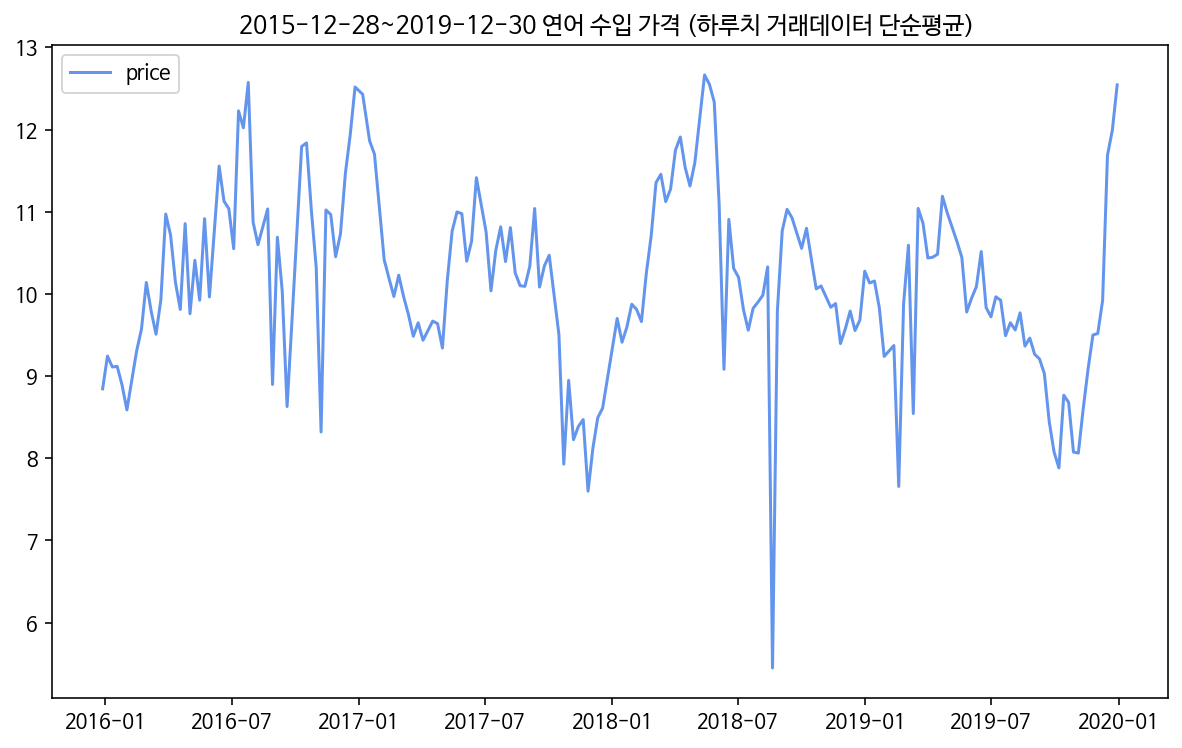

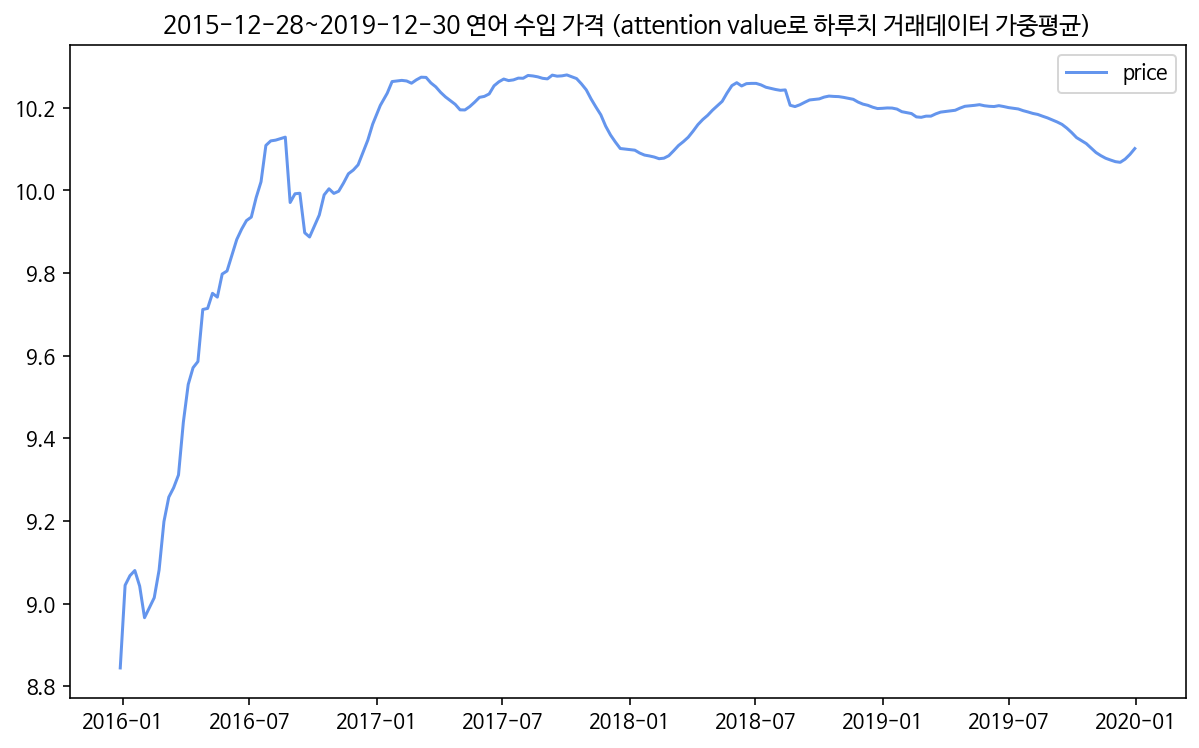

In [ ]:
'''
num_layer = 10
'''

plt.figure(figsize=(10, 6))

plt.plot(salmon_t['P_PRICE'].groupby(salmon_t['REG_DATE']).mean(), color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2015-12-28~2019-12-30 연어 수입 가격 (하루치 거래데이터 단순평균) ")
plt.show()


plt.figure(figsize=(10, 6))

x = salmon_t['REG_DATE'].unique()
y = salmon_train_price
plt.plot(x,y, color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2015-12-28~2019-12-30 연어 수입 가격 (attention value로 하루치 거래데이터 가중평균)")
plt.show()

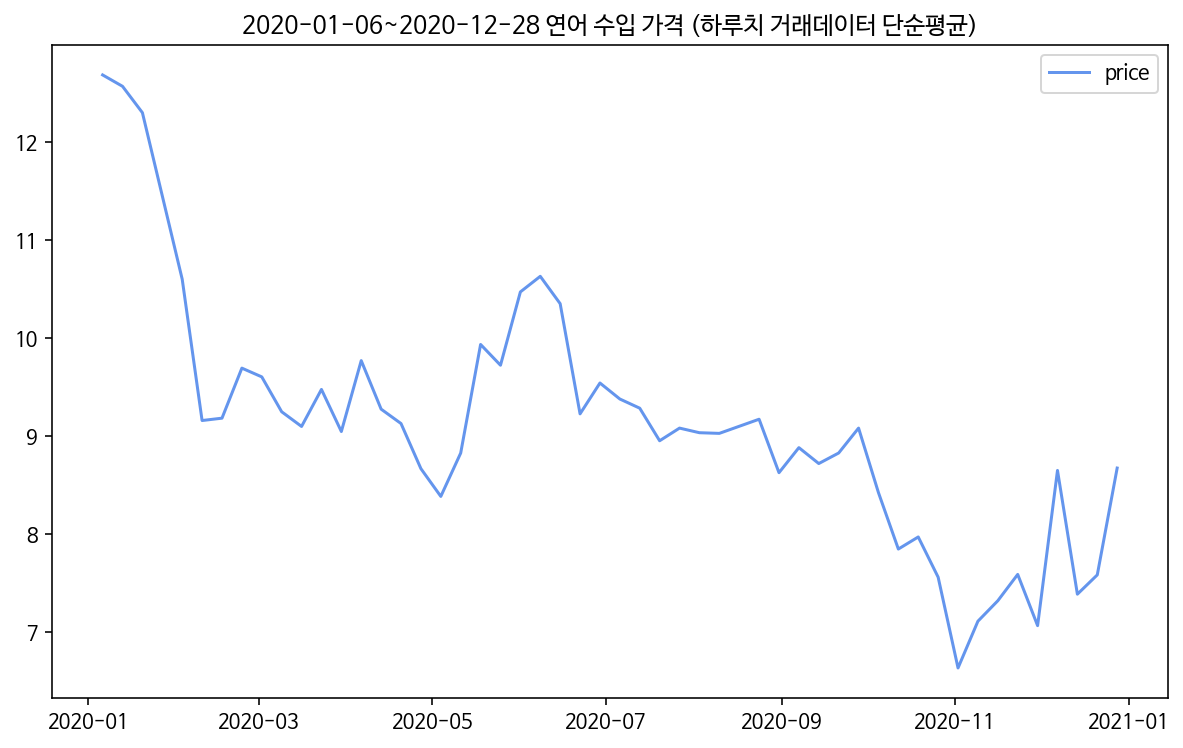

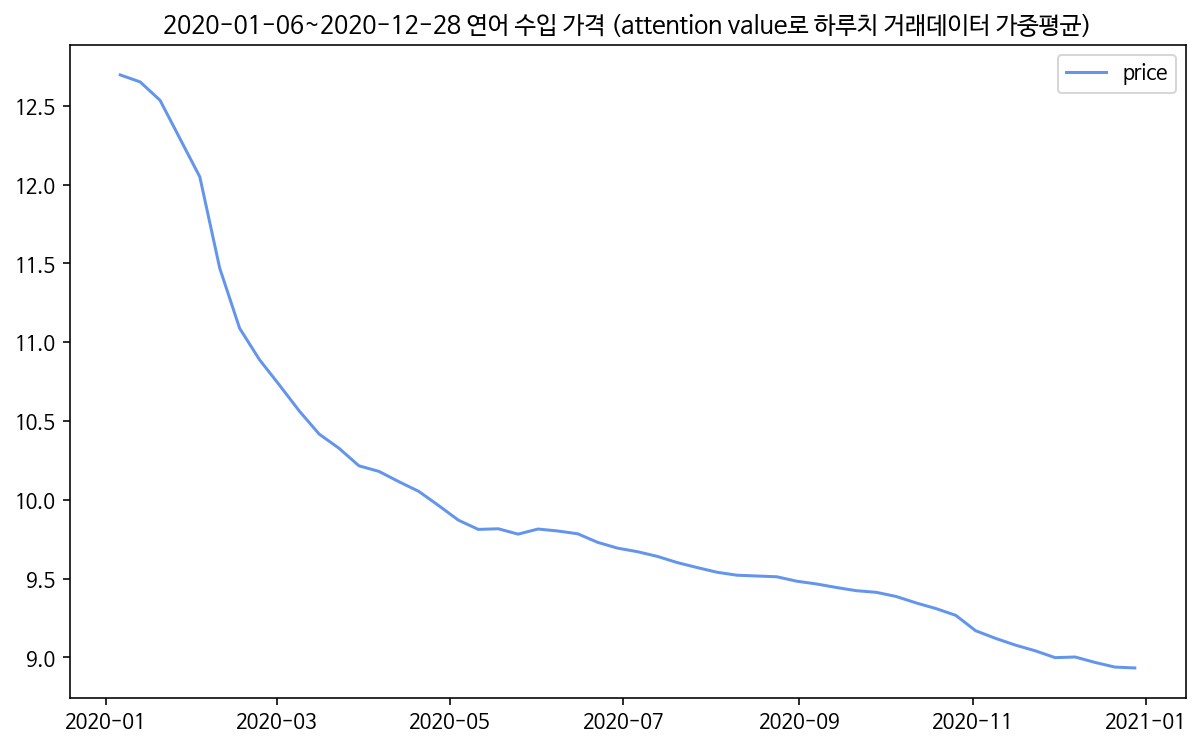

In [ ]:
'''
num_layer = 10
'''
plt.figure(figsize=(10, 6))

plt.plot(salmon_v['P_PRICE'].groupby(salmon_v['REG_DATE']).mean(), color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2020-01-06~2020-12-28 연어 수입 가격 (하루치 거래데이터 단순평균)")
plt.show()


plt.figure(figsize=(10, 6))

x = salmon_v['REG_DATE'].unique()
y = salmon_val_price
plt.plot(x,y, color = 'cornflowerblue', label = 'price')
plt.legend()
plt.title("2020-01-06~2020-12-28 연어 수입 가격 (attention value로 하루치 거래데이터 가중평균)")
plt.show()

### ARIMA 비교

In [ ]:
salmon_trn_lst = np.array([item for item in salmon_train_price if item > 0])

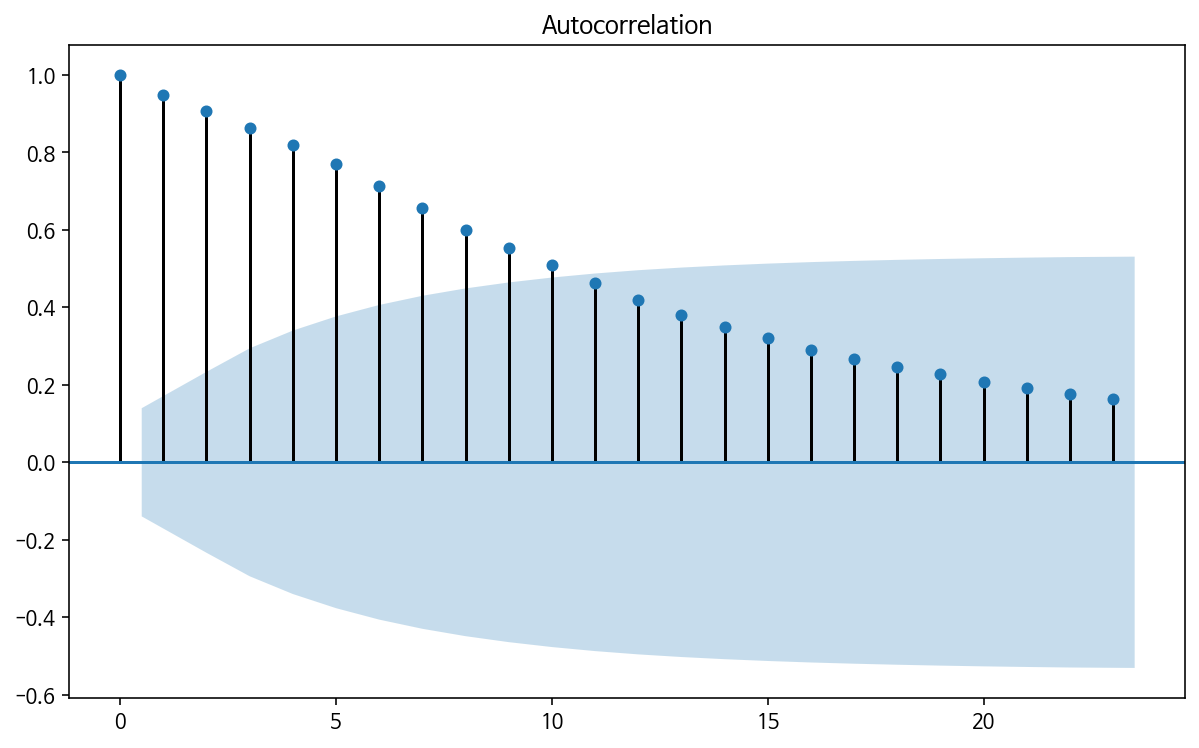

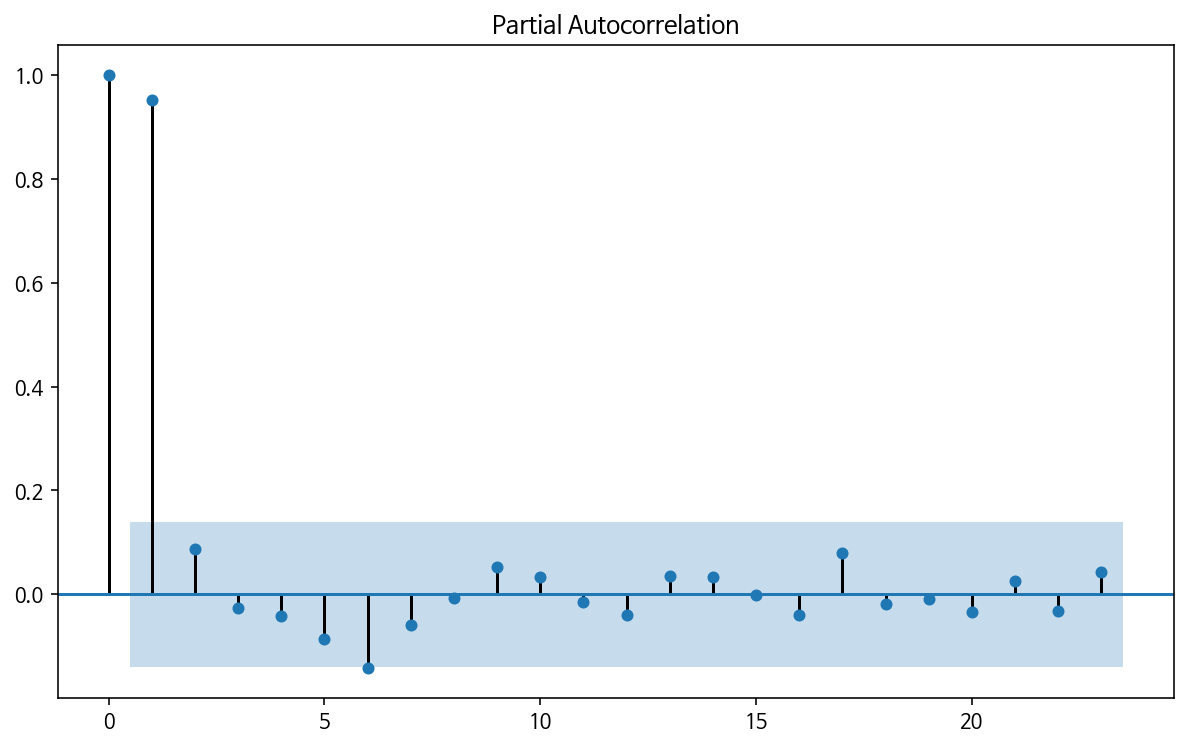

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rc("figure", figsize=(10,6))
plot_acf(np.array(salmon_train_price))
plot_pacf(np.array(salmon_train_price))
plt.show()

In [ ]:
salmon_ts_train = np.array(salmon_train_price)

In [ ]:
model = ARIMA(salmon_trn_lst, order=(0,2,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  195
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 414.748
Method:                       css-mle   S.D. of innovations              0.029
Date:                Wed, 15 Sep 2021   AIC                           -823.495
Time:                        06:13:49   BIC                           -813.676
Sample:                             2   HQIC                          -819.520
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.068      0.287      -0.001       0.000
ma.L1.D2.y    -0.8826      0.056    -15.858      0.000      -0.992      -0.774
                                    Roots           

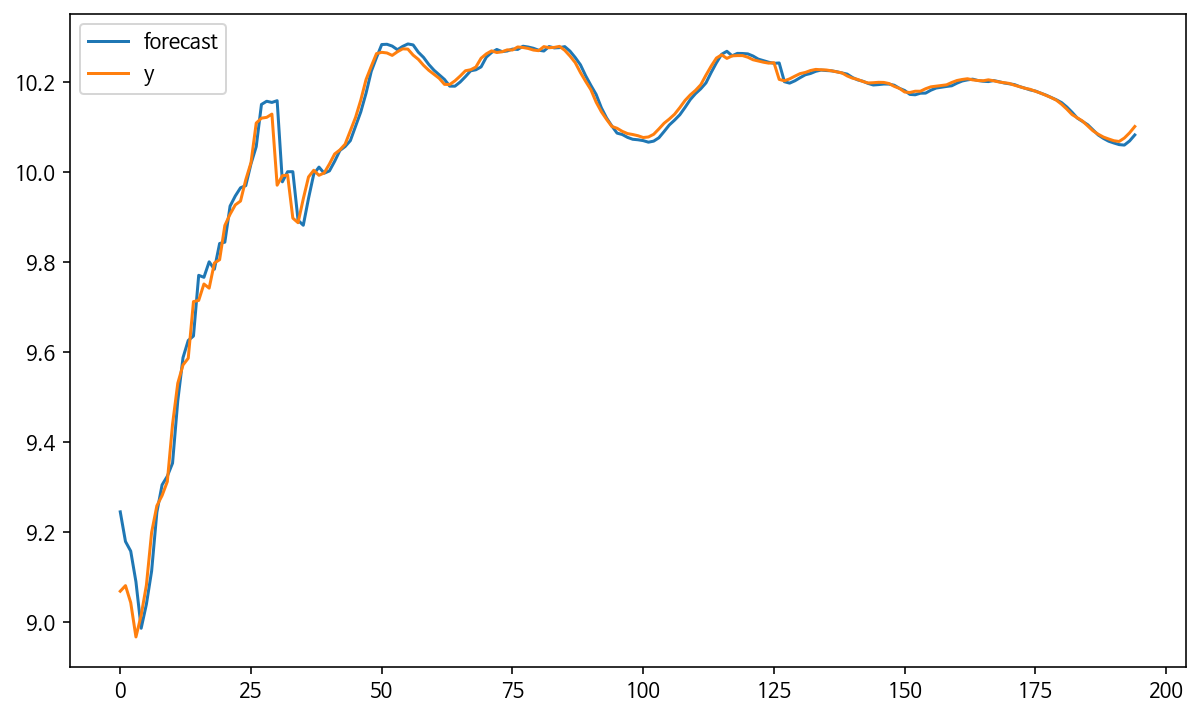

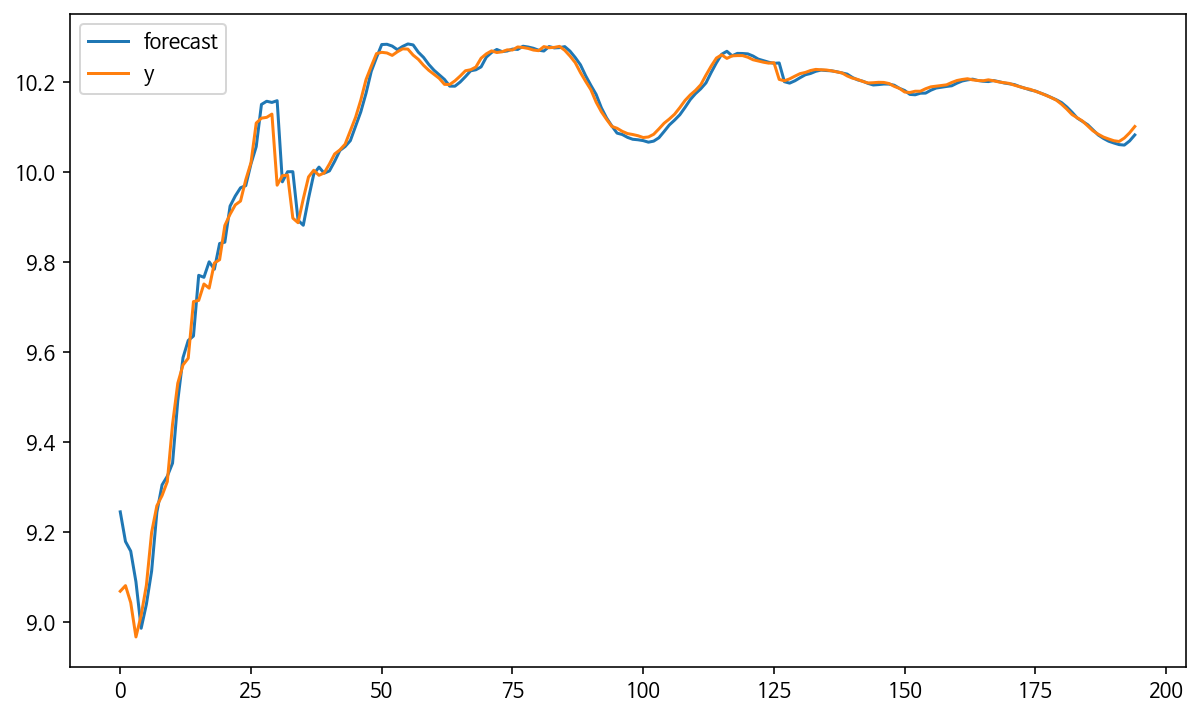

In [ ]:
plt.rc("figure", figsize=(10,6))
model_fit.plot_predict()

In [ ]:
fore = model_fit.forecast(steps=52)

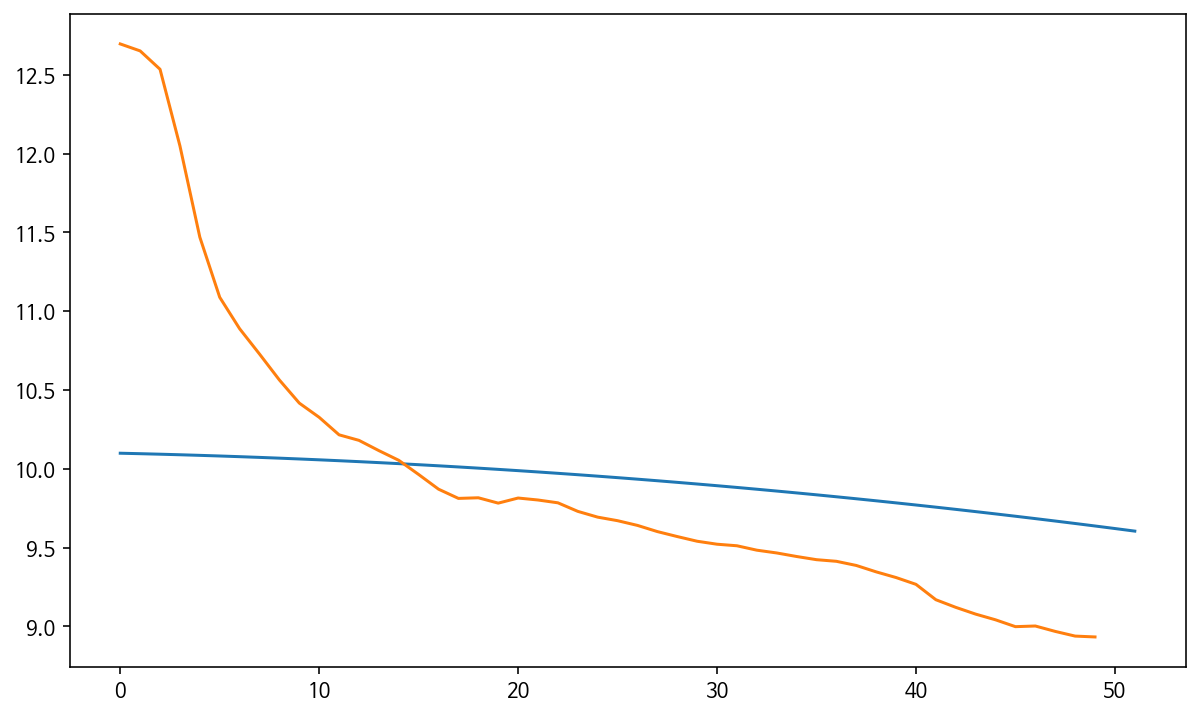

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(fore[0])
plt.plot(salmon_val_price)

### Facebook Prophet

In [ ]:
## 프로펫에 피팅하기 위해서 dataframe 형태 수정
salmon_prophet_df = pd.DataFrame(columns=['ds','y'])
salmon_prophet_df['ds'] = list(Counter(salmon_train['REG_DATE']).keys())
salmon_prophet_df['y'] = salmon_ts_train

In [ ]:
m = Prophet(changepoint_prior_scale=0.3)
m.fit(salmon_prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

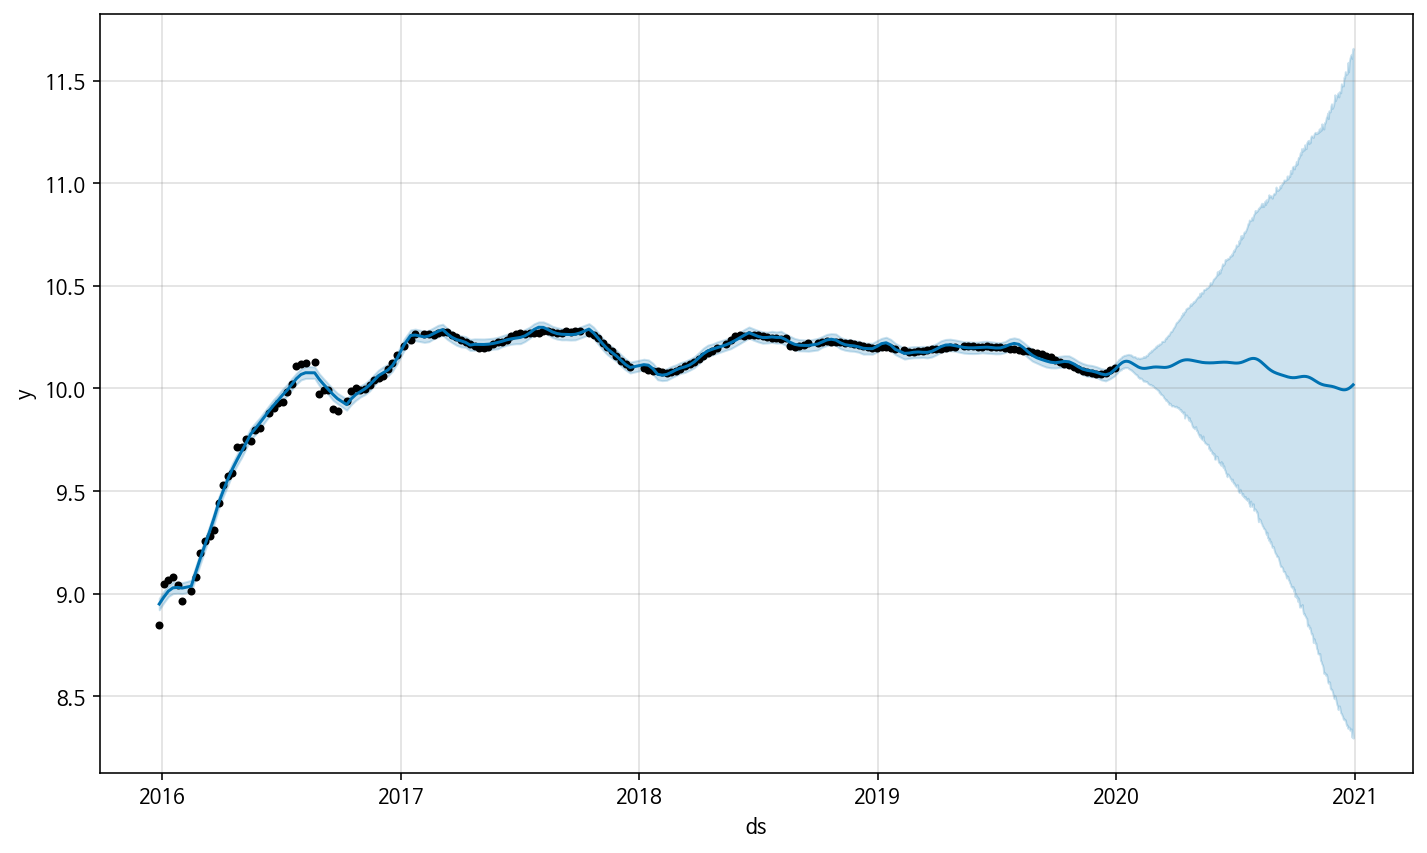

In [ ]:
plt.rc("figure", figsize=(10,6))
fig1 = m.plot(forecast)

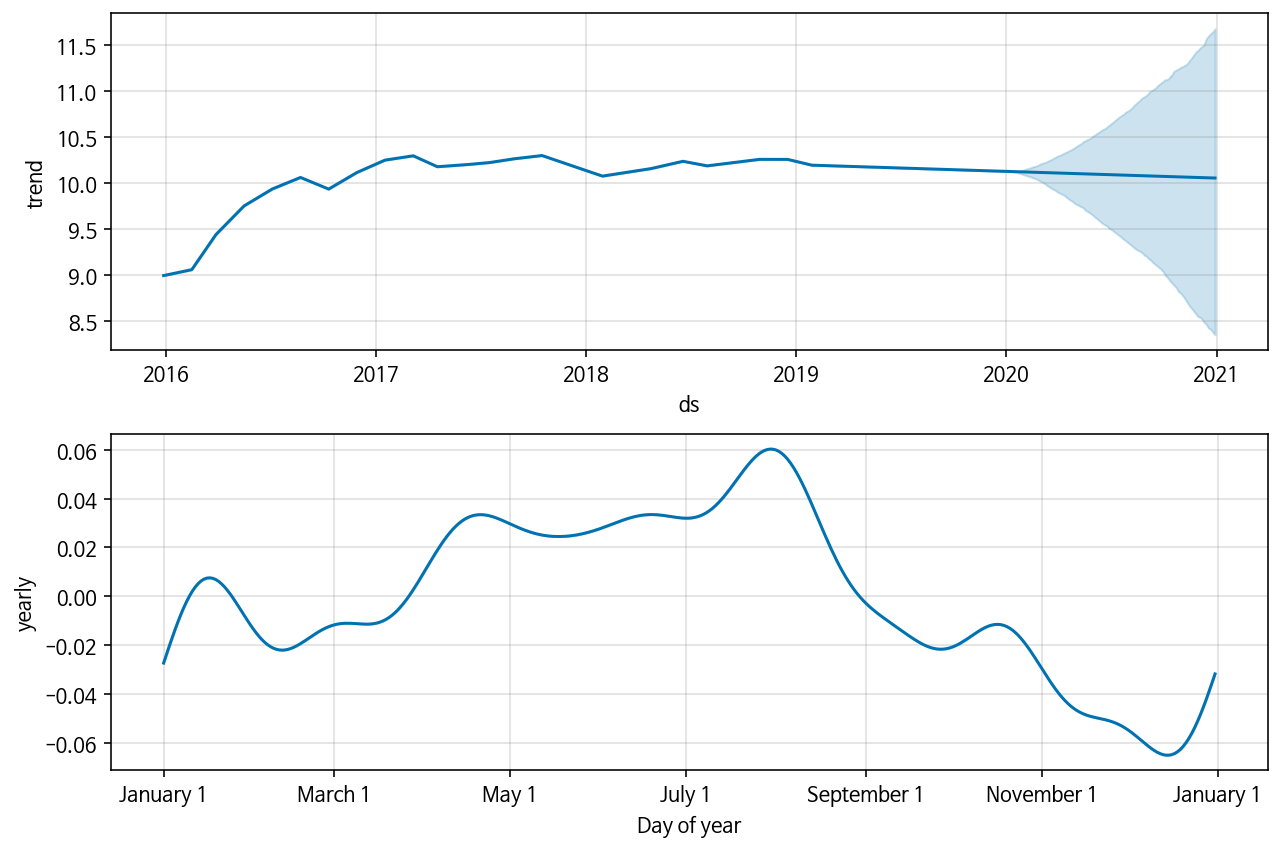

In [ ]:
plt.rc("figure", figsize=(10,6))
fig2 = m.plot_components(forecast)

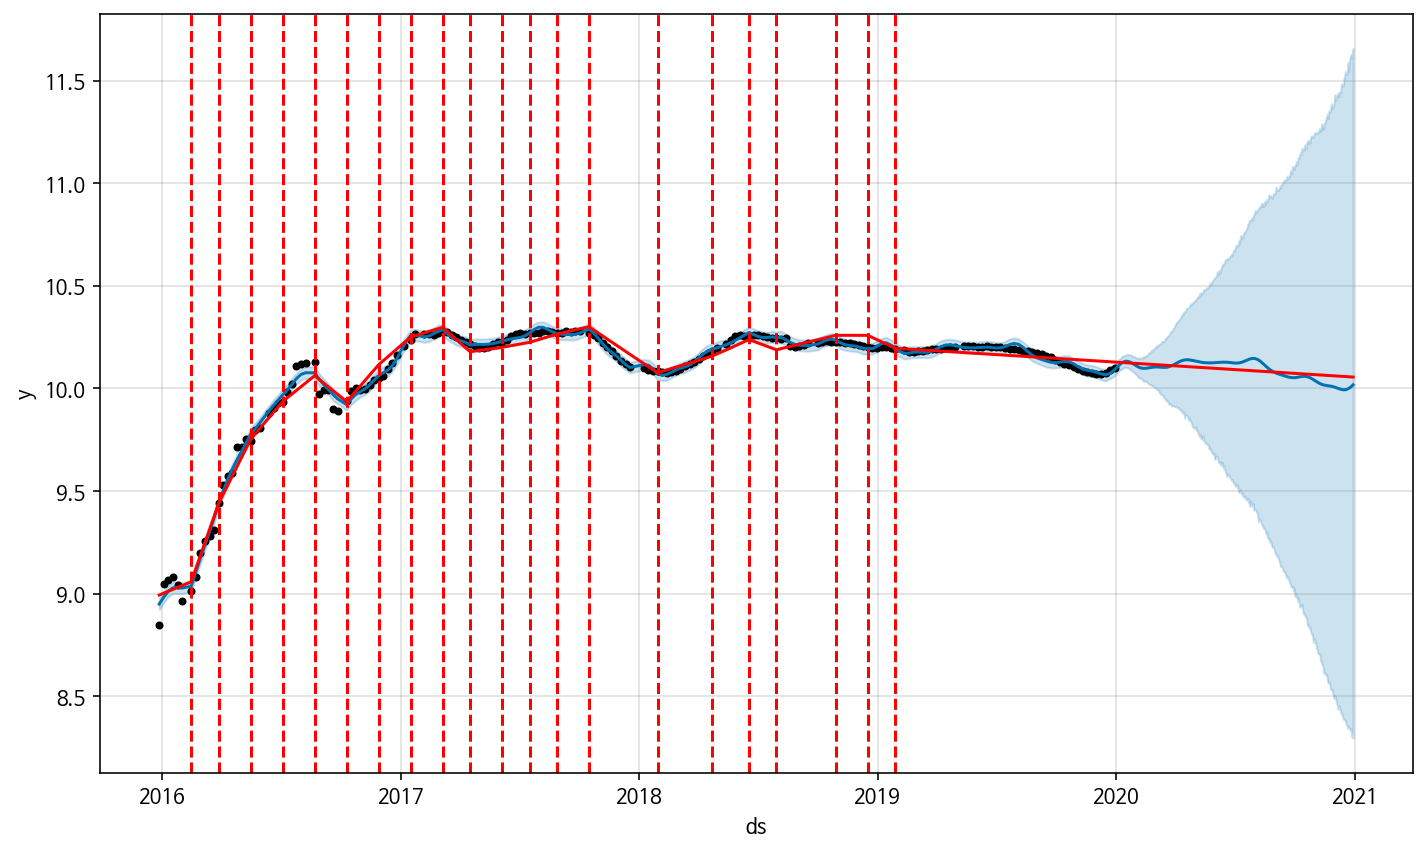

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

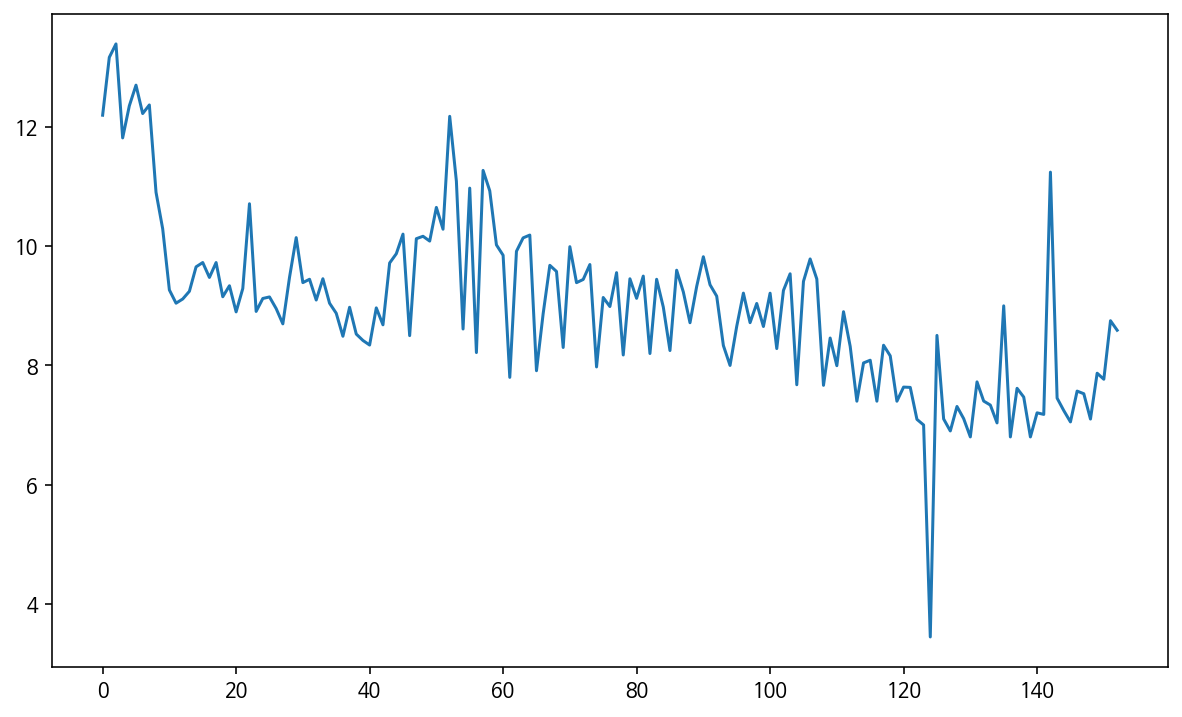

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(salmon_val_y)

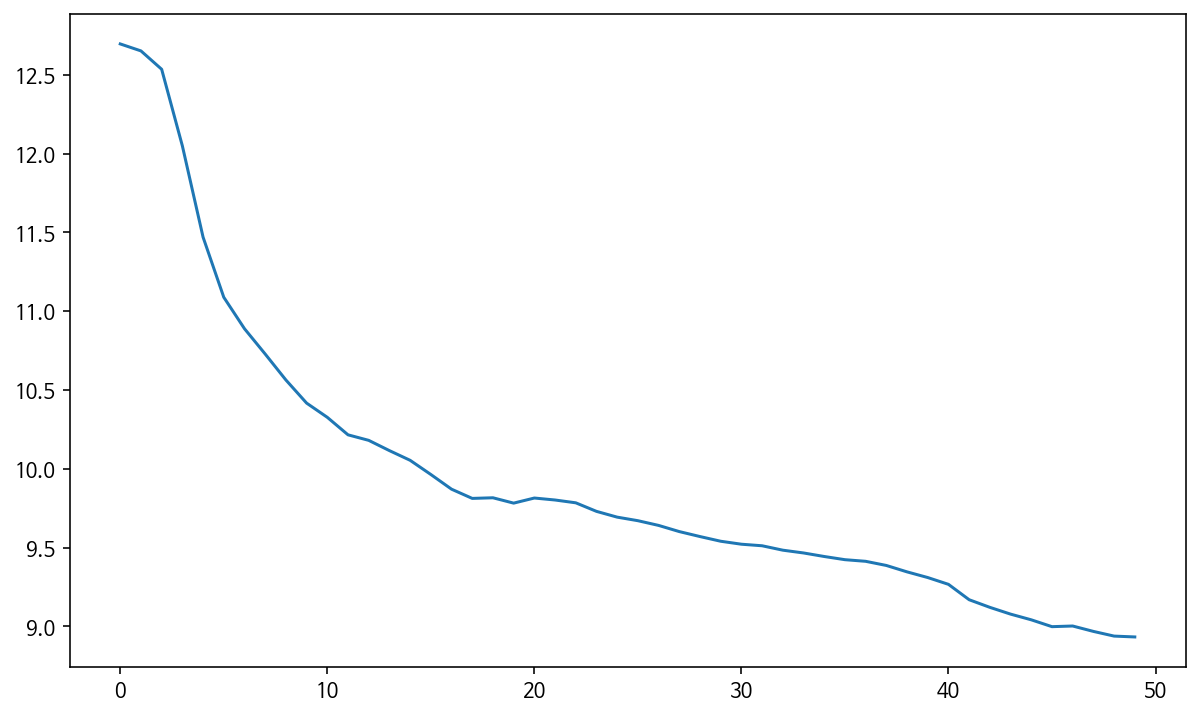

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(salmon_val_price)

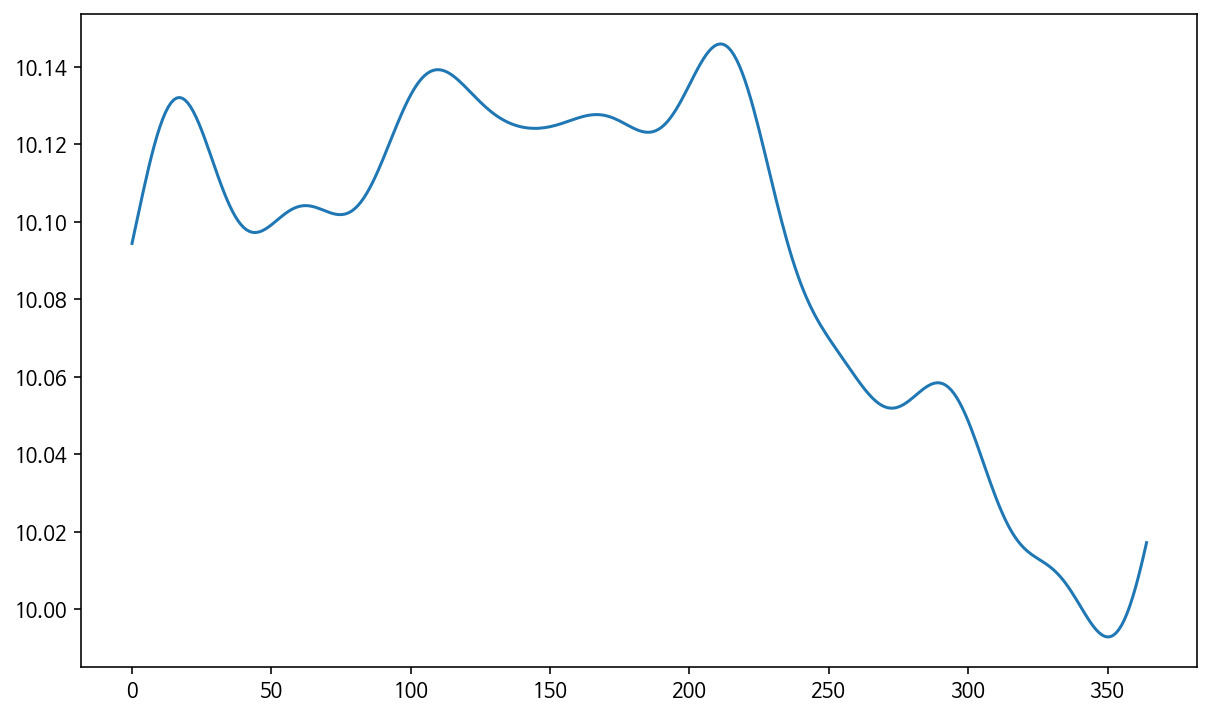

In [ ]:
plt.rc("figure", figsize=(10,6))
plt.plot(list(forecast[-365:]['yhat']))

In [ ]:
forecast.head(10)

ds     trend  ...  multiplicative_terms_upper      yhat
0 2015-12-28  8.992689  ...                         0.0  8.948998
1 2016-01-04  9.001892  ...                         0.0  8.982484
2 2016-01-11  9.011095  ...                         0.0  9.011824
3 2016-01-18  9.020297  ...                         0.0  9.027831
4 2016-01-25  9.029500  ...                         0.0  9.030111
5 2016-02-01  9.038703  ...                         0.0  9.026635
6 2016-02-15  9.057108  ...                         0.0  9.035819
7 2016-02-22  9.120824  ...                         0.0  9.104447
8 2016-02-29  9.184540  ...                         0.0  9.172551
9 2016-03-07  9.248256  ...                         0.0  9.237158

[10 rows x 16 columns]

### Neural Prophet

In [ ]:
# 평가지표 RMSE 함수
def rmse(y: List, yhat:List)->float:
  # y값의 갯수
  n = len(y)
  mse = 0
  for i in range(n):
    # 실제값에서 예측값 뺀것의 제곱
    mse += (y[i] - yhat[i])**2
  rmse = (mse/n)**0.5
  return rmse

In [ ]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 
epochs = 1000

#### Neural Prophet - normal

In [ ]:
## 모델 피팅하기 위해서 수정된 dataframe 사용
salmon_prophet_df.shape

(197, 2)

In [ ]:
# 예측 기간 데이터셋 생성
salmon_prophet_df_val = list(salmon_v['REG_DATE'].unique())
salmon_prophet_future = pd.DataFrame(salmon_prophet_df_val, columns=['ds'])
salmon_prophet_future['y'] = None

In [ ]:
# 모델 학습
m = NeuralProphet()
metrics = m.fit(salmon_prophet_df, freq=freq, epochs=epochs)

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:03<00:00, 15.81it/s, SmoothL1Loss=0.000351, MAE=0.0349, RegLoss=0]


In [ ]:
# train 데이터의 마지막일 기준으로, 일주일 간격 * 70 의 테스트데이터 생성
salmon_future = m.make_future_dataframe(salmon_prophet_df, periods=70)
salmon_forecast = m.predict(salmon_future)

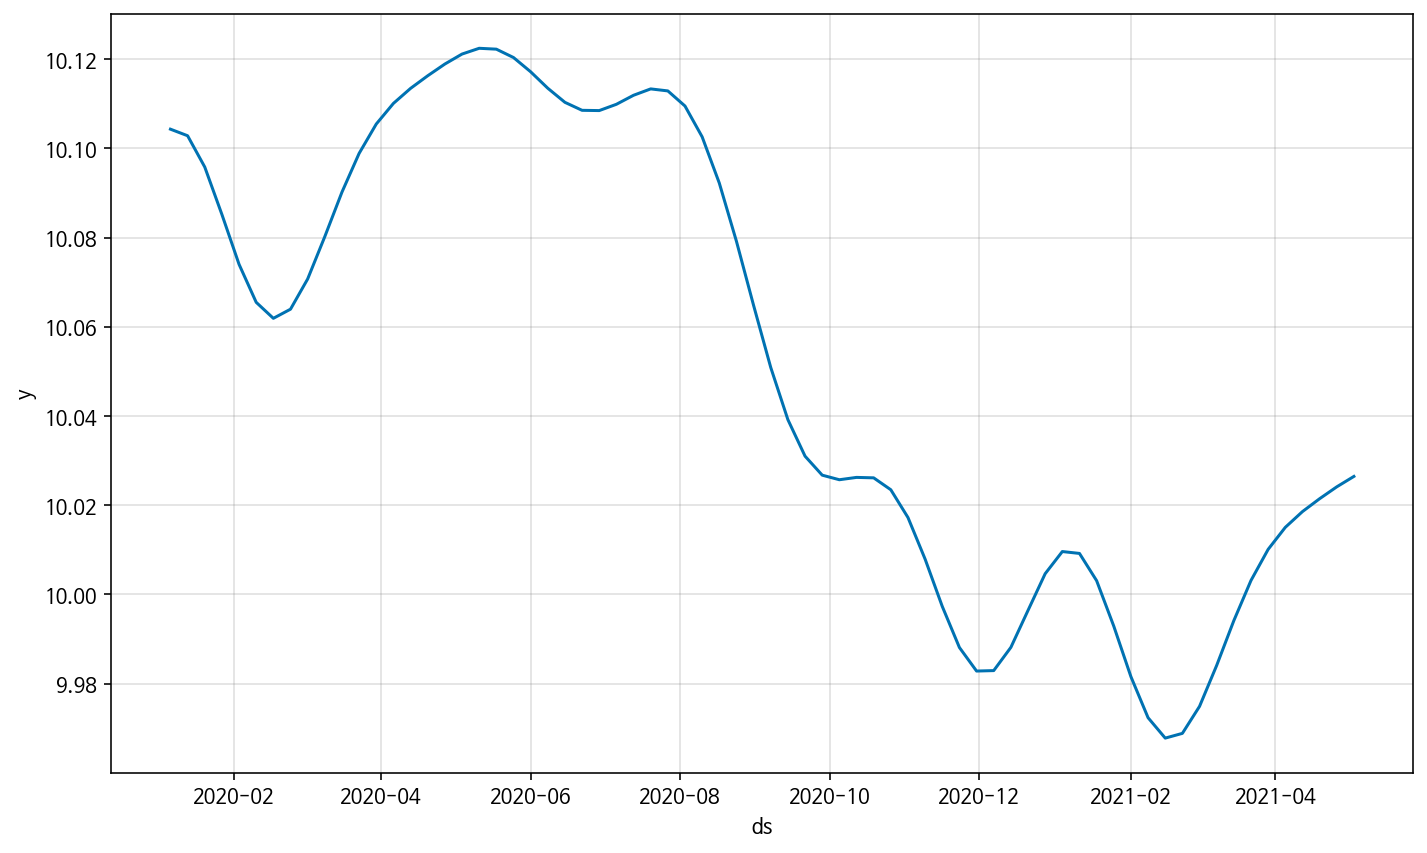

In [ ]:
salmon_forecasts_plot = m.plot(salmon_forecast)

In [ ]:
# validation 기간에 맞는 예측 데이터 프레임 구성
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in salmon_prophet_df_val:
  a = a.append(salmon_forecast.iloc[salmon_forecast.loc[salmon_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(salmon_val_price, a['yhat1'])

0.925127084031232

#### Neural Prophet - Trend

In [ ]:
m = NeuralProphet(
    n_changepoints=100,
    #trend_smoothness=2,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs =epochs
)
metrics = m.fit(salmon_prophet_df, freq=freq)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.00it/s, SmoothL1Loss=0.00011, MAE=0.0166, RegLoss=0]


In [ ]:
salmon_future = m.make_future_dataframe(salmon_prophet_df, periods=70, n_historic_predictions=len(salmon_prophet_df))
salmon_forecast = m.predict(salmon_future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in salmon_prophet_df_val:
  a = a.append(salmon_forecast.iloc[salmon_forecast.loc[salmon_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(salmon_val_price, a['yhat1'])

0.900053408974677

#### Nueral Prophet - Seasonality

In [ ]:
m = NeuralProphet(
    n_changepoints=200,
    yearly_seasonality=15,
    weekly_seasonality=3,
    seasonality_reg=30,
    num_hidden_layers=20,
)
metrics = m.fit(salmon_prophet_df, freq=freq)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 162
INFO:nprophet.config:Auto-set epochs to 162


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
INFO:nprophet:learning rate range test found optimal lr: 1.87E-01
Epoch[162/162]: 100%|██████████| 162/162 [00:11<00:00, 14.73it/s, SmoothL1Loss=0.000336, MAE=0.0305, RegLoss=5.44e-5]


In [ ]:
salmon_future = m.make_future_dataframe(salmon_prophet_df, periods=70, n_historic_predictions=len(salmon_prophet_df))
salmon_forecast = m.predict(salmon_future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in salmon_prophet_df_val:
  a = a.append(salmon_forecast.iloc[salmon_forecast.loc[salmon_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(salmon_val_price, a['yhat1'])

0.9022741161362651

#### 최적 하이퍼 파라미터

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

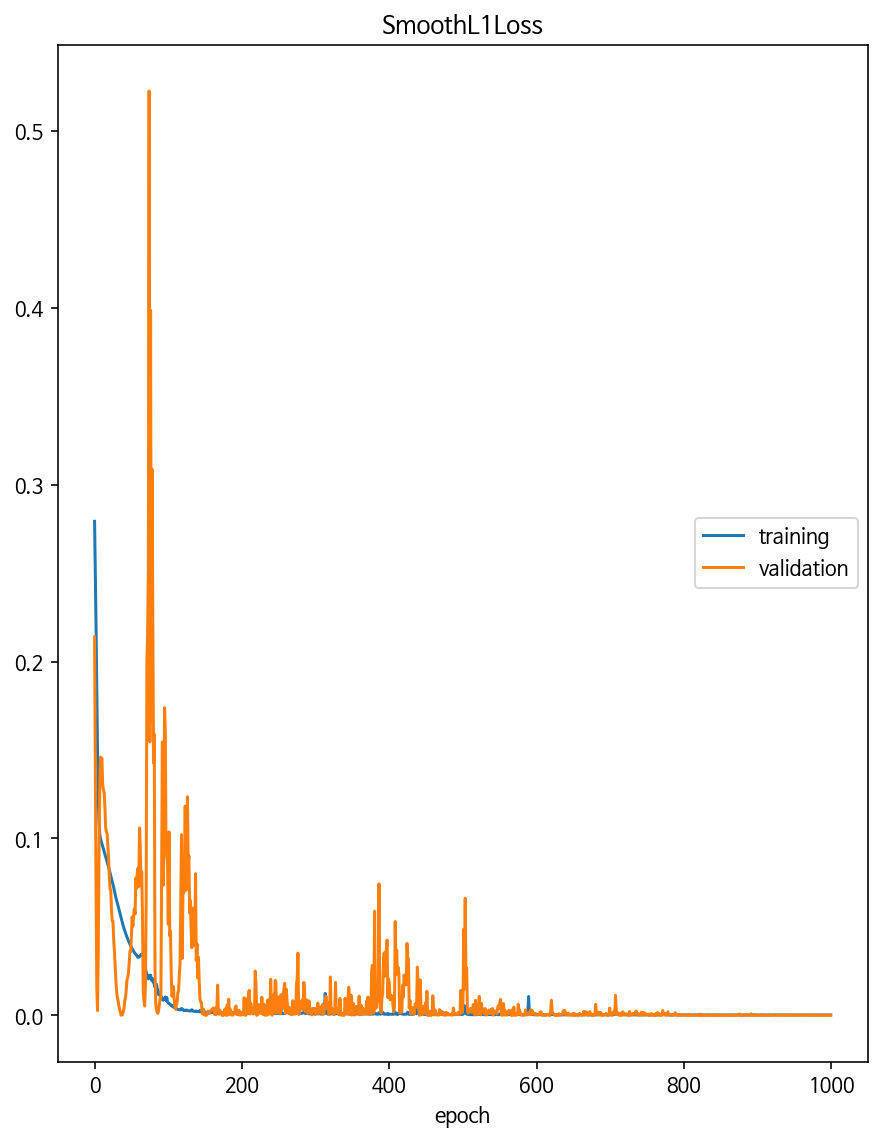

Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:07<00:00, 14.82it/s, SmoothL1Loss=0.000261, MAE=0.0271, RegLoss=0.00132, MAE_val=0.0275, SmoothL1Loss_val=0.000179]


In [ ]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(salmon_prophet_df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [ ]:
salmon_future = nprophet.make_future_dataframe(salmon_prophet_df, periods=52, n_historic_predictions=300)
salmon_forecast = nprophet.predict(salmon_future)
salmon_forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)
salmon_forecast.tail()

ds   y     yhat1  residual1     trend  season_weekly  season_daily
244 2020-11-30 NaN  9.929780        NaN  9.929780  -6.062994e-08 -4.965819e-08
245 2020-12-07 NaN  9.926075        NaN  9.926075  -6.062994e-08 -4.965819e-08
246 2020-12-14 NaN  9.922370        NaN  9.922370  -6.062994e-08 -4.965819e-08
247 2020-12-21 NaN  9.918664        NaN  9.918664  -6.062994e-08 -4.965819e-08
248 2020-12-28 NaN  9.914959        NaN  9.914959  -6.062994e-08 -4.965819e-08

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in salmon_prophet_df_val:
  a = a.append(salmon_forecast.iloc[salmon_forecast.loc[salmon_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(salmon_val_price, a['yhat1'])

0.8897435303444791

#### 최적 하이퍼 파라미터 ver.2

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.01


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

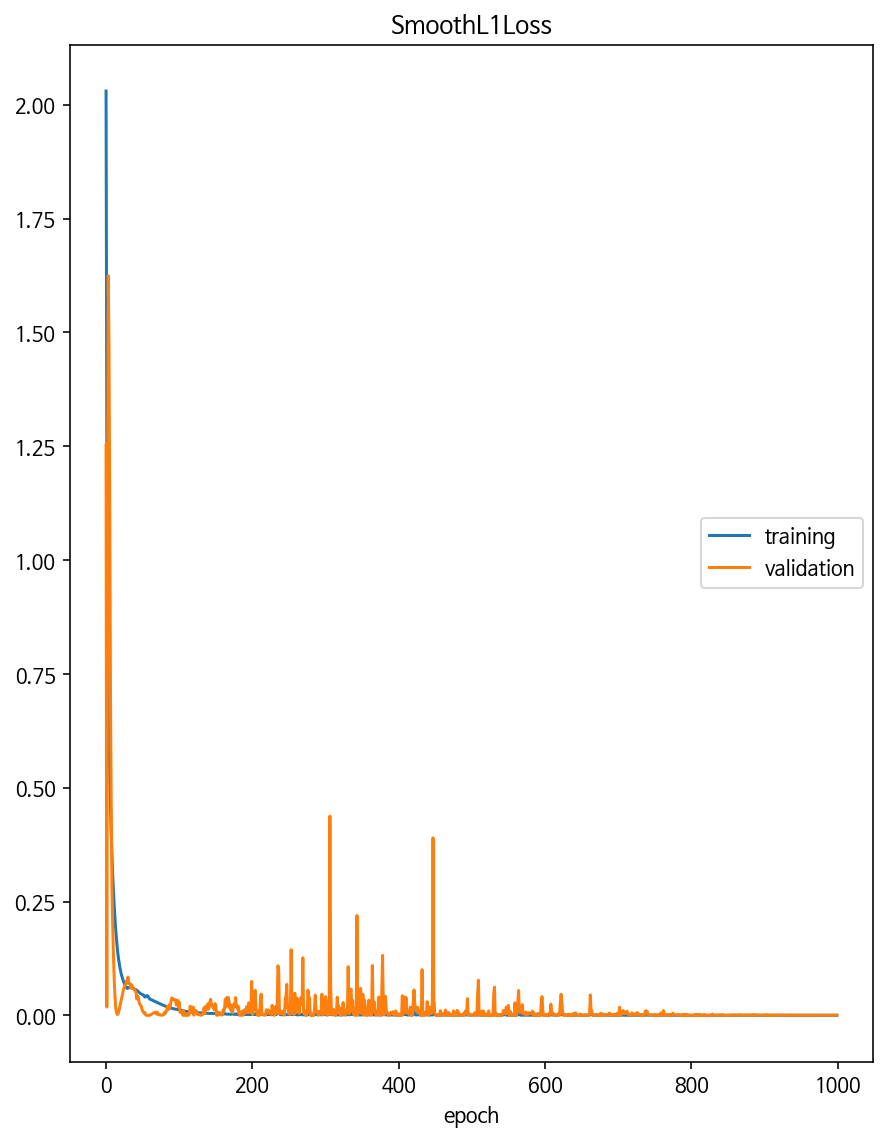

Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:07<00:00, 14.88it/s, SmoothL1Loss=0.000242, MAE=0.024, RegLoss=0.00129, MAE_val=0.0501, SmoothL1Loss_val=0.000509]


In [ ]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(salmon_prophet_df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [ ]:
salmon_future = nprophet.make_future_dataframe(salmon_prophet_df, periods=52, n_historic_predictions=300)
salmon_forecast = nprophet.predict(salmon_future)
salmon_forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)
salmon_forecast.tail()

ds   y      yhat1  ...      trend  season_weekly  season_daily
244 2020-11-30 NaN  10.050545  ...  10.050545   1.371351e-07  1.582355e-08
245 2020-12-07 NaN  10.048559  ...  10.048559   1.371351e-07  1.582355e-08
246 2020-12-14 NaN  10.046574  ...  10.046573   1.371351e-07  1.582355e-08
247 2020-12-21 NaN  10.044587  ...  10.044587   1.371351e-07  1.582355e-08
248 2020-12-28 NaN  10.042602  ...  10.042601   1.371351e-07  1.582355e-08

[5 rows x 7 columns]

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in salmon_prophet_df_val:
  a = a.append(salmon_forecast.iloc[salmon_forecast.loc[salmon_forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(salmon_val_price, a['yhat1'])

0.9220927950429988

#### 최적 하이퍼 파라미터 ver.3

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = [0.005, 0.01, 0.015]


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = [10,20,30] # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = [100, 150, 200] # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [ ]:
# 파라미터별 rmse 저장할 데이터 프레임 생성 
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
# 데이터 프레임 row index 변수 생성
count=0
# 파라미터 조합 반복문 실행
for lr in learning_rate:
  for layer in num_hidden_layers:
    start = timer()
    for changepoint in n_changepoints:

      nprophet = NeuralProphet(
                                yearly_seasonality=False, 
                                weekly_seasonality=True, 
                                daily_seasonality=True,
                                learning_rate=lr, 
                                changepoints_range=changepoints_range, 
                                n_forecasts=n_forecasts,
                                ar_sparsity=ar_sparsity, 
                                n_changepoints=changepoint, 
                                growth='logistic', 
                                seasonality_mode='multiplicative', 
                                trend_reg=trend_reg,
                                num_hidden_layers=layer,
                                seasonality_reg = seasonality_reg)
      
      nprophet.fit(salmon_prophet_df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
      #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
      future = nprophet.make_future_dataframe(salmon_prophet_df, periods=52, n_historic_predictions=300)
      forecast = nprophet.predict(future)

      a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
      for i in salmon_prophet_df_val:
        a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
      a.reset_index(drop=True, inplace = True)
      
      result.loc[count] = lr, layer, changepoint, rmse(salmon_val_price, a['yhat1'])
      count += 1
      end = timer()
      print(end-start)

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
Epoch[847/1000]:  85%|████████▍ | 846/1000 [00:46<00:08, 18.43it/s, SmoothL1Loss=0.00188, MAE=0.0391, RegLoss=0.00114, MAE_val=0.0237, SmoothL1Loss_val=0.000144]

#### 최적 하이퍼파라미터 적용 (10회 실험)

In [ ]:
## neural prophet
epochs = 1000
#batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 50 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=10

#n_lags = 5  # >error : lambda delay가 없다

In [375]:
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
count = 0
for king in range(10):
  nprophet = NeuralProphet(
                            yearly_seasonality=False, 
                            weekly_seasonality=True, 
                            daily_seasonality=True,
                            learning_rate=learning_rate, 
                            changepoints_range=changepoints_range, 
                            n_forecasts=n_forecasts,
                            ar_sparsity=ar_sparsity, 
                            n_changepoints=n_changepoints, 
                            growth='logistic', 
                            seasonality_mode='multiplicative', 
                            trend_reg=trend_reg,
                            num_hidden_layers=num_hidden_layers,
                            seasonality_reg = seasonality_reg)

  nprophet.fit(salmon_prophet_df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
  #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
  future = nprophet.make_future_dataframe(salmon_prophet_df, periods=52, n_historic_predictions=300)
  forecast = nprophet.predict(future)
  a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
  for i in salmon_prophet_df_val:
    a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
  a.reset_index(drop=True, inplace = True)
  result.loc[count] = learning_rate, num_hidden_layers, n_changepoints, rmse(salmon_val_price, a['yhat1'])
  count += 1

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:21<00:00, 12.33it/s, SmoothL1Loss=0.00238, MAE=0.0724, RegLoss=0.109, MAE_val=0.0691, SmoothL1Loss_val=0.000937]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: No

In [376]:
result.sort_values(by='rmse')

learning_rate  num_hidden_layers  n_changepoints      rmse
9          0.005               50.0           200.0  0.850172
2          0.005               50.0           200.0  0.861136
4          0.005               50.0           200.0  0.869836
5          0.005               50.0           200.0  0.871198
8          0.005               50.0           200.0  0.877272
7          0.005               50.0           200.0  0.898626
1          0.005               50.0           200.0  0.943589
6          0.005               50.0           200.0  0.945956
0          0.005               50.0           200.0  0.955969
3          0.005               50.0           200.0  0.956240

In [377]:
np.mean(result['rmse'].values)

0.9029993281364492